# Step 2: Normalize your data using sctransform

Use this notebook to normalize your data using the [sctransform](https://satijalab.org/seurat/articles/sctransform_vignette) package. 

Please note that the sctransform package is written in R. Therefore, in order to run this notebook you will first need to [install R]() on your system, as well as [sctransform version 0.4.1](https://github.com/satijalab/sctransform) and it's corresponding dependencies (including the optional dependency [glmGamPoi](https://github.com/const-ae/glmGamPoi)). 

Also note that your raw data input should be a csv file arranged using [tidy format](https://tidyr.tidyverse.org/articles/tidy-data.html). At a minimum your input csv should have five columns:
1. A column that corresponds to the first mode of your tensor. In metatranscriptomic data this column might indicate gene ID.
    - This first mode should generally be the longest in your tensor, and the one that corresponds to the variable you want clustered (e.g. genes in the case of metatranscriptomics data). The sparsity penalty (`lambda`) will be applied to this mode.
1. A column that corresponds to the second mode of your tensor. In metatranscriptomic data this column might indicate taxon ID.
1. A column that corresponds to the third mode of your tensor. This column should indicate sample ID.
    - **IMPORTANT: Sample IDs should be identical for different replicates of the same sample condition (see example below).**
1. A column that indicates the replicate ID of the sample.
1. A column that corresponds to the data variable. For raw metatranscriptomic data this column might contain read counts.

Here's a snippet of how an example csv might be arranged:

| gene_id | taxon_id   | sample_id | replicate | residual |
|---------|------------|-----------|-----------|----------|
| K03839  | P. marinus | sample1   | A         | 3.02     |
| K03839  | P. marinus | sample1   | B         | 3.31     |
| K03839  | P. marinus | sample1   | C         | 3.18     |
| K03839  | P. marinus | sample2   | A         | -1.24    |
| ...     | ...        | ...       | ...       | ...      |
| K03320  | S. marinus | sample9   | C         | 0.05     |

In [79]:
# imports

# python packages
import math
import numpy as np
import os
import pandas as pd
import rpy2
import seaborn as sns

from matplotlib import pyplot as plt

# rpy2 imports
from rpy2 import robjects as ro
from rpy2.robjects.packages import importr
from rpy2.ipython.ggplot import image_png
from rpy2.robjects import pandas2ri

# load rpy2 extension for ipython
pandas2ri.activate()
%load_ext rpy2.ipython


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [80]:
# install & import sctransform and other r package dependencies

# check if sctransform is installed
if not ro.packages.isinstalled('sctransform'):
    # select CRAN mirror
    utils = importr('utils')
    utils.chooseCRANmirror(ind=1)
    # install sctransform
    utils.install_packages(ro.vectors.StrVector(['sctransform']))

# import sctransform and R Matrix package
sctransform = importr('sctransform')
rmatrix = importr('Matrix')

# check sctransform version (should be 0.4.1)
print(f'Installed sctransform version: {sctransform.__version__}')
if not sctransform.__version__ == '0.4.1':
    raise Exception('Please ensure that the installed sctransform is version 0.4.1')
    
# check that glmGamPoi depencency is installed
if not ro.packages.isinstalled('glmGamPoi'):
    raise Exception('Please install glmGamPoi: https://github.com/const-ae/glmGamPoi')


Installed sctransform version: 0.4.1


### Input data

In this step you will enter the variables necessary to:
1. Locate your input data
1. Configure your data tensor (i.e. which three variables correspond to the three different modes or axes)
1. Configure your normalization scheme

When it comes to normalization, there are several parameters you need to define:
- You will normalize by one of the variables that corresponds to a mode in your data tensor. You can think of this as the variable that defines the "within" groups. For example if I am normalizing by taxa, then the normalization procedure will be applied independently within each taxon in the dataset. Put another way, you can think of each taxon as a slab of your data tensor (i.e. a matrix), and the normalization will be applied independently to each slab.
- For each slab, you will define which of the remaining two modes best corresponds to samples, and which to genes. For example, in metatranscriptomic data annotated with KEGG orthologies, the sample ID would be the sample mode, and the KEGG ID would be the gene mode. Additionally, if you want to account for batch effects in your data, the batch variable should relate to your sample mode.
- You will define two thresholds that will apply to each slab (e.g. taxon):
    1. Sample threshold: each gene must be detected in at least this many samples. Genes that fall below the threshold will be removed. Default is 3.
    1. Detection threshold: each sample must contain non-zero values for at least this proportion of genes. Samples that fall below the threshold will be removed. Default is 0.01 (1%).
    - Note that data removed due to thresholding is preserved, saved, and displayed at the end of this notebook so it can be used for troubleshooting or to refine the thresholds and normalization work flow.
- If you want the normalization model to correct for batch effects, you will need to prepare a second csv file with columns corresponding to the sample mode in your data (including both sample ID and replicate), and with an additional column indicating the batch ID. For example, you might have a csv with the following headers: `['sample_id', 'replicate', 'batch_id']`. This file should include each unique combination of sample ID and replicate in your dataset, and the batch membership of each sample replicate should be indicated in the batch ID column.


Either store inputs

In [81]:
datapath = "/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/tidy_tables/G3NS_kofam2021_ALL.csv-iron_KOs.txt-tidys/G3NS_kofam2021_ALL.csv-iron_KOs.txt-barnacle_tensor_tidy.csv"  # Enter the filepath of your input data file:
mode0 = 'KO'  # Enter the column name that will correspond to the first mode of your tensor:
mode1 = 'taxon_trim'  # Enter the column name that will correspond to the second mode of your tensor:
mode2 = "assm_sample"  # Enter the column name that will correspond to the third mode of your tensor:
rep = 'rep'  # ('Enter the column name that corresponds to replicate IDs:')
data = 'estcounts'  # ('Enter the column name that corresponds to your data:')
outdir = "/scratch/bgrodner/iron_ko_contigs/metat_search_results/barnacle/G3NS"  # ('Enter the filepath of the output directory where you want files saved:')

# check output directory exists
if outdir:
    # if not os.path.isdir(outdir):
    #     raise Exception(f'Unable to find the directory "{outdir}"')
    # else:
    #     # make normalization directory within output directory
    outdir_n = f'{outdir}/normalization'
    if not os.path.exists(outdir_n):
        os.makedirs(outdir_n)

# check data file exists
if datapath and not os.path.isfile(datapath):
    raise Exception(f'Unable to find the file "{datapath}"')

Or input using prompt

In [82]:
# input data

# data file
datapath = datapath or input('Enter the filepath of your input data file:')
# check data file exists
if not os.path.isfile(datapath):
    raise Exception(f'Unable to find the file "{datapath}"')

# output directory
outdir = outdir or input('Enter the filepath of the output directory where you want files saved:')
# check output directory exists
if not os.path.isdir(outdir):
    raise Exception(f'Unable to find the directory "{outdir}"')
# make normalization directory within output directory
outdir_n = f'{outdir}/normalization'
if not os.path.exists(outdir_n):
    os.makedirs(outdir_n)

# column names
mode0 = mode0 or input('Enter the column name that will correspond to the first mode of your tensor:')
mode1 = mode1 or input('Enter the column name that will correspond to the second mode of your tensor:')
mode2 = mode2 or input('Enter the column name that will correspond to the third mode of your tensor:')
rep = rep or input('Enter the column name that corresponds to replicate IDs:')
data = data or input('Enter the column name that corresponds to your data:')

Inspect df

In [93]:
# read in csv
df = pd.read_csv(datapath)

# check column names match inputs
for column in [mode0, mode1, mode2, rep, data]:
    if column not in df.columns:
        raise Exception(f'Column name "{column}" not found in headers of file {datapath}')

# tidy up dataframe
df = df[[mode0, mode1, mode2, rep, data]]
df

KO  taxon_trim                       assm_sample rep  estcounts
0       K00216         356    G3.UW.NS-UW38-nan-nan-1.7m-3um   B    0.00000
1       K00216         356    G3.UW.NS-UW32-nan-nan-3.7m-3um   A    0.00000
2       K00216         356    G3.UW.NS-UW25-nan-nan-1.7m-3um   B    0.00000
3       K00216         356  G3.UW.NS-UW32-nan-nan-3.7m-0.2um   C    0.00000
4       K00216         356    G3.UW.NS-UW40-nan-nan-1.7m-3um   B    0.00000
...        ...         ...                               ...  ..        ...
643150  K25290      131567  G3.UW.NS-UW32-nan-nan-1.7m-0.2um   B   13.36147
643151  K25290      131567    G3.UW.NS-UW32-nan-nan-3.7m-3um   C    0.00000
643152  K25290      131567    G3.UW.NS-UW31-nan-nan-2.7m-3um   A    0.00000
643153  K25290      131567  G3.UW.NS-UW32-nan-nan-3.7m-0.2um   A   19.83352
643154  K25290      131567    G3.UW.NS-UW40-nan-nan-2.7m-3um   B    0.00000

[643155 rows x 5 columns]

In [98]:
df.loc[:, ["assm_sample", "rep"]].drop_duplicates().sort_values(by=['assm_sample','rep']).reset_index()

index                       assm_sample rep
0      23  G3.UW.NS-UW25-nan-nan-1.7m-0.2um   A
1      10  G3.UW.NS-UW25-nan-nan-1.7m-0.2um   B
2      18    G3.UW.NS-UW25-nan-nan-1.7m-3um   A
3       2    G3.UW.NS-UW25-nan-nan-1.7m-3um   B
4      20  G3.UW.NS-UW29-nan-nan-1.7m-0.2um   B
5       8    G3.UW.NS-UW29-nan-nan-1.7m-3um   B
6      50    G3.UW.NS-UW31-nan-nan-2.7m-3um   A
7      35  G3.UW.NS-UW32-nan-nan-1.7m-0.2um   A
8      48  G3.UW.NS-UW32-nan-nan-1.7m-0.2um   B
9      15  G3.UW.NS-UW32-nan-nan-1.7m-0.2um   C
10     40    G3.UW.NS-UW32-nan-nan-1.7m-3um   A
11     51  G3.UW.NS-UW32-nan-nan-3.7m-0.2um   A
12     38  G3.UW.NS-UW32-nan-nan-3.7m-0.2um   B
13      3  G3.UW.NS-UW32-nan-nan-3.7m-0.2um   C
14      1    G3.UW.NS-UW32-nan-nan-3.7m-3um   A
15     14    G3.UW.NS-UW32-nan-nan-3.7m-3um   B
16     49    G3.UW.NS-UW32-nan-nan-3.7m-3um   C
17     27  G3.UW.NS-UW35-nan-nan-1.7m-0.2um   A
18     42  G3.UW.NS-UW35-nan-nan-1.7m-0.2um   B
19     25  G3.UW.NS-UW35-nan-nan-1.7m-0.2um   C
20     29    G3.UW.NS-UW35-nan-nan-1.7m-3um   A
21     41    G3.UW.NS-UW35-nan-nan-1.7m-3um   B
22     22    G3.UW.NS-UW35-nan-nan-1.7m-3um   C
23      6  G3.UW.NS-UW35-nan-nan-2.7m-0.2um   A
24     19  G3.UW.NS-UW35-nan-nan-2.7m-0.2um   B
25     44  G3.UW.NS-UW35-nan-nan-2.7m-0.2um   C
26     24    G3.UW.NS-UW35-nan-nan-2.7m-3um   A
27      9    G3.UW.NS-UW35-nan-nan-2.7m-3um   B
28     28    G3.UW.NS-UW35-nan-nan-2.7m-3um   C
29     34  G3.UW.NS-UW37-nan-nan-1.7m-0.2um   A
30     46  G3.UW.NS-UW37-nan-nan-1.7m-0.2um   B
31     21  G3.UW.NS-UW37-nan-nan-1.7m-0.2um   C
32     43    G3.UW.NS-UW37-nan-nan-1.7m-3um   A
33     30    G3.UW.NS-UW37-nan-nan-1.7m-3um   B
34     11    G3.UW.NS-UW37-nan-nan-1.7m-3um   C
35     45  G3.UW.NS-UW38-nan-nan-1.7m-0.2um   A
36     32  G3.UW.NS-UW38-nan-nan-1.7m-0.2um   B
37      5  G3.UW.NS-UW38-nan-nan-1.7m-0.2um   C
38     13    G3.UW.NS-UW38-nan-nan-1.7m-3um   A
39      0    G3.UW.NS-UW38-nan-nan-1.7m-3um   B
40     39    G3.UW.NS-UW38-nan-nan-1.7m-3um   C
41     47  G3.UW.NS-UW40-nan-nan-1.7m-0.2um   A
42     33  G3.UW.NS-UW40-nan-nan-1.7m-0.2um   B
43      7  G3.UW.NS-UW40-nan-nan-1.7m-0.2um   C
44     17    G3.UW.NS-UW40-nan-nan-1.7m-3um   A
45      4    G3.UW.NS-UW40-nan-nan-1.7m-3um   B
46     36    G3.UW.NS-UW40-nan-nan-1.7m-3um   C
47     26  G3.UW.NS-UW40-nan-nan-2.7m-0.2um   A
48     12  G3.UW.NS-UW40-nan-nan-2.7m-0.2um   B
49     31  G3.UW.NS-UW40-nan-nan-2.7m-0.2um   C
50     37    G3.UW.NS-UW40-nan-nan-2.7m-3um   A
51     52    G3.UW.NS-UW40-nan-nan-2.7m-3um   B
52     16    G3.UW.NS-UW40-nan-nan-2.7m-3um   C

Either store parameters

In [84]:
norm_mode_ = 2  # USE INTEGER NOT STRING (f'Which mode do you want to normalize by? 1-{mode0} 2-{mode1} 3-{mode2} (enter 1/2/3):'))
sample_mode_ = 3  # USE INTEGER NOT STRING (f'Which mode corresponds to your sample variable? 1-{mode0} 2-{mode1} 3-{mode2} (enter 1/2/3):'))
sample_thold = 3 # USE INTEGER NOT STRING 'Each {gene_mode} must be detected in what minimum number of unique {sample_mode}s? (Default is 3):'))
gene_thold = 0.01 # USE FLOAT NOT STRINGf'Each {sample_mode} must contain what minimum proportion of nonzero {gene_mode}s? (Default is 0.01):'))
save_data_ = 'y'  # 'Would you like to save the data output for each normalization? (Enter Y/N):'
save_plots_ = 'y'  # 'Would you like to save the diagnostic plots for each normalization? (Enter Y/N):
correction_ = 'n'  # 'Would you like to correct for batch effects? (Enter Y/N):').lower()
metadata_path = ""  # input('Enter the filepath of your batch metadata file:')
batch_id = ''  # input('Enter the column name that corresponds to the batch ID:')

Or input using prompt

In [85]:
# normalization set up 

# by mode
while norm_mode_ not in [1, 2, 3]:
    norm_mode_ = int(input(f'Which mode do you want to normalize by? 1-{mode0} 2-{mode1} 3-{mode2} (enter 1/2/3):'))

# sample mode
while sample_mode_ not in [1, 2, 3]:
    sample_mode_ = int(input(f'Which mode corresponds to your sample variable? 1-{mode0} 2-{mode1} 3-{mode2} (enter 1/2/3):'))
# make a unique identifier that combines sampleID and replicateID
norm_mode = [mode0, mode1, mode2][norm_mode_-1]
sample_mode = [mode0, mode1, mode2][sample_mode_-1]
df['sample_rep_id'] = df[sample_mode].astype(str) + df[rep].astype(str)
gene_mode = [m for m in [mode0, mode1, mode2] if m not in [norm_mode, sample_mode]][0]

# gene mode
# thresholds
sample_thold = sample_thold or int(input(f'Each {gene_mode} must be detected in what minimum number of unique {sample_mode}s? (Default is 3):'))
gene_thold = gene_thold or float(input(f'Each {sample_mode} must contain what minimum proportion of nonzero {gene_mode}s? (Default is 0.01):'))

# output options
while save_data_ not in ['y', 'n']:
    save_data_ = input('Would you like to save the data output for each normalization? (Enter Y/N):').lower()
while save_plots_ not in ['y', 'n']:
    save_plots_ = input('Would you like to save the diagnostic plots for each normalization? (Enter Y/N):').lower()
# batch effects
while correction_ not in ['y', 'n']:
    correction_ = input('Would you like to correct for batch effects? (Enter Y/N):').lower()

save_data = (save_data_ == 'y')
save_plots = (save_plots_ == 'y')
correction = (correction_ == 'y')

if correction:
    metadata_path = metadata_path or input('Enter the filepath of your batch metadata file:')
    batch_id = batch_id or input('Enter the column name that corresponds to the batch ID:')

    


Set up params

In [86]:


if correction:
    # check data file exists
    if not os.path.isfile(metadata_path):
        raise Exception(f'Unable to find the file "{metadata_path}"')
    # read in metadata file
    meta_df = pd.read_csv(metadata_path)
    
    # check for sample, replicate, and batch columns
    if sample_mode not in meta_df.columns:
        raise Exception(f'Column name "{sample_mode}" not found in headers of file {metadata_path}. Columns found: {meta_df.columns}')
    if rep not in meta_df.columns:
        raise Exception(f'Column name "{rep}" not found in headers of file {metadata_path}. Columns found: {meta_df.columns}')
    if not (meta_df[[sample_mode, rep]].drop_duplicates().reset_index(drop=True) == \
            df[[sample_mode, rep]].drop_duplicates().reset_index(drop=True)).all().all():
        raise Exception(f'Files {datapath} and {metadata_path} have different values for columns {sample_mode} and {rep}.')  
    if batch_id not in meta_df.columns:
        raise Exception(f'Column name "{batch_id}" not found in headers of file {metadata_path}. Columns found: {meta_df.columns}')

    # clean up metadata dataframe
    meta_df['sample_rep_id'] = meta_df[sample_mode].astype(str) + '_' + meta_df[rep].astype(str)
    meta_df = meta_df[['sample_rep_id', sample_mode, rep, batch_id]]
    display(meta_df)



### Run sctransform on each slab of data

In this step you'll run the sctransform model on your data. If you selected it in the first step, the data and/or plots resulting from each normalization run will be saved to the designated output directory.

In [87]:
# helper functions for running normalization model

# function to threshold sparsity of pandas dataframes
def sparsity_thold_df(df, thold, axis=0):
    """Apply a sparsity threshold to a pandas.DataFrame so that only columns or rows with 
    greater than or equal to the threshold amount of nonzero values are retained.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe object.
    thold : {int, float}
        Threshold. If parameter is an int, then retained vectors must contain at least that number of 
        nonzero values. If parameter is a float, then at least this proportion of the vector must be nonzero.
    axis : int
        Axis to which threshold is applied. 
            
    Returns
    -------
    df : pandas.DataFrame
        Thresholded dataframe.
    dropped_data_df : pandas.DataFrame
        Data removed from the input dataframe as a result of the threshold
    """
    if type(thold) is float:
        thold = math.ceil(df.shape[axis] * thold)
    elif type(thold) is not int:
        raise Exception('Parameter `thold` must be either an int or float type value.')
    mask = (df != 0).sum(axis).ge(thold)
    if axis == 0:
        output_df = df.loc[:, mask]
        dropped_df = df.loc[:, ~mask]
    elif axis == 1:
        output_df = df.loc[mask, :]
        dropped_df = df.loc[~mask, :]
    else:
        raise Exception('Invalid value for `axis` parameter.')
    return output_df, dropped_df


# function to calculate 0-sensitive geometric mean
def geometric_mean(vector, pseudocount=1):
    return np.exp(np.mean(np.log(vector + pseudocount))) - pseudocount


# function to convert pandas dataframe to r matrix
def pandas_dataframe_to_r_matrix(df, dtype=float):
    """
    Function to convert pandas DataFrame objects to R matrix objects.
    """
    if dtype is float:
        vector = ro.vectors.FloatVector(df.values.flatten().tolist())
    elif dtype is str:
        vector = ro.vectors.StrVector(df.values.flatten().tolist())
    elif dtype is int:
        vector = ro.vectors.FloatVector(df.values.flatten().tolist())
    else:
        raise ValueError('The dtype {} is not recognized'.format(dtype))
    matrix = rmatrix.Matrix(
        data=vector, 
        nrow=df.shape[0], 
        ncol=df.shape[1], 
        byrow=True, 
        dimnames=[df.index.to_list(), df.columns.to_list()], 
        sparse=True
    )
    return matrix
    

Normalizing slab 1 of 166: 356 (52 samples, 57 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 57

R[write to console]: Total overdispersed genes: 56

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 57 by 52

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 56 genes, 52 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Found 2 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.438821454096

R[write to console]: Second step: Get residuals using fitted parameters for 57 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.6081247 secs



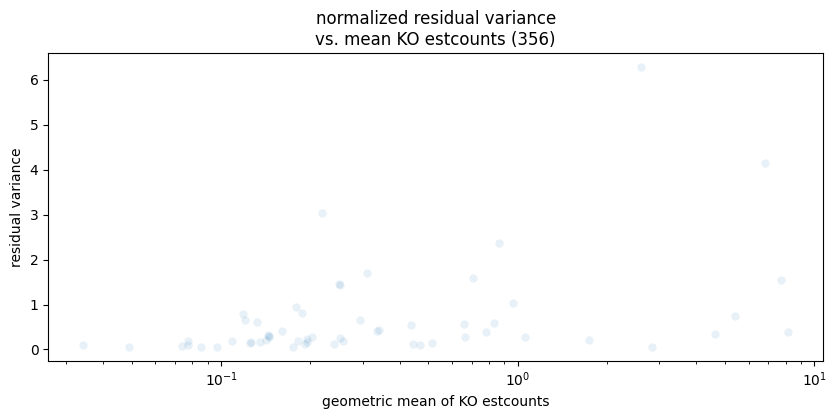

Normalizing slab 2 of 166: 31989 (52 samples, 49 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 49

R[write to console]: Total overdispersed genes: 49

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 49 by 52

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 49 genes, 52 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 49 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5233641 secs



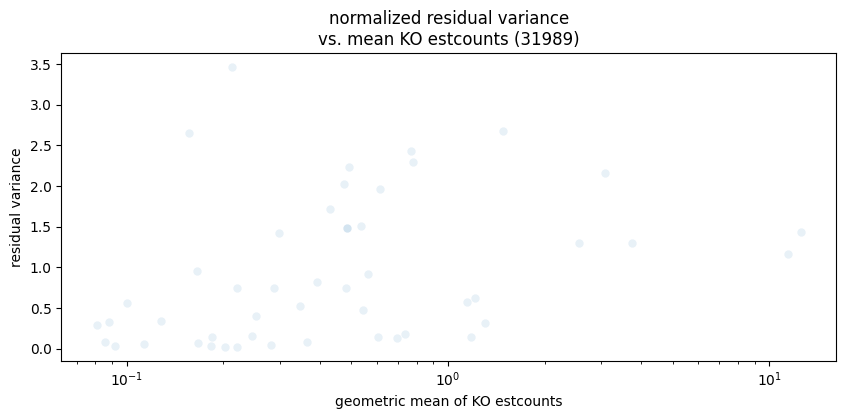

Normalizing slab 3 of 166: 2854170 (44 samples, 44 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 44

R[write to console]: Total overdispersed genes: 44

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 44 by 44

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 44 genes, 44 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 44 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.518522 secs



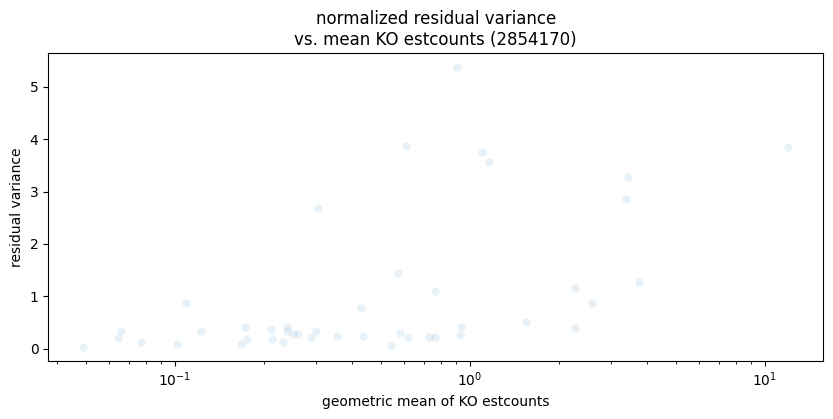

Normalizing slab 4 of 166: 204455 (53 samples, 111 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 111

R[write to console]: Total overdispersed genes: 110

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 111 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 110 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 111 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5561118 secs



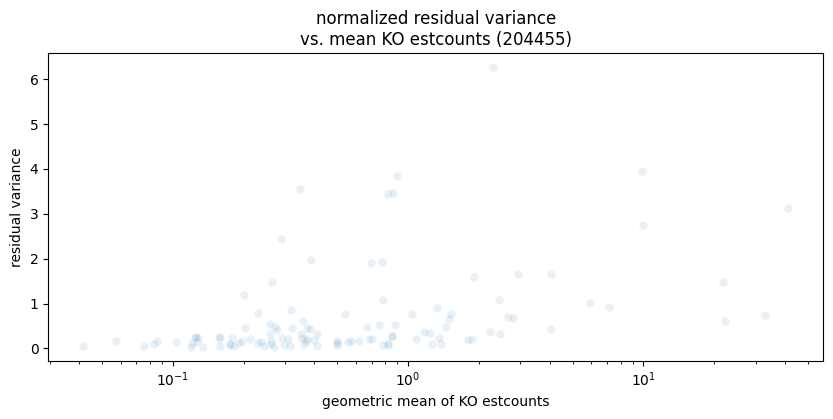

Normalizing slab 5 of 166: 28211 (53 samples, 136 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 136

R[write to console]: Total overdispersed genes: 135

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 136 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 135 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Found 1 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1

R[write to console]: Second step: Get residuals using fitted parameters for 136 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5660102 secs



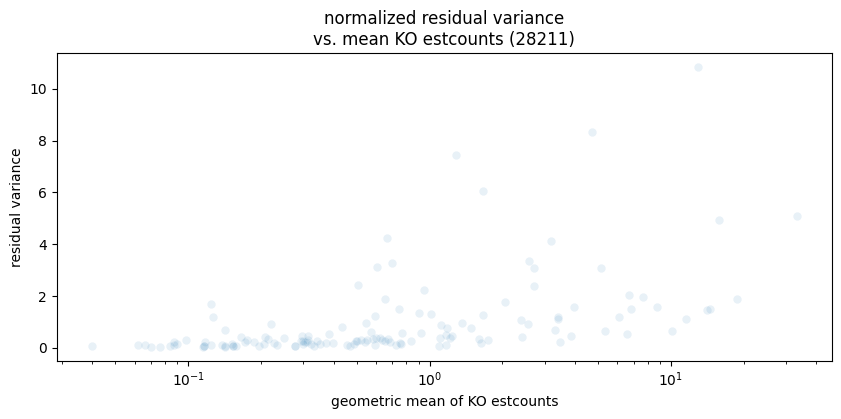

Normalizing slab 6 of 166: 304208 (43 samples, 45 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 45

R[write to console]: Total overdispersed genes: 45

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 45 by 43

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 45 genes, 43 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Found 1 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 45 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5225067 secs



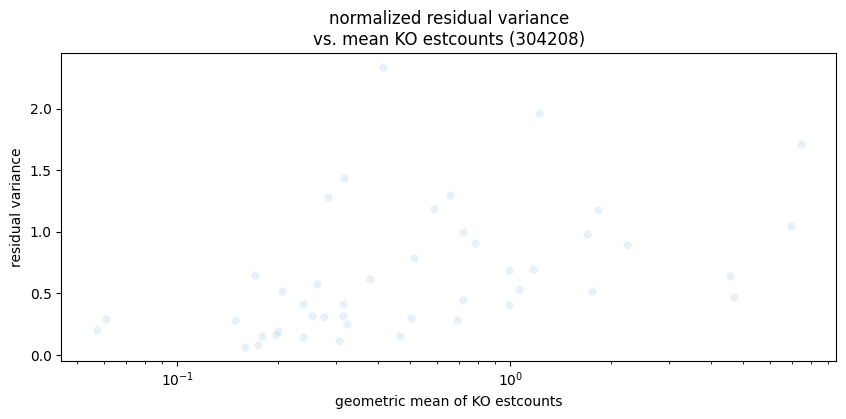

Normalizing slab 7 of 166: 53246 (53 samples, 50 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 50

R[write to console]: Total overdispersed genes: 50

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 50 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 50 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.37392919250625

R[write to console]: Second step: Get residuals using fitted parameters for 50 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5214453 secs



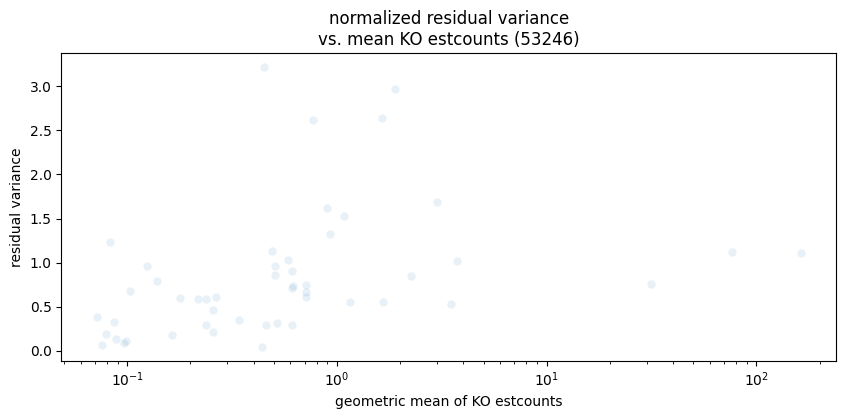

Normalizing slab 8 of 166: 226 (53 samples, 73 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 73

R[write to console]: Total overdispersed genes: 73

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 73 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 73 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.605243544676

R[write to console]: Second step: Get residuals using fitted parameters for 73 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5317554 secs



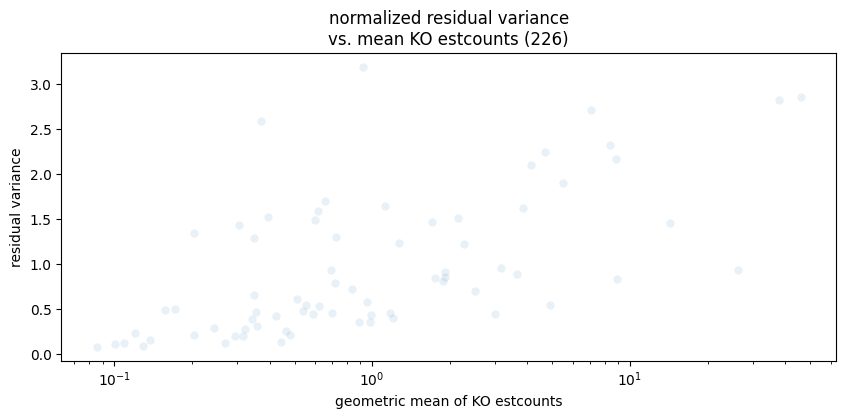

Normalizing slab 9 of 166: 28228 (46 samples, 34 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 34

R[write to console]: Total overdispersed genes: 34

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 34 by 46

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 34 genes, 46 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.218750773264

R[write to console]: Second step: Get residuals using fitted parameters for 34 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5168283 secs



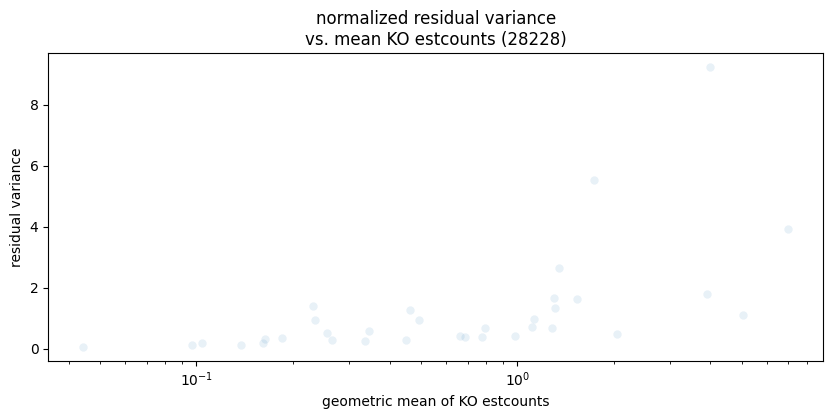

Normalizing slab 10 of 166: 22 (53 samples, 69 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 69

R[write to console]: Total overdispersed genes: 68

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 69 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 68 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 69 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5286427 secs



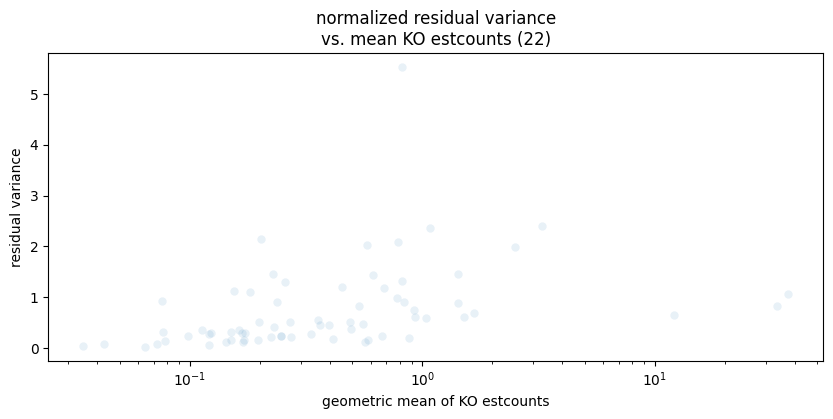

Normalizing slab 11 of 166: 58050 (43 samples, 32 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 32

R[write to console]: Total overdispersed genes: 32

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 32 by 43

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 32 genes, 43 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.239498656996

R[write to console]: Second step: Get residuals using fitted parameters for 32 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5224025 secs



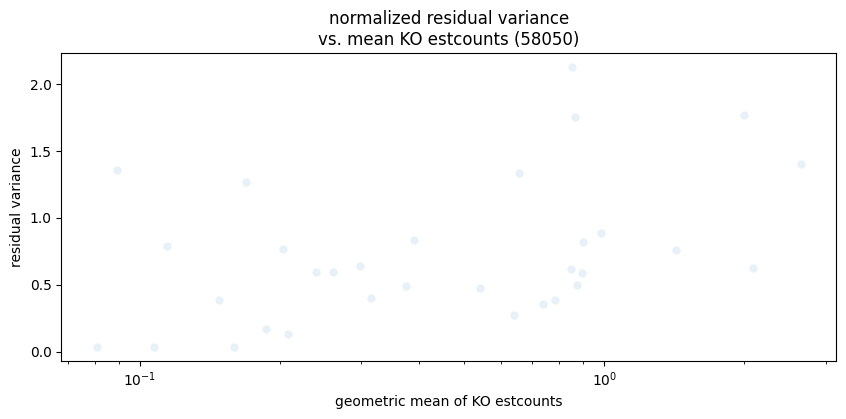

Normalizing slab 12 of 166: 135622 (53 samples, 86 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 86

R[write to console]: Total overdispersed genes: 85

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 86 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 85 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 86 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5331733 secs



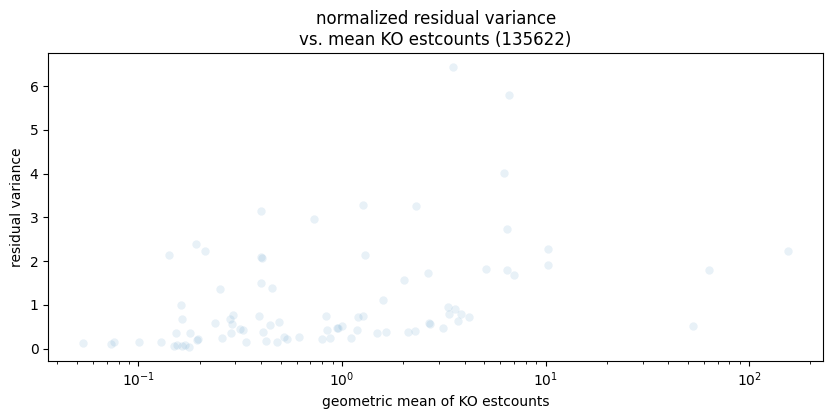

Normalizing slab 13 of 166: 1706372 (53 samples, 43 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 43

R[write to console]: Total overdispersed genes: 42

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 43 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 42 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.640075202209

R[write to console]: Second step: Get residuals using fitted parameters for 43 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5195699 secs



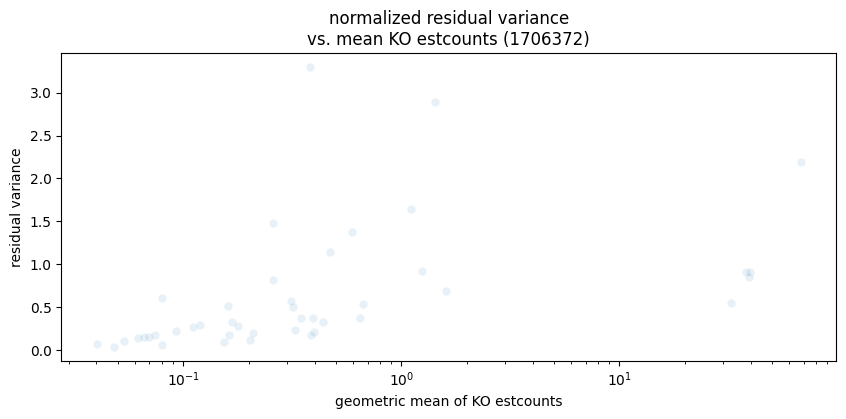

Normalizing slab 14 of 166: 1706432 (53 samples, 32 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 32

R[write to console]: Total overdispersed genes: 32

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 32 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 32 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1.243865092369

R[write to console]: Second step: Get residuals using fitted parameters for 32 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.518271 secs



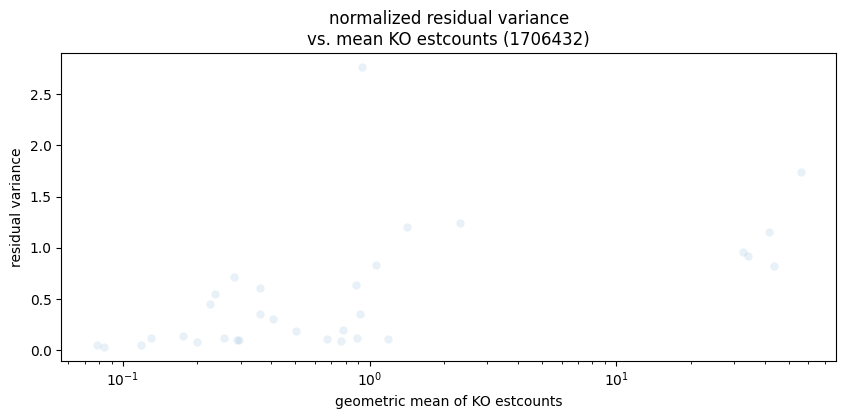

Normalizing slab 15 of 166: 1706369 (53 samples, 43 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 43

R[write to console]: Total overdispersed genes: 43

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 43 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 43 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 43 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5211821 secs



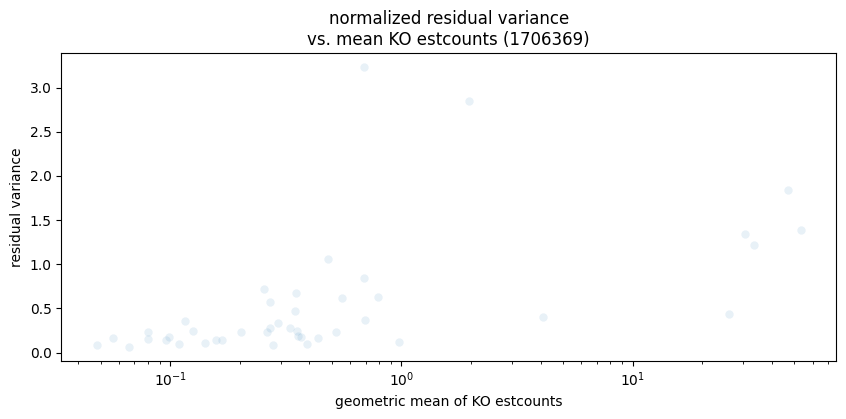

Normalizing slab 16 of 166: 662 (53 samples, 81 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 81

R[write to console]: Total overdispersed genes: 81

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 81 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 81 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 81 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5369875 secs



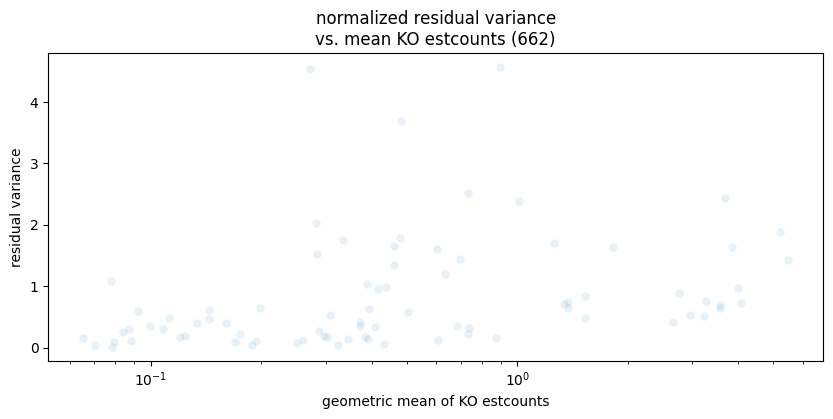

Normalizing slab 17 of 166: 135623 (53 samples, 146 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 146

R[write to console]: Total overdispersed genes: 143

R[write to console]: Excluding 3 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 146 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 143 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  3 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 3

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 3

R[write to console]: Calling offset model for all 3 poisson genes

R[write to console]: Found 3 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 3 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 146 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5622416 secs



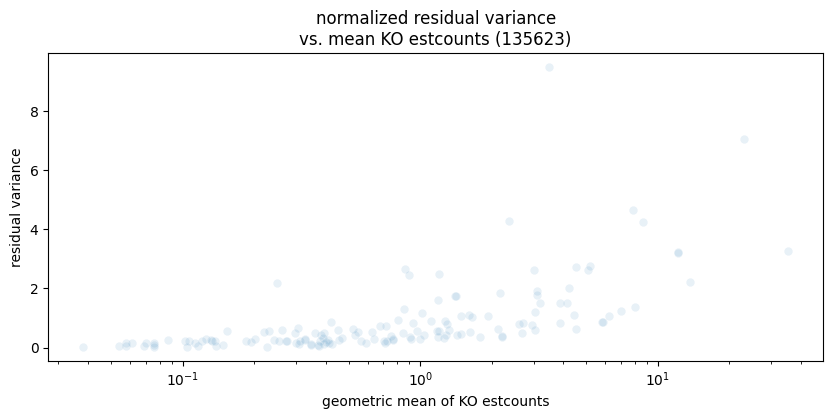

Normalizing slab 18 of 166: 939696 (53 samples, 61 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 61

R[write to console]: Total overdispersed genes: 61

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 61 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 61 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1.185435355729

R[write to console]: Second step: Get residuals using fitted parameters for 61 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.527673 secs



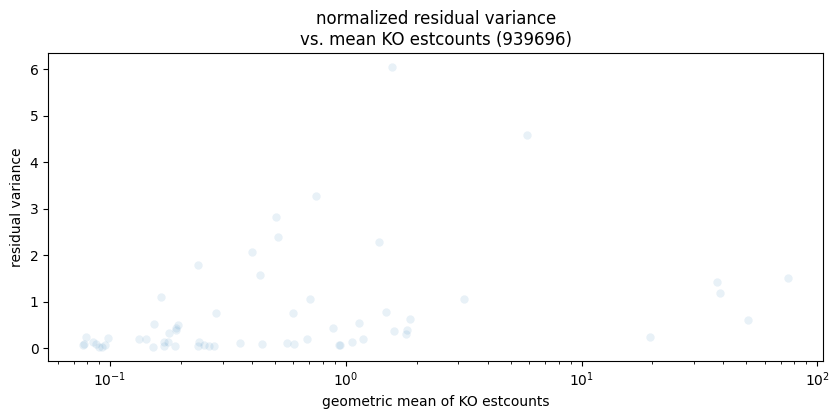

Normalizing slab 19 of 166: 751994 (47 samples, 32 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 32

R[write to console]: Total overdispersed genes: 32

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 32 by 47

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 32 genes, 47 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.435202770601

R[write to console]: Second step: Get residuals using fitted parameters for 32 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5172658 secs



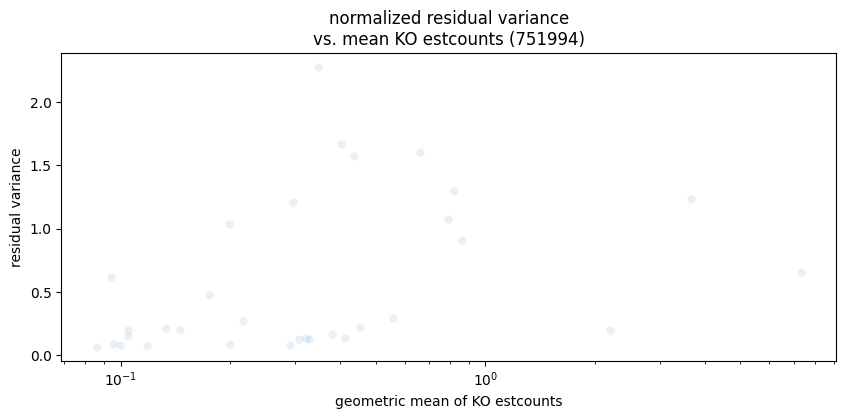

Normalizing slab 20 of 166: 33811 (48 samples, 34 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 34

R[write to console]: Total overdispersed genes: 34

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 34 by 48

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 34 genes, 48 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.457023321225

R[write to console]: Second step: Get residuals using fitted parameters for 34 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5173879 secs



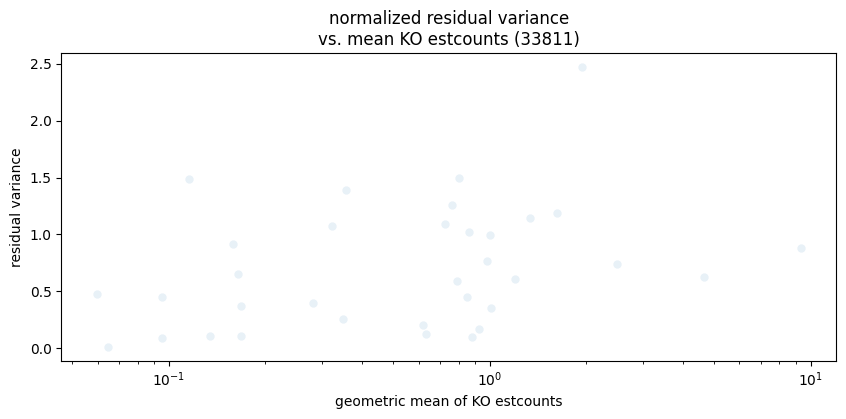

Normalizing slab 21 of 166: 698738 (42 samples, 39 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 39

R[write to console]: Total overdispersed genes: 39

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 39 by 42

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 39 genes, 42 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 39 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5169411 secs



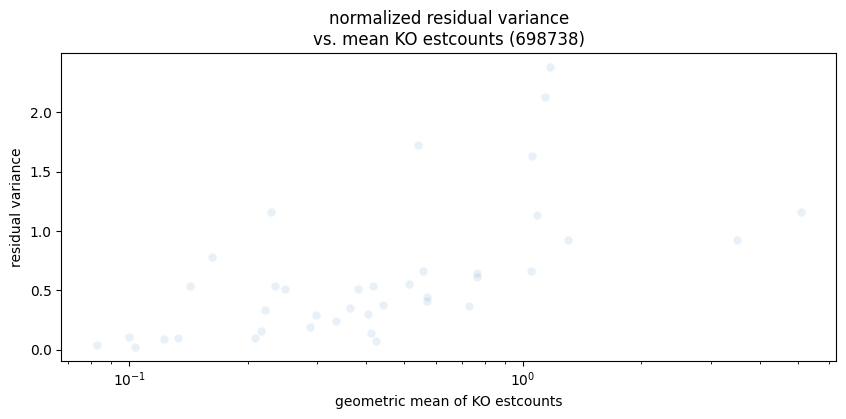

Normalizing slab 22 of 166: 135619 (53 samples, 46 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 46

R[write to console]: Total overdispersed genes: 46

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 46 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 46 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.927750387204

R[write to console]: Second step: Get residuals using fitted parameters for 46 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5203352 secs



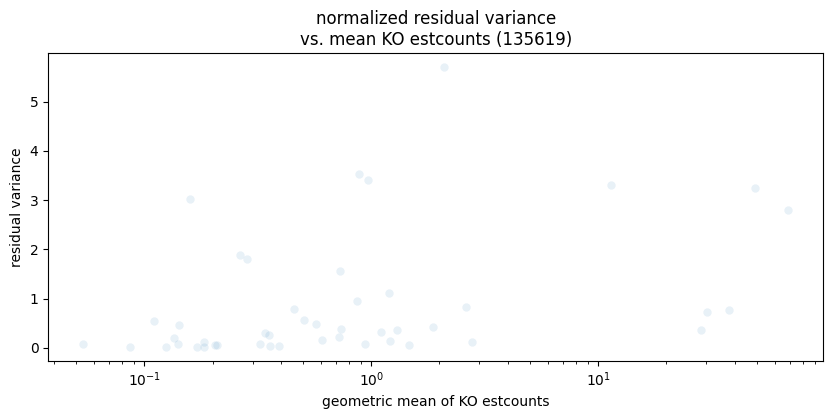

Normalizing slab 23 of 166: 1548547 (52 samples, 46 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 46

R[write to console]: Total overdispersed genes: 45

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 46 by 52

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 45 genes, 52 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 46 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5209358 secs



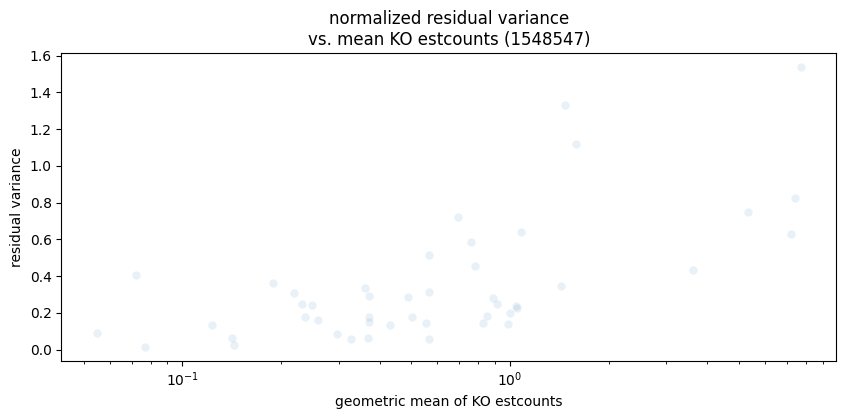

Normalizing slab 24 of 166: 1236 (53 samples, 201 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 200

R[write to console]: Total overdispersed genes: 198

R[write to console]: Excluding 2 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 200 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 198 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 2

R[write to console]: Calling offset model for all 2 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 2 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.986760116164

R[write to console]: Second step: Get residuals using fitted parameters for 200 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5838585 secs



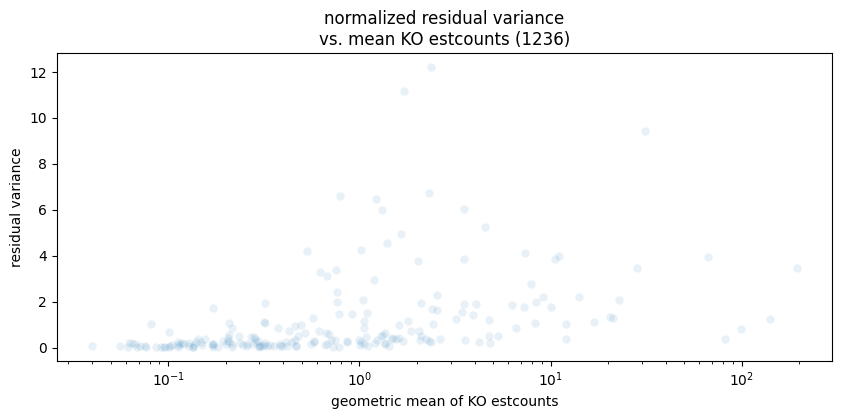

Normalizing slab 25 of 166: 383631 (49 samples, 54 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 54

R[write to console]: Total overdispersed genes: 50

R[write to console]: Excluding 4 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 54 by 49

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 50 genes, 49 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 4

R[write to console]: Calling offset model for all 4 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 4 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 54 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5248783 secs



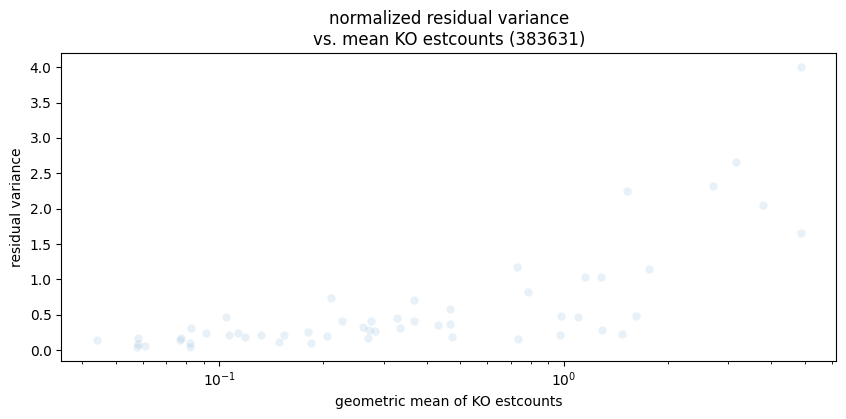

Normalizing slab 26 of 166: 32003 (45 samples, 66 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 66

R[write to console]: Total overdispersed genes: 65

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 66 by 45

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 65 genes, 45 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1

R[write to console]: Second step: Get residuals using fitted parameters for 66 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5280144 secs



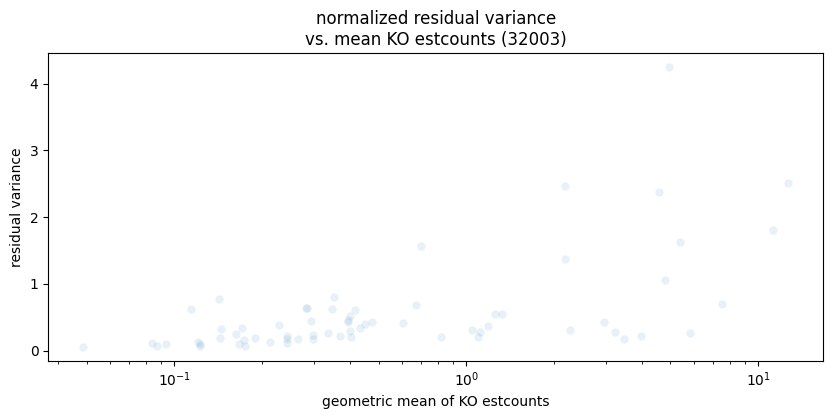

Normalizing slab 27 of 166: 28216 (53 samples, 62 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 62

R[write to console]: Total overdispersed genes: 62

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 62 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 62 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Found 1 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.16

R[write to console]: Second step: Get residuals using fitted parameters for 62 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5307362 secs



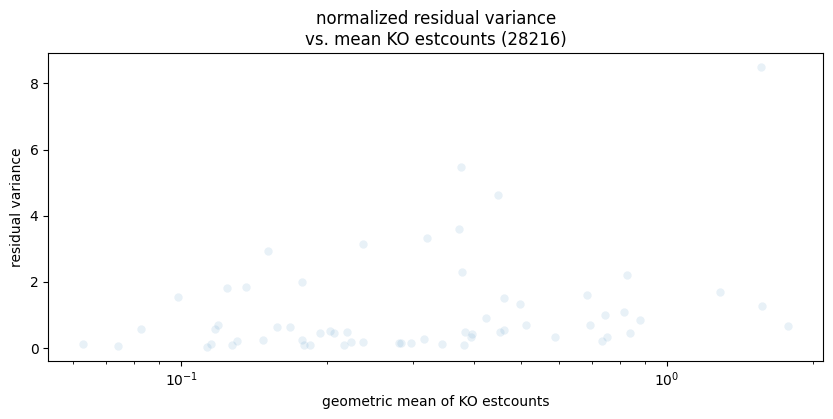

Normalizing slab 28 of 166: 1224 (53 samples, 191 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 191

R[write to console]: Total overdispersed genes: 190

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 191 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 190 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.74200461932961

R[write to console]: Second step: Get residuals using fitted parameters for 191 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5824459 secs



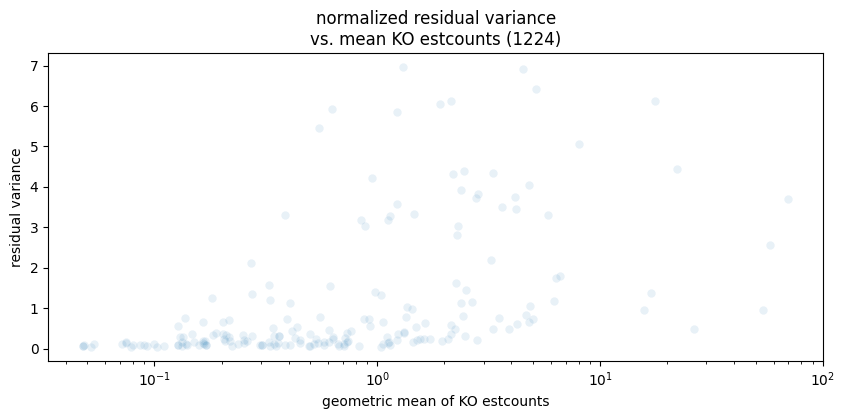

Normalizing slab 29 of 166: 104270 (49 samples, 46 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 46

R[write to console]: Total overdispersed genes: 46

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 46 by 49

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 46 genes, 49 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  2 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 2

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Found 2 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.796393823281

R[write to console]: Second step: Get residuals using fitted parameters for 46 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.522289 secs



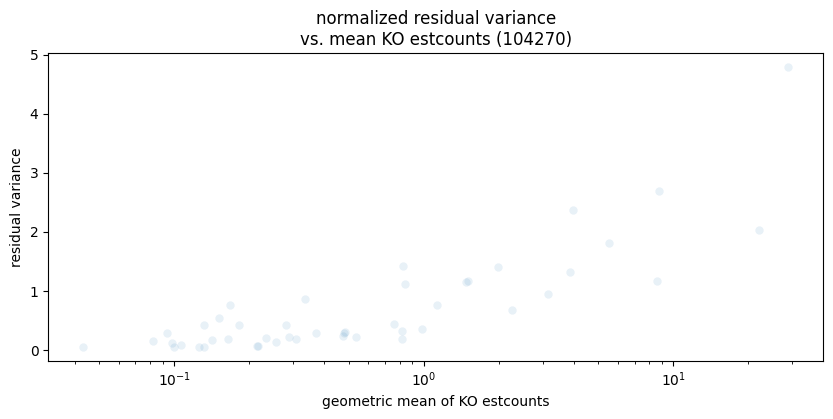

Normalizing slab 30 of 166: 104267 (53 samples, 46 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 46

R[write to console]: Total overdispersed genes: 46

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 46 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 46 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.822835852609

R[write to console]: Second step: Get residuals using fitted parameters for 46 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5184035 secs



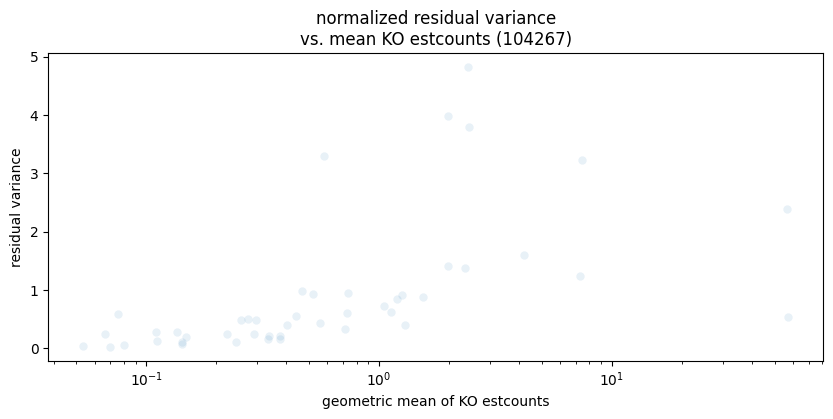

Normalizing slab 31 of 166: 1336795 (53 samples, 32 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 32

R[write to console]: Total overdispersed genes: 32

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 32 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 32 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1.92291042880429

R[write to console]: Second step: Get residuals using fitted parameters for 32 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5198436 secs



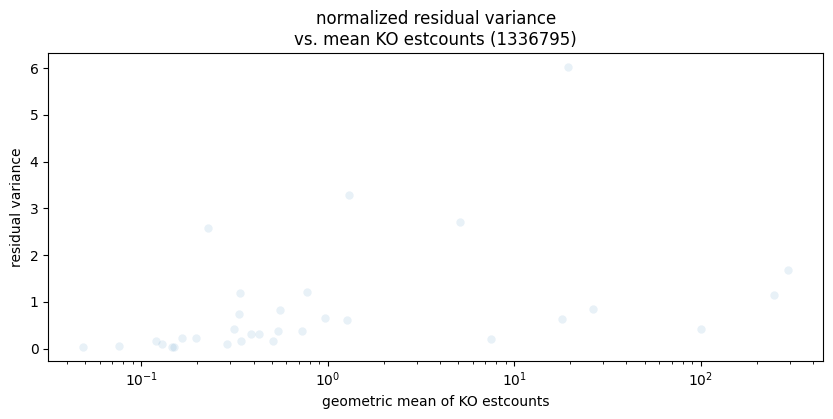

Normalizing slab 32 of 166: 2644710 (53 samples, 36 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 36

R[write to console]: Total overdispersed genes: 36

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 36 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 36 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.81685444

R[write to console]: Second step: Get residuals using fitted parameters for 36 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5154405 secs



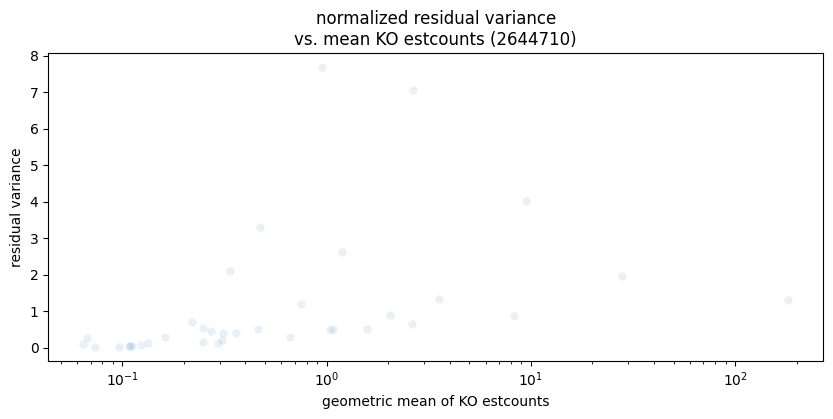

Normalizing slab 33 of 166: 49546 (53 samples, 129 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 129

R[write to console]: Total overdispersed genes: 127

R[write to console]: Excluding 2 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 129 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 127 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 2

R[write to console]: Calling offset model for all 2 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 2 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.861540388864

R[write to console]: Second step: Get residuals using fitted parameters for 129 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5594864 secs



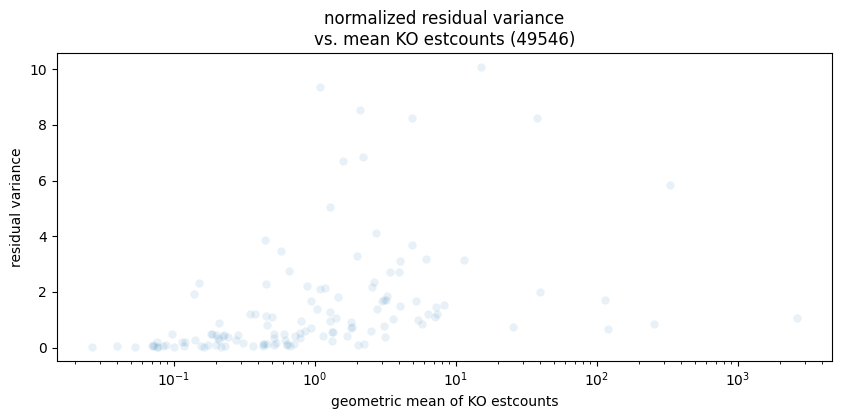

Normalizing slab 34 of 166: 191579 (53 samples, 43 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 43

R[write to console]: Total overdispersed genes: 43

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 43 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 43 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.571138413169

R[write to console]: Second step: Get residuals using fitted parameters for 43 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.521488 secs



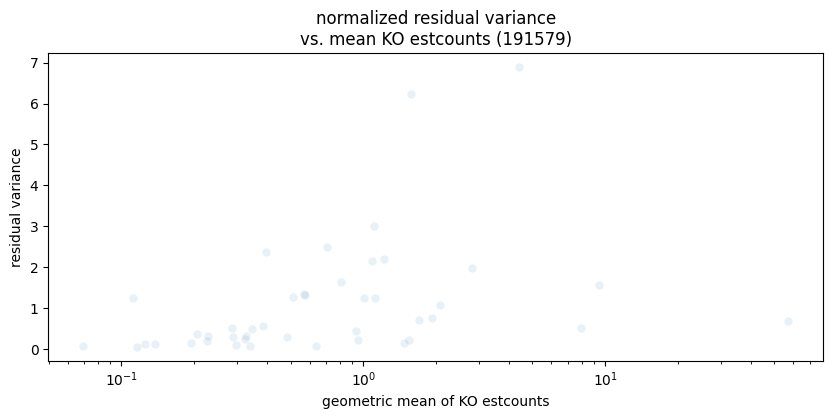

Normalizing slab 35 of 166: 1853230 (53 samples, 49 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 49

R[write to console]: Total overdispersed genes: 48

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 49 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 48 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 49 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5867457 secs



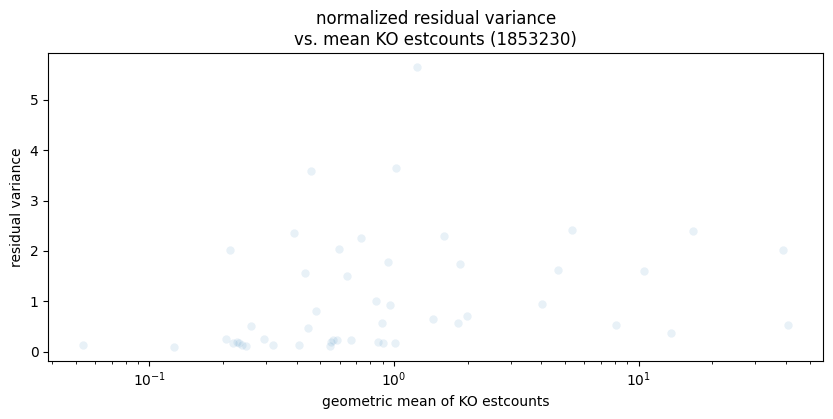

Normalizing slab 36 of 166: 200644 (53 samples, 106 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 106

R[write to console]: Total overdispersed genes: 105

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 106 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 105 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.76509274253764

R[write to console]: Second step: Get residuals using fitted parameters for 106 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5485778 secs



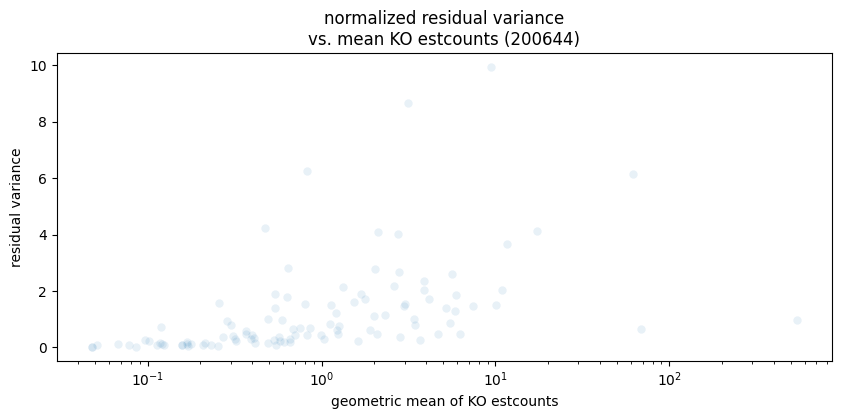

Normalizing slab 37 of 166: 487796 (53 samples, 59 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 59

R[write to console]: Total overdispersed genes: 58

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 59 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 58 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1.44

R[write to console]: Second step: Get residuals using fitted parameters for 59 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5251629 secs



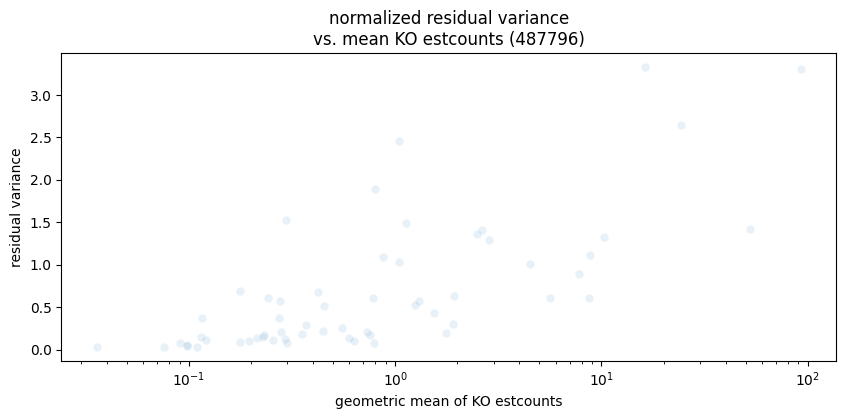

Normalizing slab 38 of 166: 117743 (53 samples, 99 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 99

R[write to console]: Total overdispersed genes: 99

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 99 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 99 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  2.0898171844

R[write to console]: Second step: Get residuals using fitted parameters for 99 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5368338 secs



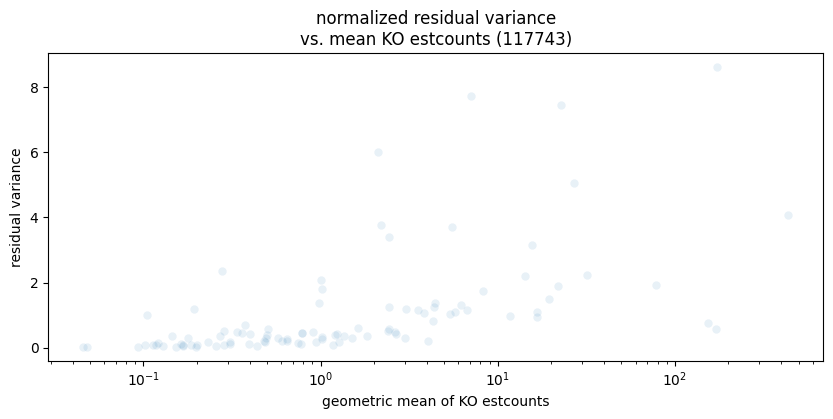

Normalizing slab 39 of 166: 313606 (50 samples, 35 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 35

R[write to console]: Total overdispersed genes: 35

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 35 by 50

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 35 genes, 50 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 35 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.571295 secs



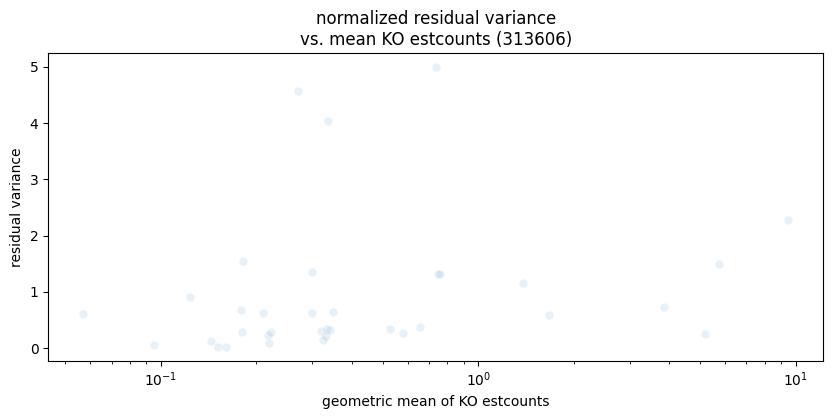

Normalizing slab 40 of 166: 768507 (53 samples, 63 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 63

R[write to console]: Total overdispersed genes: 63

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 63 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 63 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 63 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.52386 secs



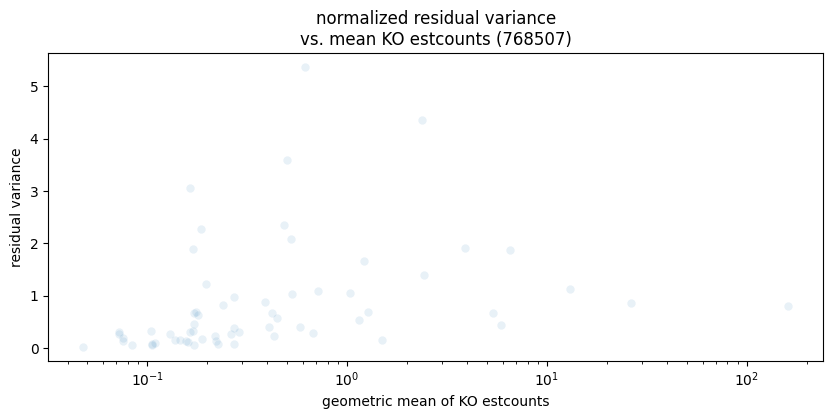

Normalizing slab 41 of 166: 1313421 (53 samples, 77 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 77

R[write to console]: Total overdispersed genes: 76

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 77 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 76 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 77 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5296896 secs



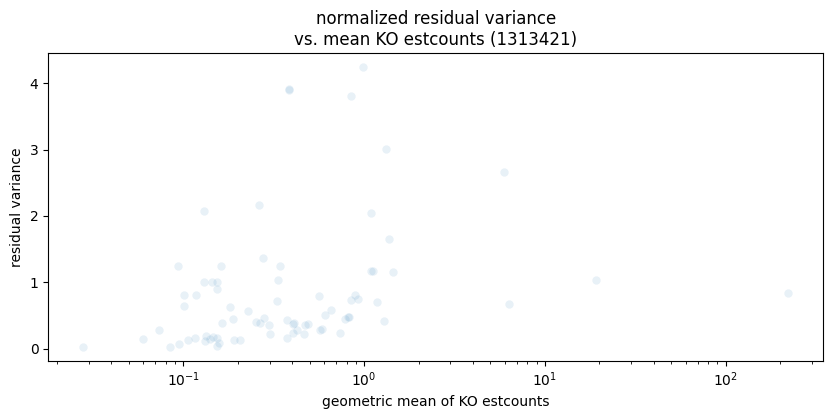

Normalizing slab 42 of 166: 70995 (53 samples, 38 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 38

R[write to console]: Total overdispersed genes: 38

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 38 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 38 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 38 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5173466 secs



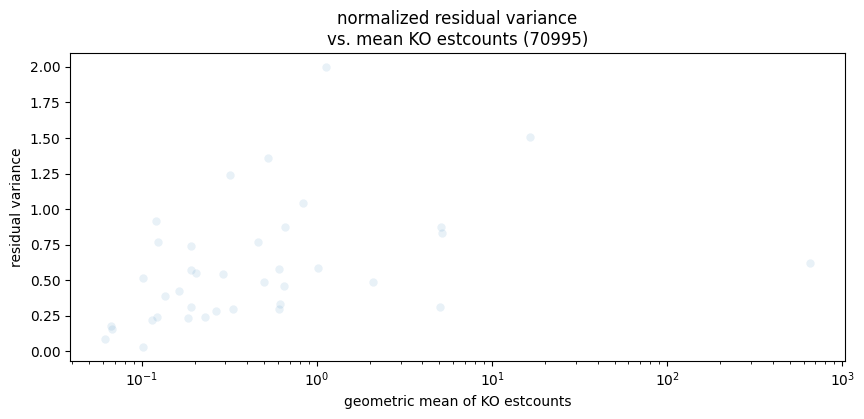

Normalizing slab 43 of 166: 1936988 (53 samples, 87 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 87

R[write to console]: Total overdispersed genes: 87

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 87 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 87 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.665718919056

R[write to console]: Second step: Get residuals using fitted parameters for 87 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5304413 secs



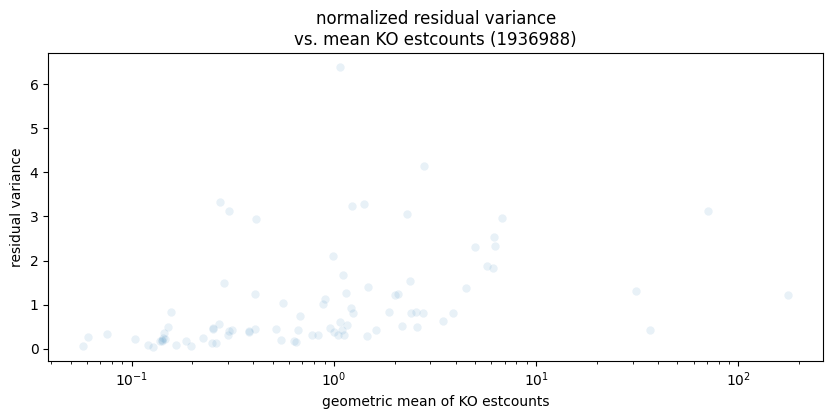

Normalizing slab 44 of 166: 976 (53 samples, 194 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 194

R[write to console]: Total overdispersed genes: 194

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 194 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 194 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1.44

R[write to console]: Second step: Get residuals using fitted parameters for 194 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.6130164 secs



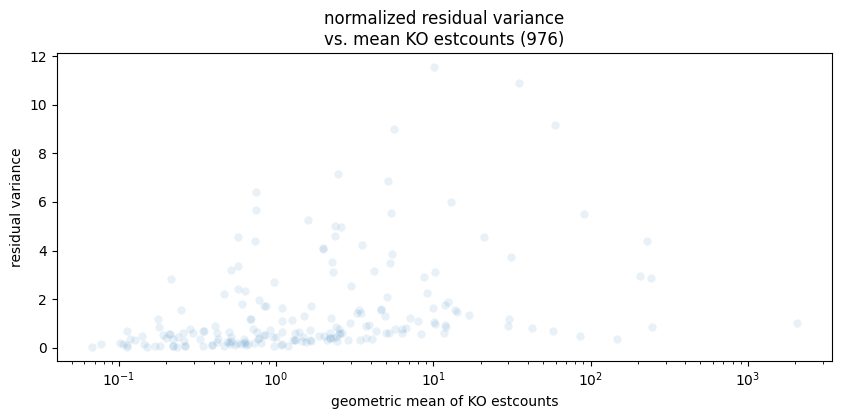

Normalizing slab 45 of 166: 68336 (53 samples, 53 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 53

R[write to console]: Total overdispersed genes: 52

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 53 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 52 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 53 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.523438 secs



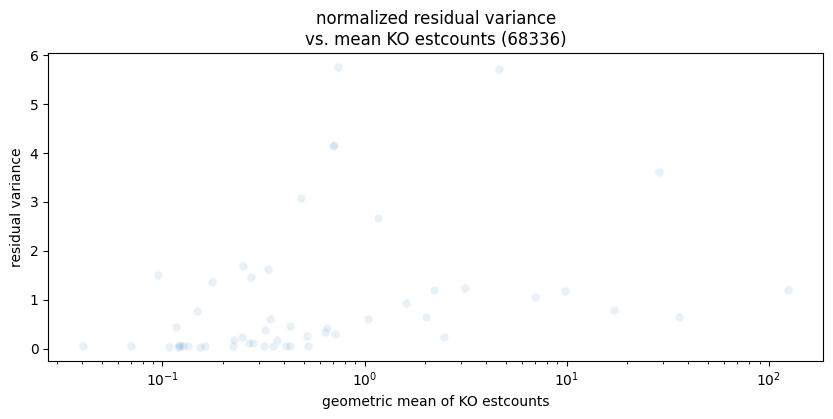

Normalizing slab 46 of 166: 939857 (47 samples, 44 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 43

R[write to console]: Total overdispersed genes: 43

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 43 by 47

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 43 genes, 47 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Found 1 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1

R[write to console]: Second step: Get residuals using fitted parameters for 43 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.522537 secs



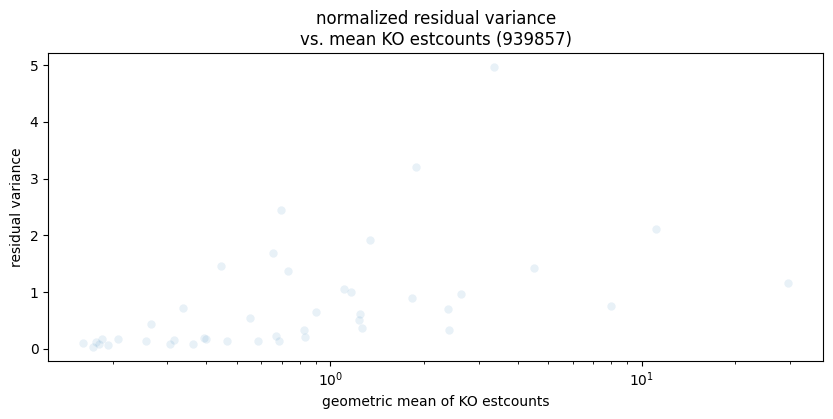

Normalizing slab 47 of 166: 1007123 (51 samples, 53 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 53

R[write to console]: Total overdispersed genes: 53

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 53 by 51

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 53 genes, 51 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  2.027924098704

R[write to console]: Second step: Get residuals using fitted parameters for 53 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5126512 secs



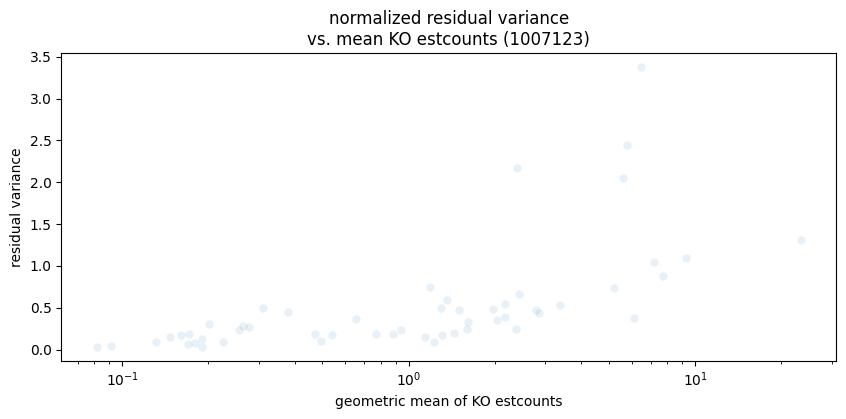

Normalizing slab 48 of 166: 62680 (52 samples, 45 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 45

R[write to console]: Total overdispersed genes: 45

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 45 by 52

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 45 genes, 52 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  2.632308308721

R[write to console]: Second step: Get residuals using fitted parameters for 45 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5216634 secs



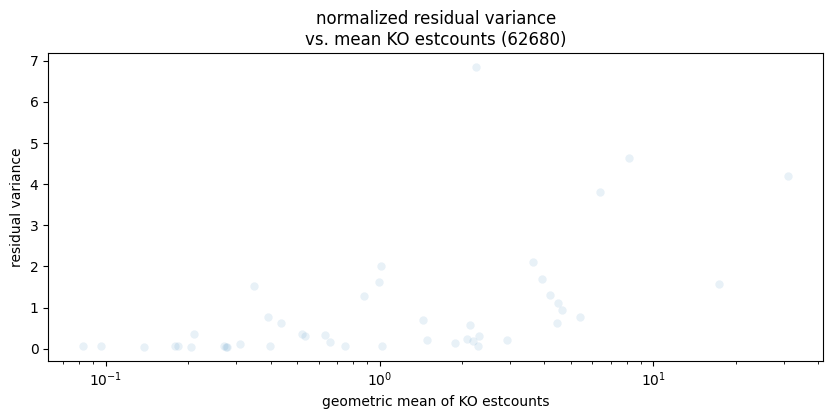

Normalizing slab 49 of 166: 203683 (50 samples, 39 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 39

R[write to console]: Total overdispersed genes: 38

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 39 by 50

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 38 genes, 50 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.309040375396

R[write to console]: Second step: Get residuals using fitted parameters for 39 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5194502 secs



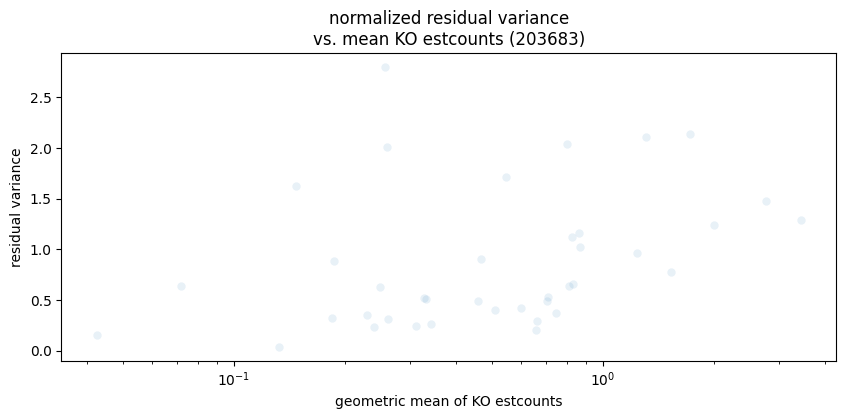

Normalizing slab 50 of 166: 48461 (51 samples, 36 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 36

R[write to console]: Total overdispersed genes: 35

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 36 by 51

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 35 genes, 51 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.16

R[write to console]: Second step: Get residuals using fitted parameters for 36 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5154152 secs



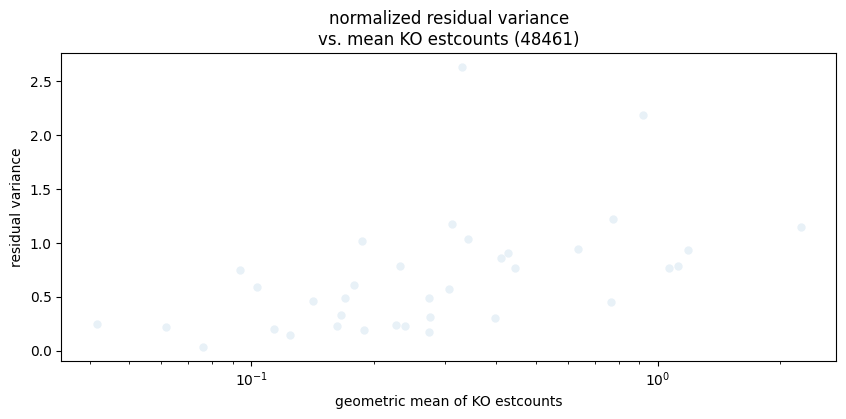

Normalizing slab 51 of 166: 939909 (43 samples, 32 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 32

R[write to console]: Total overdispersed genes: 32

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 32 by 43

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 32 genes, 43 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 32 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5186417 secs



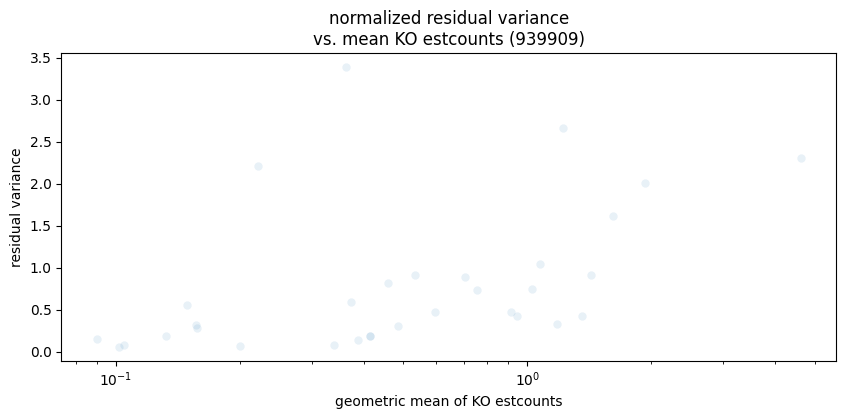

Normalizing slab 52 of 166: 395922 (53 samples, 42 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 42

R[write to console]: Total overdispersed genes: 42

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 42 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 42 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.16

R[write to console]: Second step: Get residuals using fitted parameters for 42 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5208933 secs



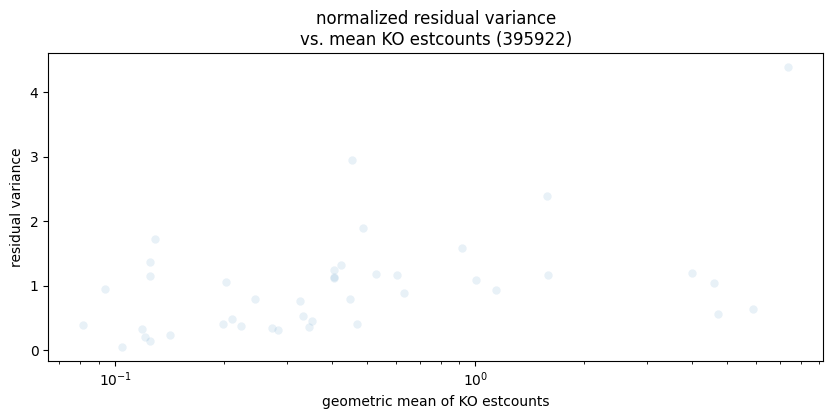

Normalizing slab 53 of 166: 74201 (52 samples, 57 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 57

R[write to console]: Total overdispersed genes: 57

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 57 by 52

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 57 genes, 52 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.30131140985856

R[write to console]: Second step: Get residuals using fitted parameters for 57 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5297005 secs



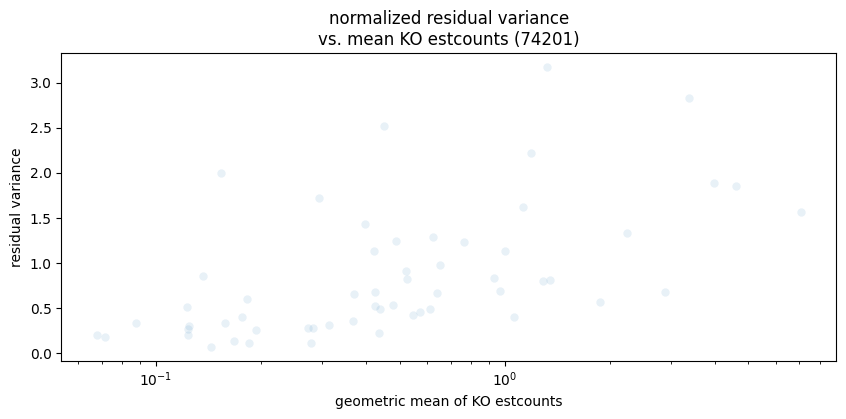

Normalizing slab 54 of 166: 3379134 (53 samples, 79 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 79

R[write to console]: Total overdispersed genes: 79

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 79 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 79 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.3601560169

R[write to console]: Second step: Get residuals using fitted parameters for 79 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5325215 secs



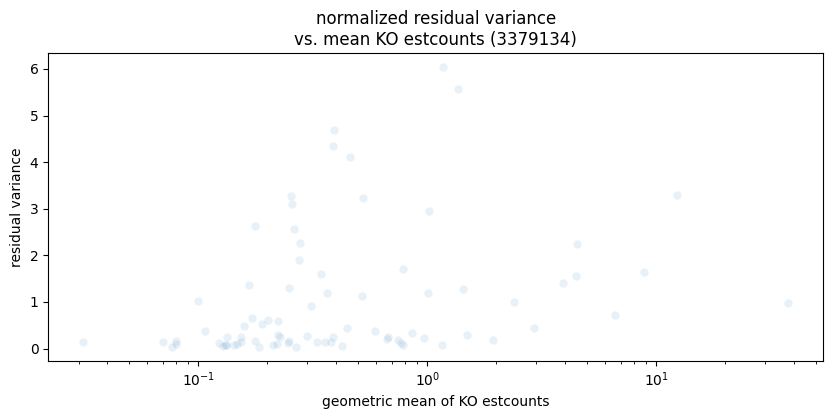

Normalizing slab 55 of 166: 1760 (50 samples, 36 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 36

R[write to console]: Total overdispersed genes: 36

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 36 by 50

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 36 genes, 50 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.165226803361

R[write to console]: Second step: Get residuals using fitted parameters for 36 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5175209 secs



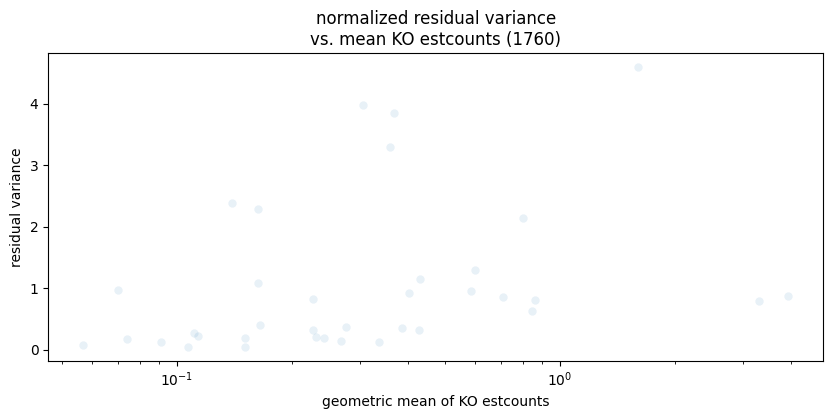

Normalizing slab 56 of 166: 200795 (53 samples, 41 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 41

R[write to console]: Total overdispersed genes: 41

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 41 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 41 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.16

R[write to console]: Second step: Get residuals using fitted parameters for 41 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5219526 secs



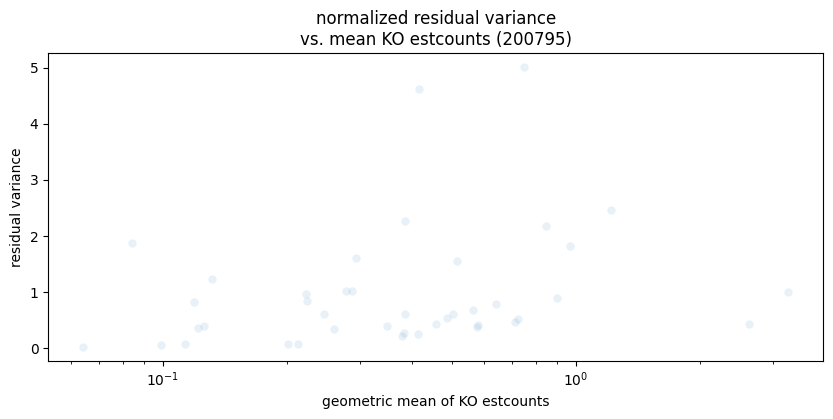

Normalizing slab 57 of 166: 1301283 (47 samples, 51 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 51

R[write to console]: Total overdispersed genes: 51

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 51 by 47

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 51 genes, 47 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  2 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 2

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Found 2 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 51 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5243783 secs



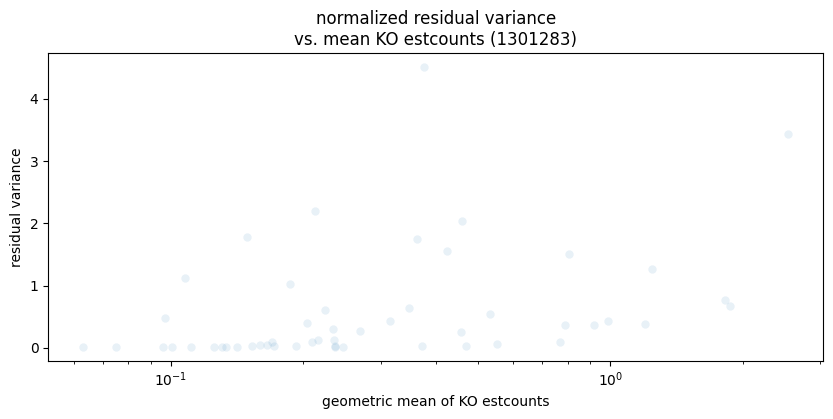

Normalizing slab 58 of 166: 3028117 (52 samples, 38 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 38

R[write to console]: Total overdispersed genes: 38

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 38 by 52

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 38 genes, 52 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 38 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5178523 secs



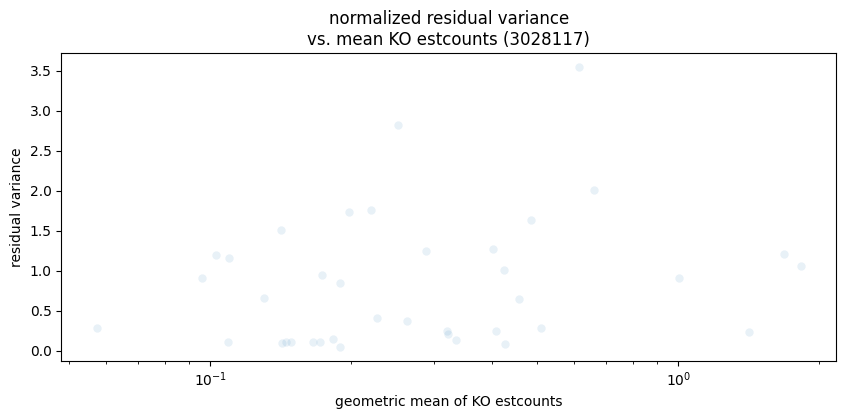

Normalizing slab 59 of 166: 1783272 (53 samples, 81 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 81

R[write to console]: Total overdispersed genes: 81

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 81 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 81 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.2824284736

R[write to console]: Second step: Get residuals using fitted parameters for 81 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5302815 secs



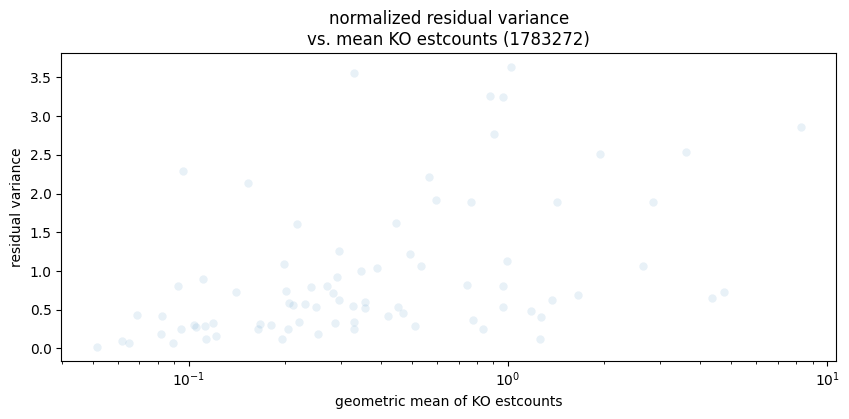

Normalizing slab 60 of 166: 2 (53 samples, 237 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 236

R[write to console]: Total overdispersed genes: 235

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 236 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 235 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.940622600449

R[write to console]: Second step: Get residuals using fitted parameters for 236 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.6022232 secs



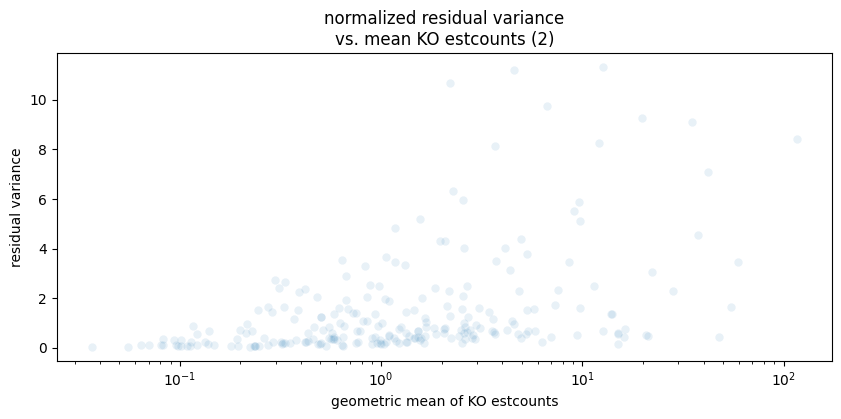

Normalizing slab 61 of 166: 632150 (53 samples, 37 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 37

R[write to console]: Total overdispersed genes: 37

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 37 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 37 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 37 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5164585 secs



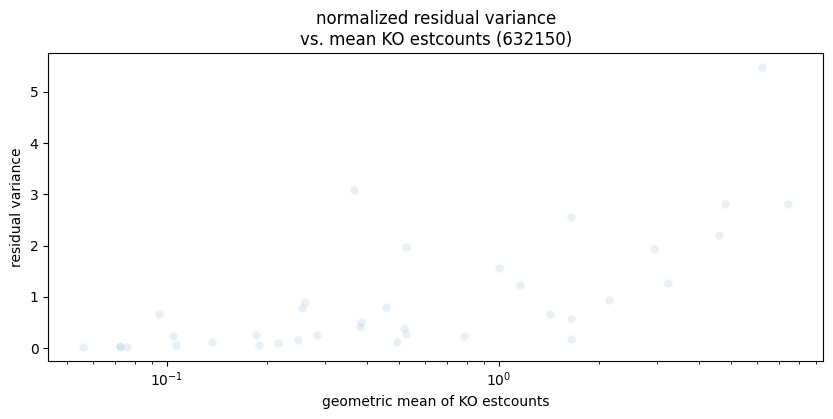

Normalizing slab 62 of 166: 2916 (53 samples, 97 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 97

R[write to console]: Total overdispersed genes: 97

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 97 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 97 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 97 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5401046 secs



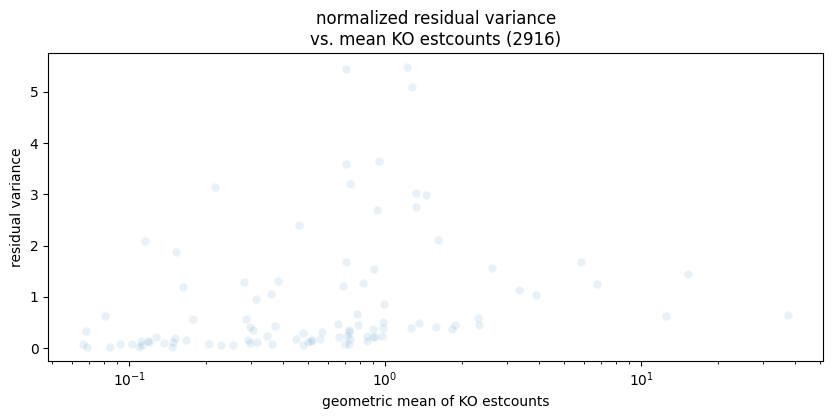

Normalizing slab 63 of 166: 40984 (53 samples, 79 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 79

R[write to console]: Total overdispersed genes: 79

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 79 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 79 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Found 1 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.367699129924

R[write to console]: Second step: Get residuals using fitted parameters for 79 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.533422 secs



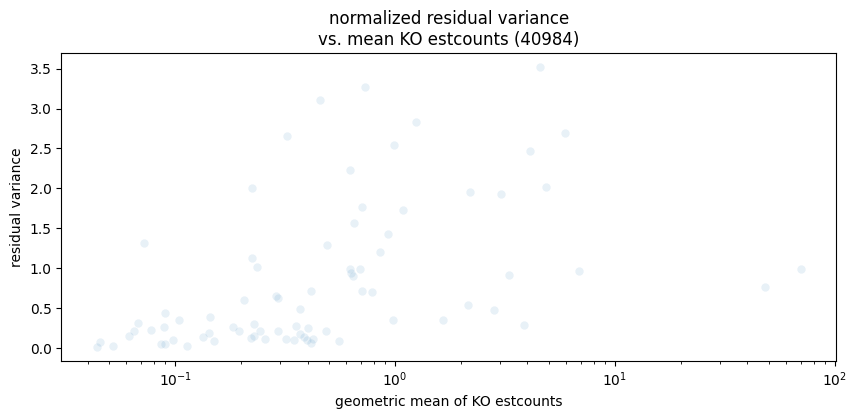

Normalizing slab 64 of 166: 2562237 (53 samples, 81 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 81

R[write to console]: Total overdispersed genes: 81

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 81 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 81 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1.105719547024

R[write to console]: Second step: Get residuals using fitted parameters for 81 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5321748 secs



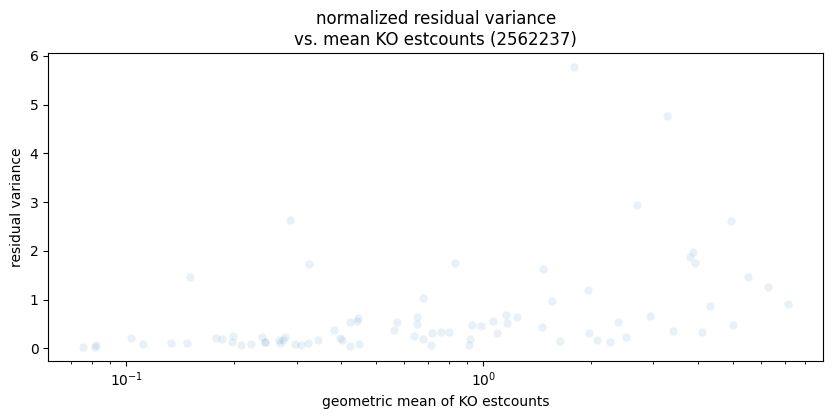

Normalizing slab 65 of 166: 252141 (53 samples, 35 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 35

R[write to console]: Total overdispersed genes: 35

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 35 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 35 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Found 1 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 35 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5201755 secs



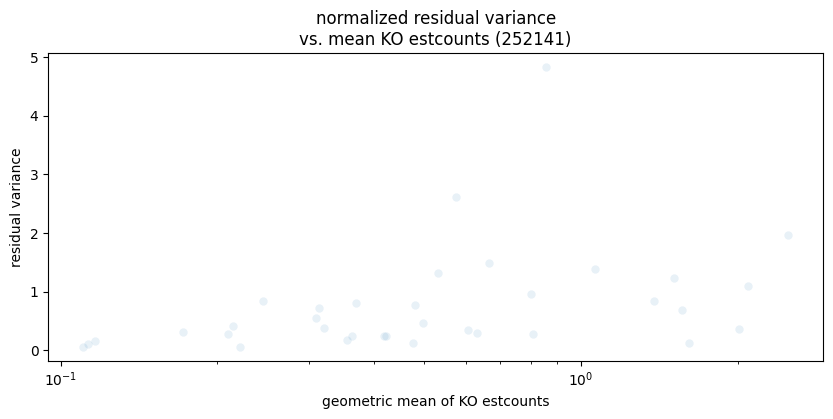

Normalizing slab 66 of 166: 43686 (50 samples, 43 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 43

R[write to console]: Total overdispersed genes: 43

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 43 by 50

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 43 genes, 50 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.507191806276

R[write to console]: Second step: Get residuals using fitted parameters for 43 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5199373 secs



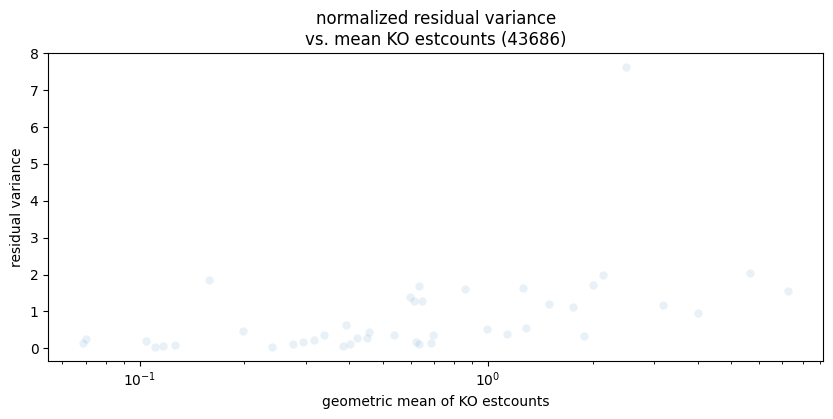

Normalizing slab 67 of 166: 89954 (52 samples, 53 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 53

R[write to console]: Total overdispersed genes: 53

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 53 by 52

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 53 genes, 52 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.304872935409

R[write to console]: Second step: Get residuals using fitted parameters for 53 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.527251 secs



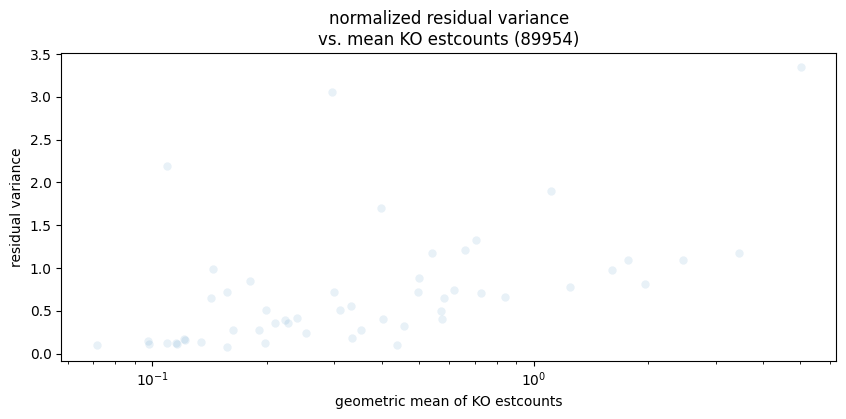

Normalizing slab 68 of 166: 156230 (53 samples, 60 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 60

R[write to console]: Total overdispersed genes: 60

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 60 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 60 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 60 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5274382 secs



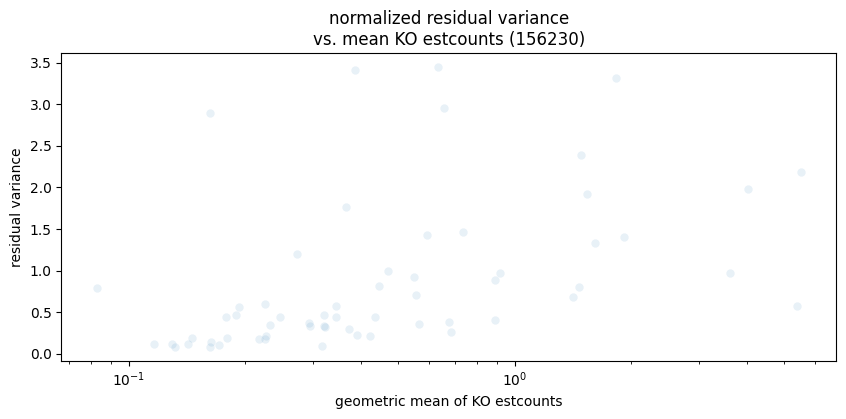

Normalizing slab 69 of 166: 407301 (53 samples, 161 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 161

R[write to console]: Total overdispersed genes: 161

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 161 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 161 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 161 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5838234 secs



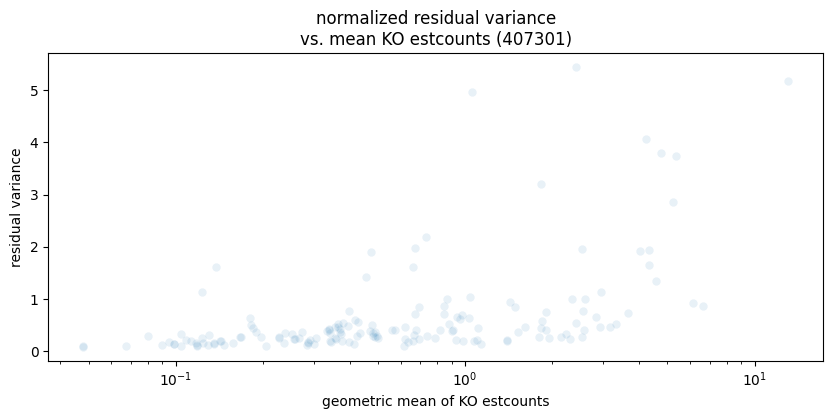

Normalizing slab 70 of 166: 1003176 (53 samples, 58 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 58

R[write to console]: Total overdispersed genes: 58

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 58 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 58 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 58 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5257297 secs



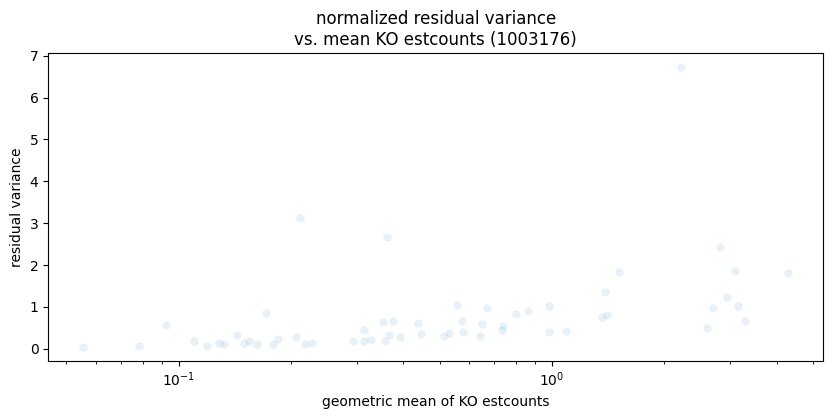

Normalizing slab 71 of 166: 66801 (51 samples, 32 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 32

R[write to console]: Total overdispersed genes: 32

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 32 by 51

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 32 genes, 51 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.16

R[write to console]: Second step: Get residuals using fitted parameters for 32 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.52195 secs



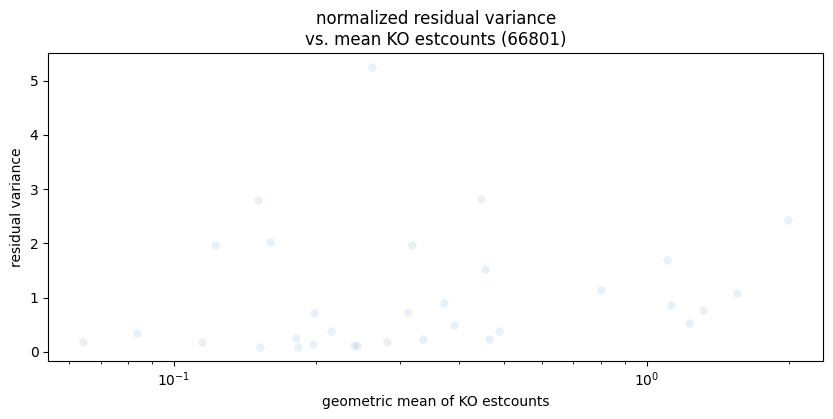

Normalizing slab 72 of 166: 71861 (47 samples, 31 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 31

R[write to console]: Total overdispersed genes: 31

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 31 by 47

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 31 genes, 47 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 31 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5158112 secs



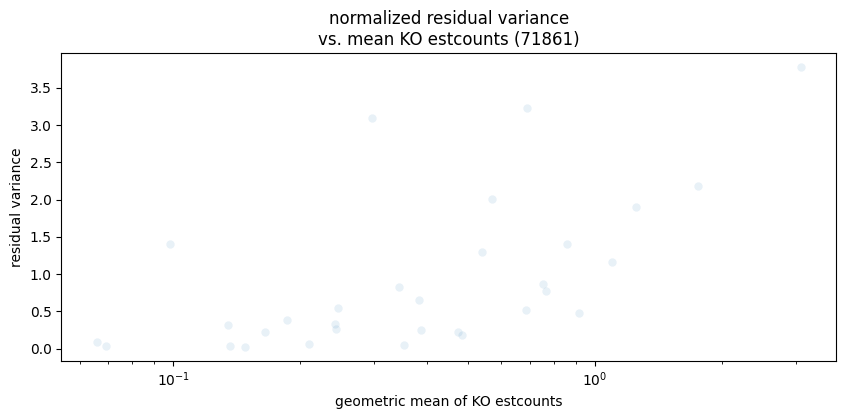

Normalizing slab 73 of 166: 2910 (52 samples, 35 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 35

R[write to console]: Total overdispersed genes: 35

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 35 by 52

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 35 genes, 52 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 35 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5753667 secs



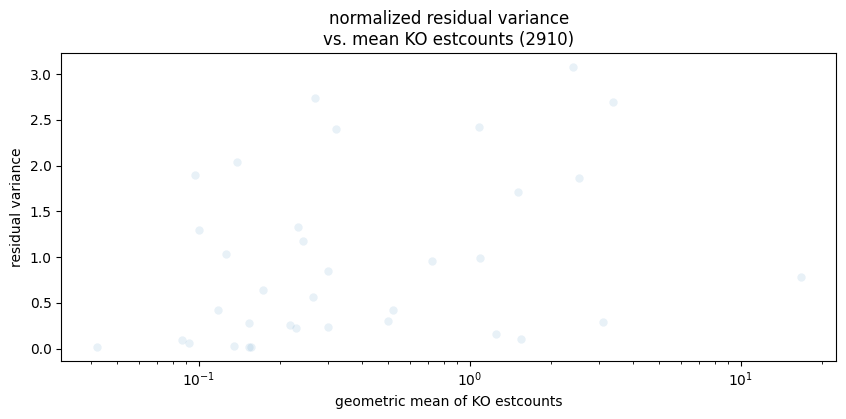

Normalizing slab 74 of 166: 39449 (52 samples, 56 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 56

R[write to console]: Total overdispersed genes: 56

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 56 by 52

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 56 genes, 52 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 56 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5249124 secs



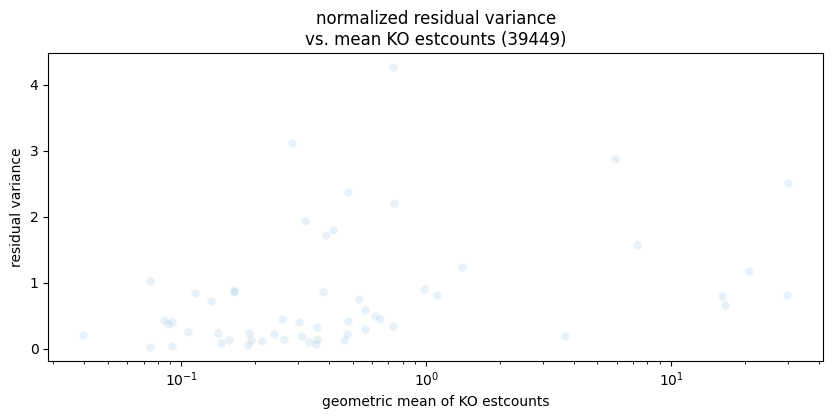

Normalizing slab 75 of 166: 2864 (53 samples, 218 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 217

R[write to console]: Total overdispersed genes: 217

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 217 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 217 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  2.04761532679081

R[write to console]: Second step: Get residuals using fitted parameters for 217 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5947795 secs



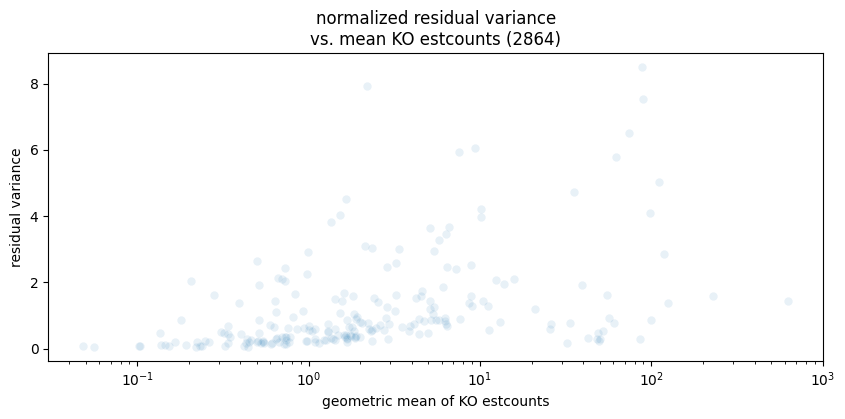

Normalizing slab 76 of 166: 1172189 (53 samples, 85 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 85

R[write to console]: Total overdispersed genes: 85

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 85 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 85 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 85 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5279615 secs



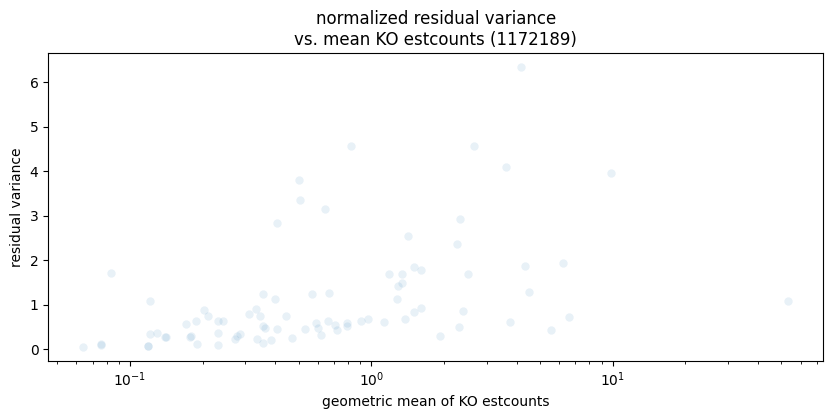

Normalizing slab 77 of 166: 431838 (53 samples, 44 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 44

R[write to console]: Total overdispersed genes: 44

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 44 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 44 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.16

R[write to console]: Second step: Get residuals using fitted parameters for 44 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5776274 secs



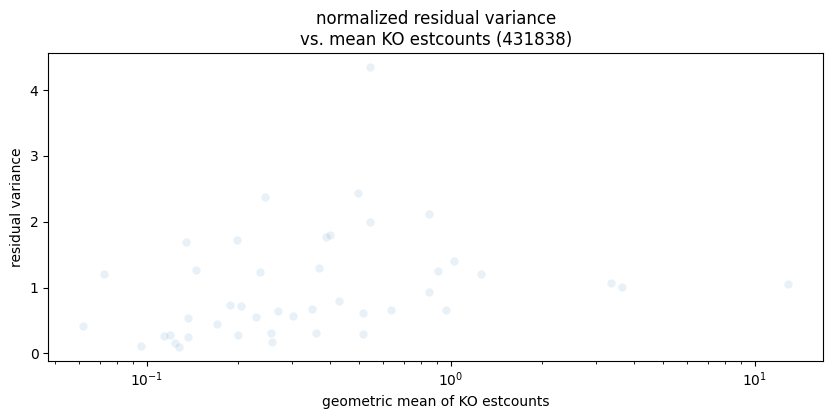

Normalizing slab 78 of 166: 33630 (52 samples, 31 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 31

R[write to console]: Total overdispersed genes: 31

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 31 by 52

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 31 genes, 52 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.288904100004

R[write to console]: Second step: Get residuals using fitted parameters for 31 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5159242 secs



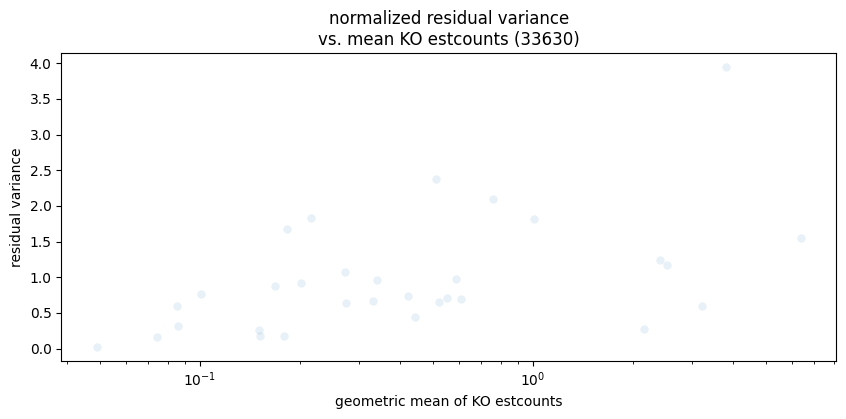

Normalizing slab 79 of 166: 35680 (53 samples, 45 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 45

R[write to console]: Total overdispersed genes: 45

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 45 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 45 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  6.08049315726336

R[write to console]: Second step: Get residuals using fitted parameters for 45 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.528023 secs



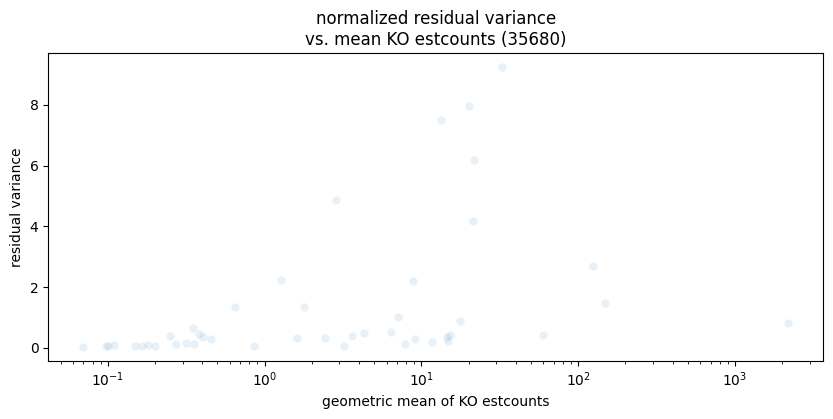

Normalizing slab 80 of 166: 35687 (53 samples, 53 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 53

R[write to console]: Total overdispersed genes: 53

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 53 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 53 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.408699375616

R[write to console]: Second step: Get residuals using fitted parameters for 53 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5275664 secs



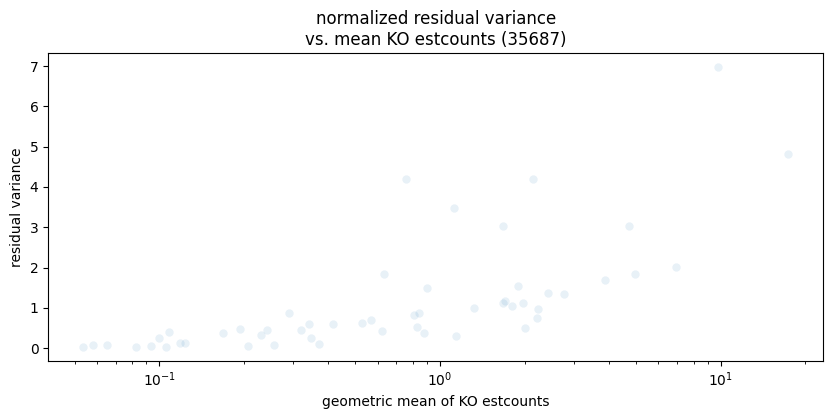

Normalizing slab 81 of 166: 39119 (53 samples, 65 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 65

R[write to console]: Total overdispersed genes: 64

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 65 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 64 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.913503939076

R[write to console]: Second step: Get residuals using fitted parameters for 65 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.601191 secs



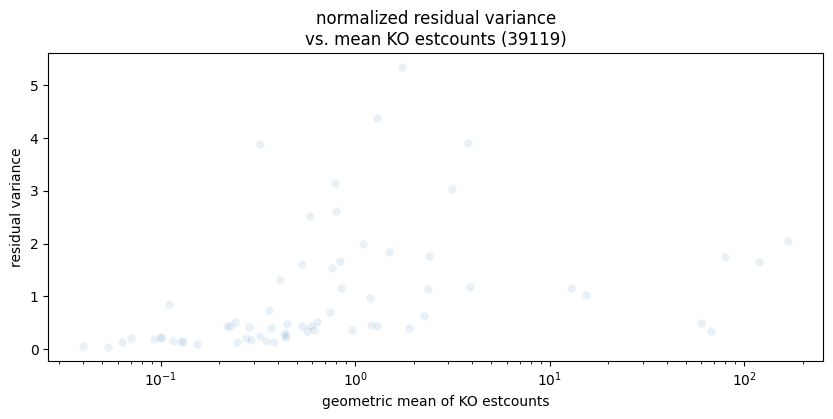

Normalizing slab 82 of 166: 420782 (43 samples, 39 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 39

R[write to console]: Total overdispersed genes: 39

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 39 by 43

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 39 genes, 43 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 39 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5227337 secs



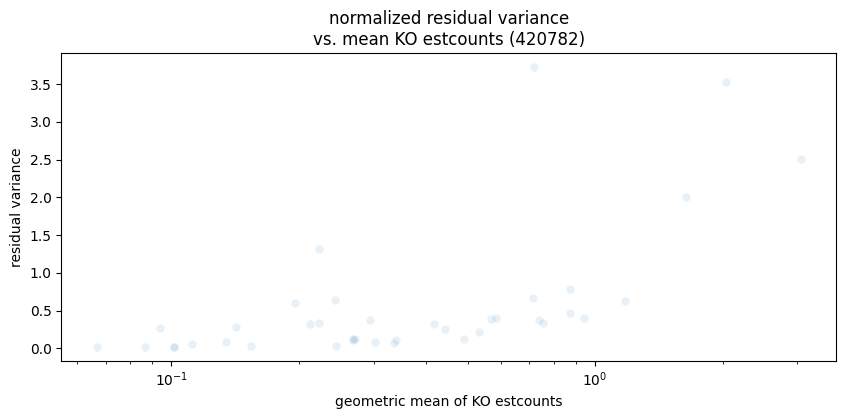

Normalizing slab 83 of 166: 49237 (53 samples, 45 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 45

R[write to console]: Total overdispersed genes: 45

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 45 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 45 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  2.56

R[write to console]: Second step: Get residuals using fitted parameters for 45 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5175037 secs



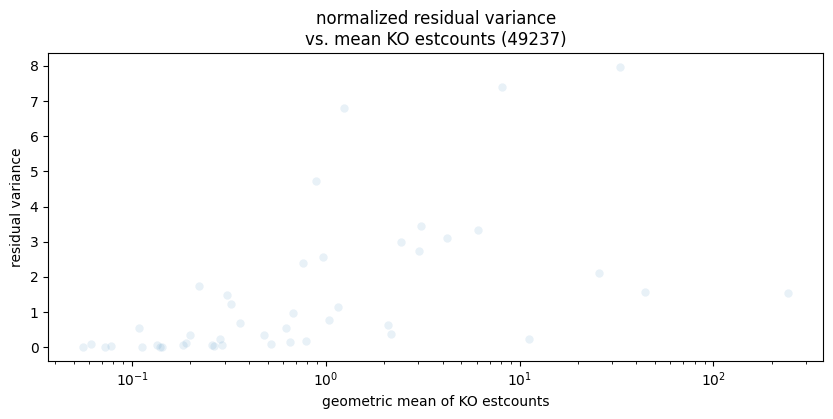

Normalizing slab 84 of 166: 35127 (53 samples, 40 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 40

R[write to console]: Total overdispersed genes: 40

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 40 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 40 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1

R[write to console]: Second step: Get residuals using fitted parameters for 40 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5164611 secs



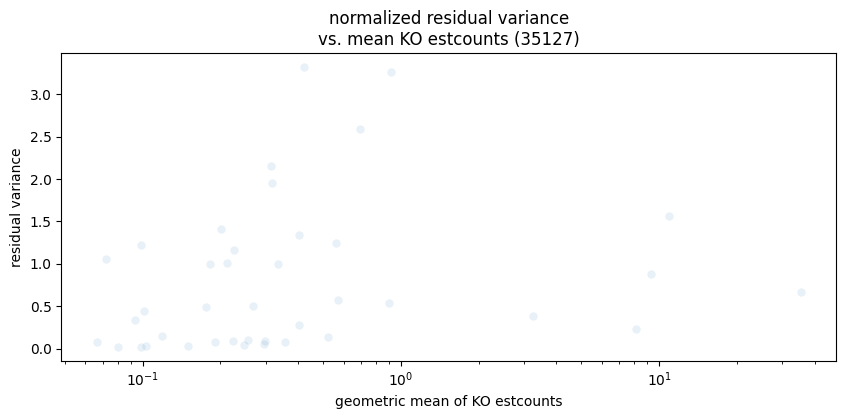

Normalizing slab 85 of 166: 29202 (53 samples, 36 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 36

R[write to console]: Total overdispersed genes: 35

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 36 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 35 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  6.905427441124

R[write to console]: Second step: Get residuals using fitted parameters for 36 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5202599 secs



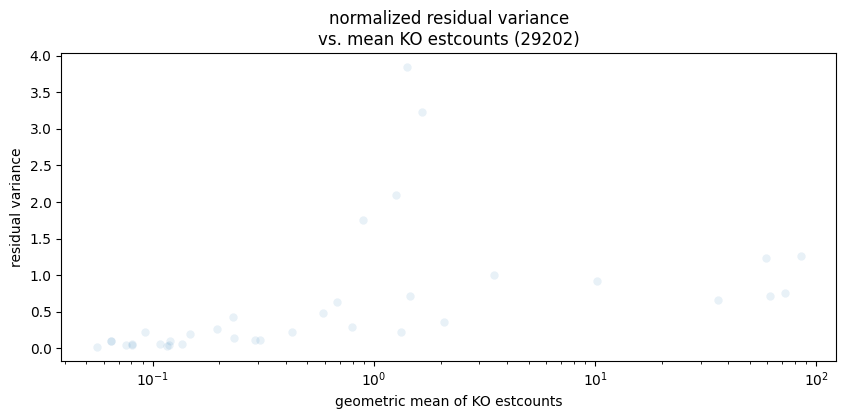

Normalizing slab 86 of 166: 33836 (53 samples, 68 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 68

R[write to console]: Total overdispersed genes: 67

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 68 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 67 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.8622236736

R[write to console]: Second step: Get residuals using fitted parameters for 68 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5314925 secs



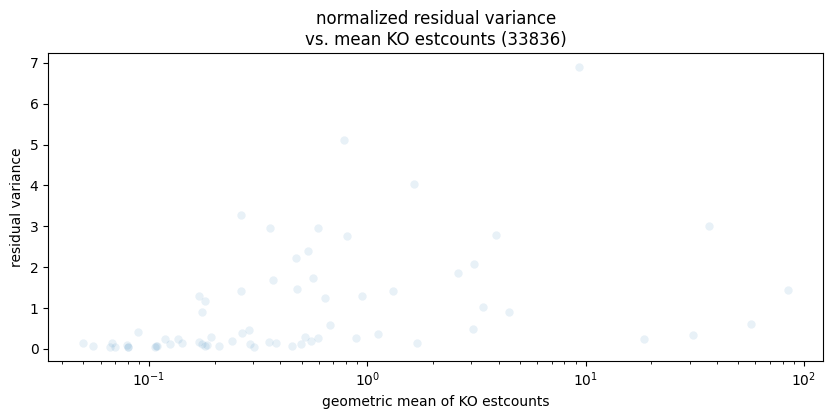

Normalizing slab 87 of 166: 589449 (43 samples, 32 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 32

R[write to console]: Total overdispersed genes: 32

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 32 by 43

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 32 genes, 43 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  2 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 2

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Found 2 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.294233559489

R[write to console]: Second step: Get residuals using fitted parameters for 32 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5170238 secs



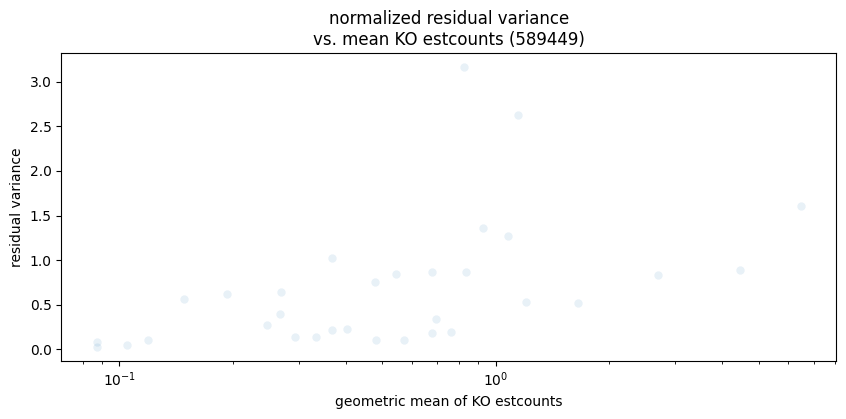

Normalizing slab 88 of 166: 186035 (43 samples, 38 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 38

R[write to console]: Total overdispersed genes: 38

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 38 by 43

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 38 genes, 43 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Found 1 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.433295695504

R[write to console]: Second step: Get residuals using fitted parameters for 38 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5199399 secs



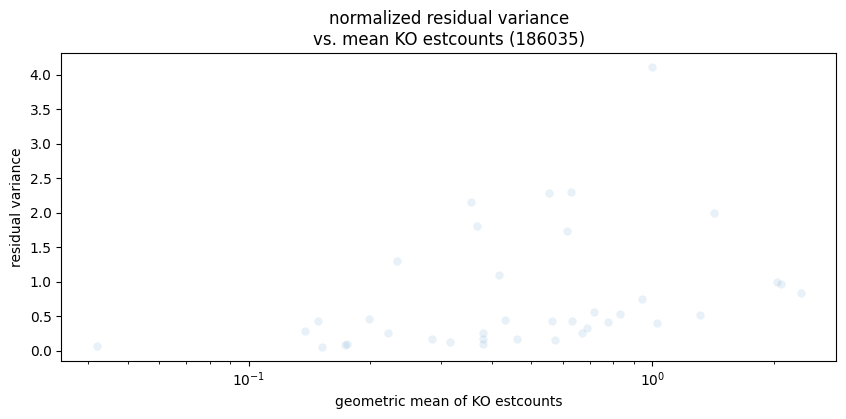

Normalizing slab 89 of 166: 33852 (46 samples, 70 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 70

R[write to console]: Total overdispersed genes: 70

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 70 by 46

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 70 genes, 46 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 70 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.523304 secs



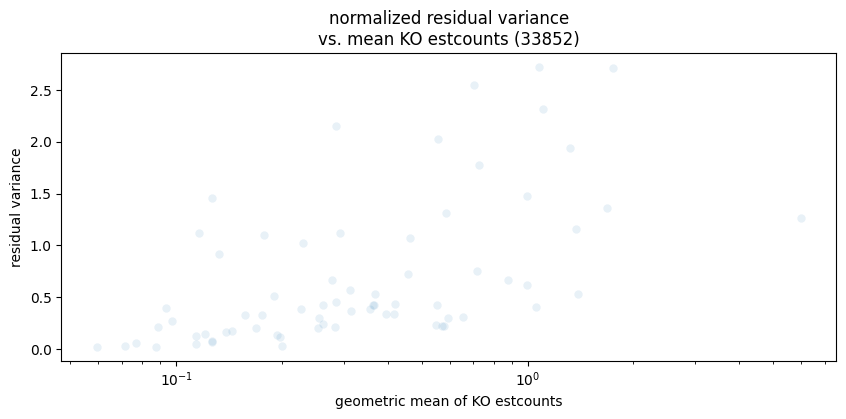

Normalizing slab 90 of 166: 2836 (53 samples, 164 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 164

R[write to console]: Total overdispersed genes: 164

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 164 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 164 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1.828547608644

R[write to console]: Second step: Get residuals using fitted parameters for 164 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5788896 secs



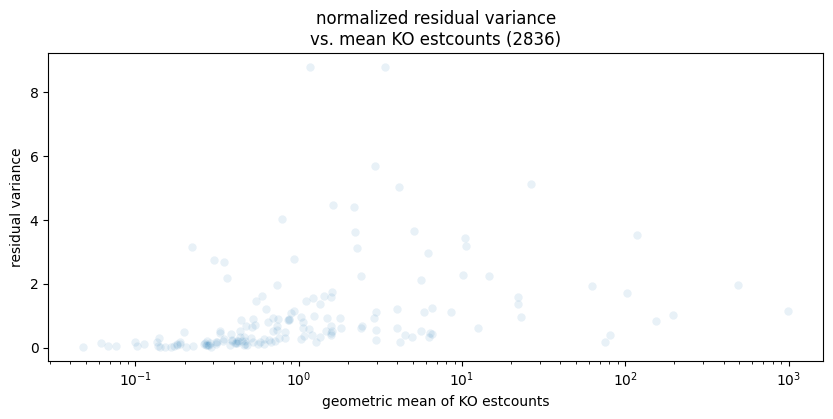

Normalizing slab 91 of 166: 2985 (53 samples, 31 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 31

R[write to console]: Total overdispersed genes: 31

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 31 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 31 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  2.30329946390625

R[write to console]: Second step: Get residuals using fitted parameters for 31 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5187287 secs



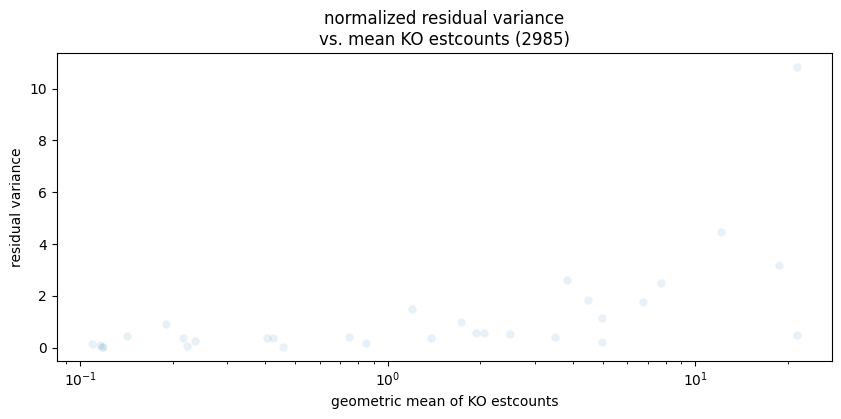

Normalizing slab 92 of 166: 96792 (52 samples, 44 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 43

R[write to console]: Total overdispersed genes: 43

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 43 by 52

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 43 genes, 52 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.254697864976

R[write to console]: Second step: Get residuals using fitted parameters for 43 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5195074 secs



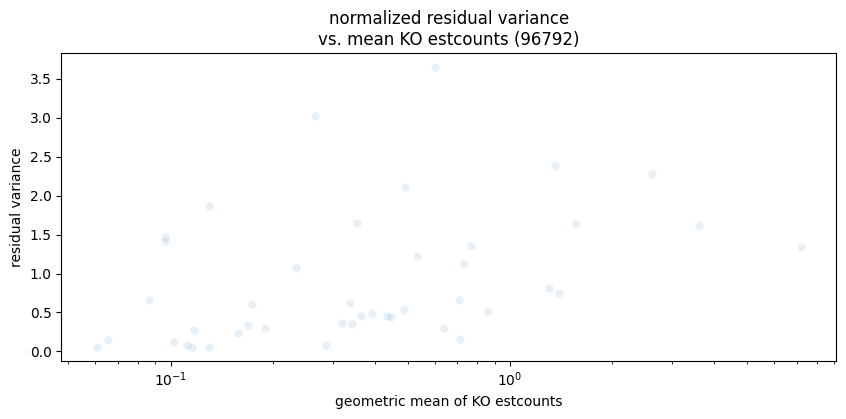

Normalizing slab 93 of 166: 35677 (53 samples, 122 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 122

R[write to console]: Total overdispersed genes: 122

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 122 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 122 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1.38861663788972

R[write to console]: Second step: Get residuals using fitted parameters for 122 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5533068 secs



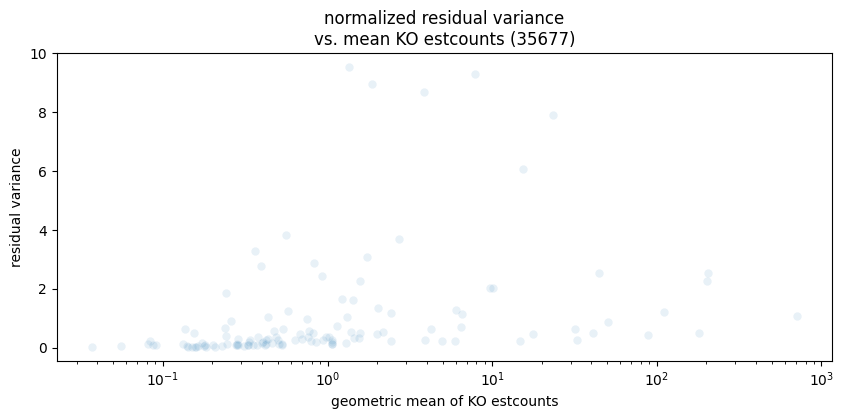

Normalizing slab 94 of 166: 54409 (53 samples, 57 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 57

R[write to console]: Total overdispersed genes: 56

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 57 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 56 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1.96

R[write to console]: Second step: Get residuals using fitted parameters for 57 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.526087 secs



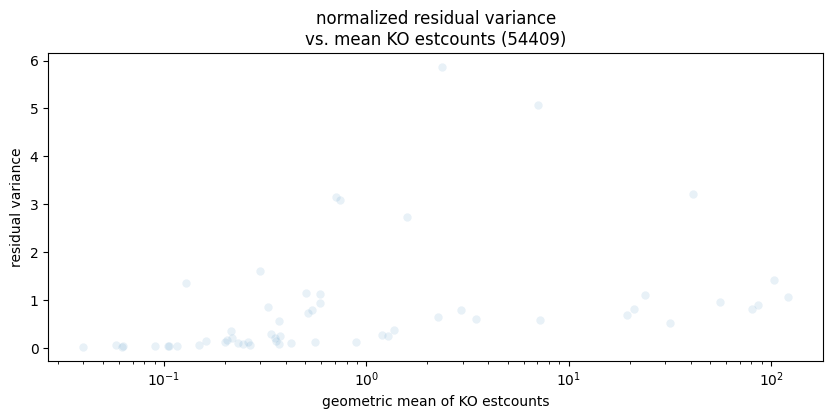

Normalizing slab 95 of 166: 35675 (53 samples, 56 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 56

R[write to console]: Total overdispersed genes: 56

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 56 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 56 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.822494817225

R[write to console]: Second step: Get residuals using fitted parameters for 56 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5225017 secs



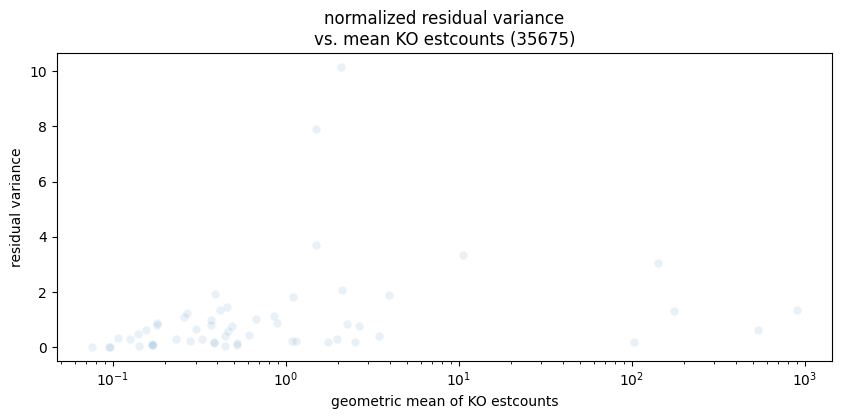

Normalizing slab 96 of 166: 91992 (53 samples, 79 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 79

R[write to console]: Total overdispersed genes: 79

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 79 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 79 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 79 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5289478 secs



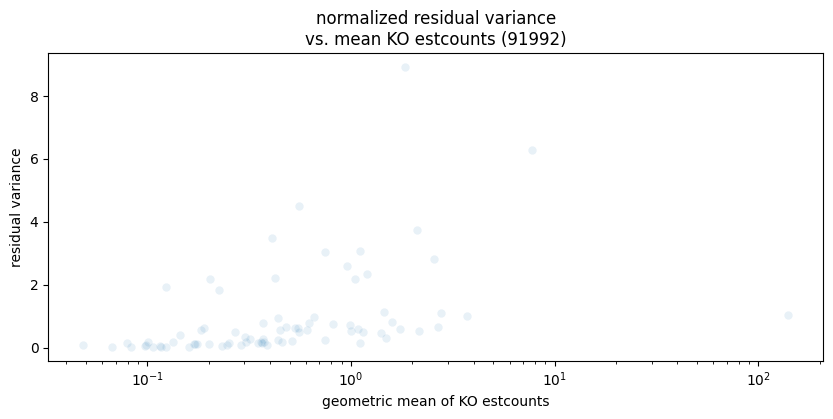

Normalizing slab 97 of 166: 722751 (52 samples, 38 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 38

R[write to console]: Total overdispersed genes: 38

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 38 by 52

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 38 genes, 52 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.371424426916

R[write to console]: Second step: Get residuals using fitted parameters for 38 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5202804 secs



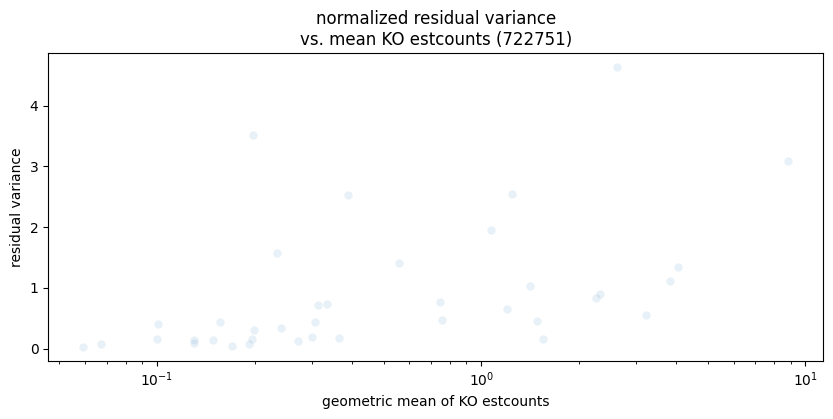

Normalizing slab 98 of 166: 2696291 (53 samples, 161 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 161

R[write to console]: Total overdispersed genes: 160

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 161 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 160 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1.865781156096

R[write to console]: Second step: Get residuals using fitted parameters for 161 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5723963 secs



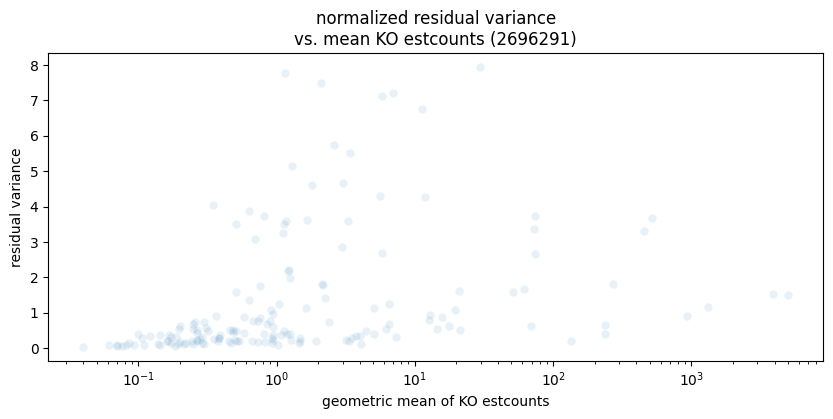

Normalizing slab 99 of 166: 1735725 (52 samples, 57 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 57

R[write to console]: Total overdispersed genes: 55

R[write to console]: Excluding 2 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 57 by 52

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 55 genes, 52 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 2

R[write to console]: Calling offset model for all 2 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 2 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.16

R[write to console]: Second step: Get residuals using fitted parameters for 57 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.526227 secs



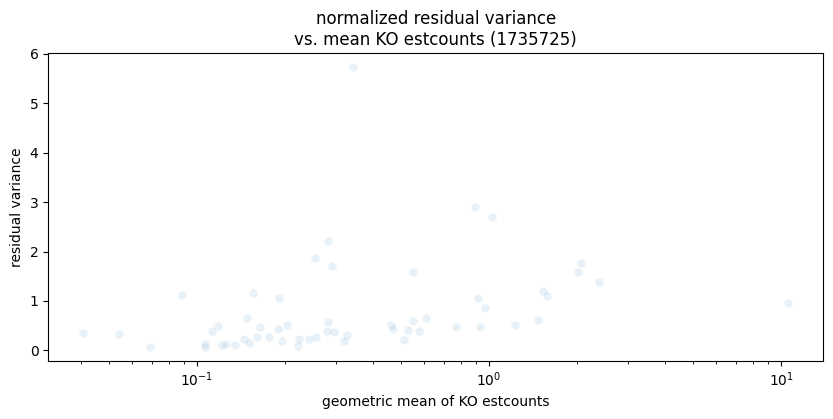

Normalizing slab 100 of 166: 33634 (53 samples, 43 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 43

R[write to console]: Total overdispersed genes: 43

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 43 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 43 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.16

R[write to console]: Second step: Get residuals using fitted parameters for 43 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5240066 secs



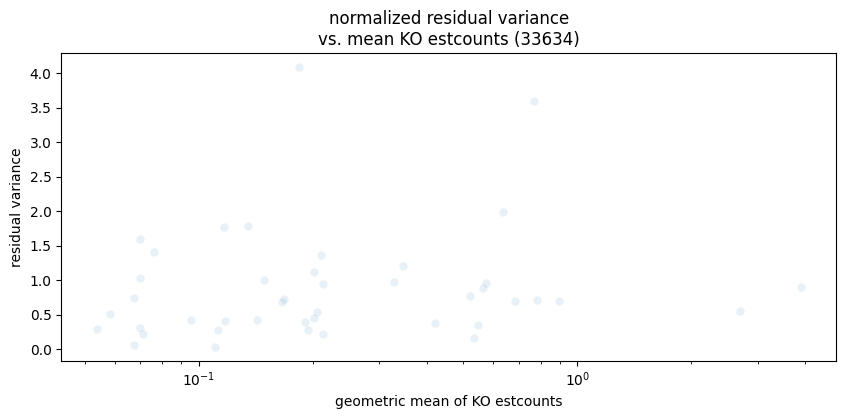

Normalizing slab 101 of 166: 2698737 (53 samples, 173 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 173

R[write to console]: Total overdispersed genes: 173

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 173 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 173 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  2.386104268804

R[write to console]: Second step: Get residuals using fitted parameters for 173 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.585026 secs



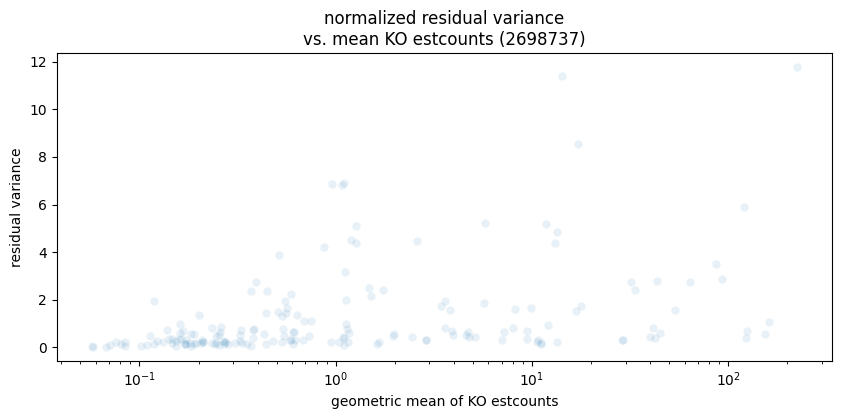

Normalizing slab 102 of 166: 38832 (53 samples, 55 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 55

R[write to console]: Total overdispersed genes: 55

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 55 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 55 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  2 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 2

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Found 2 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.499966422832081

R[write to console]: Second step: Get residuals using fitted parameters for 55 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5252428 secs



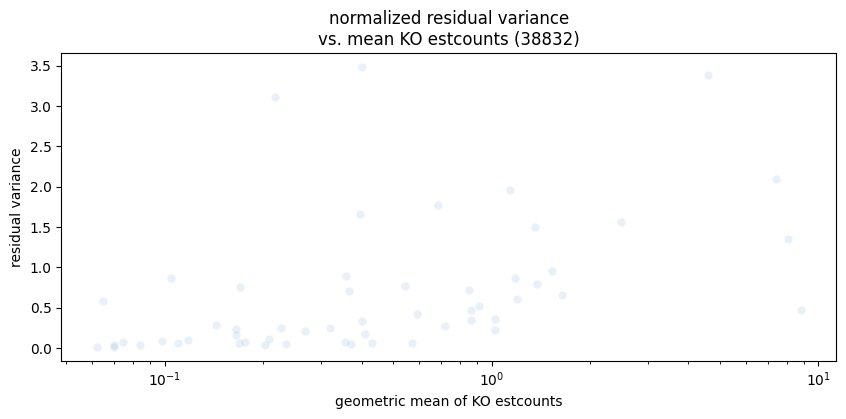

Normalizing slab 103 of 166: 41875 (53 samples, 158 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 158

R[write to console]: Total overdispersed genes: 158

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 158 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 158 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1.381875483024

R[write to console]: Second step: Get residuals using fitted parameters for 158 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5650237 secs



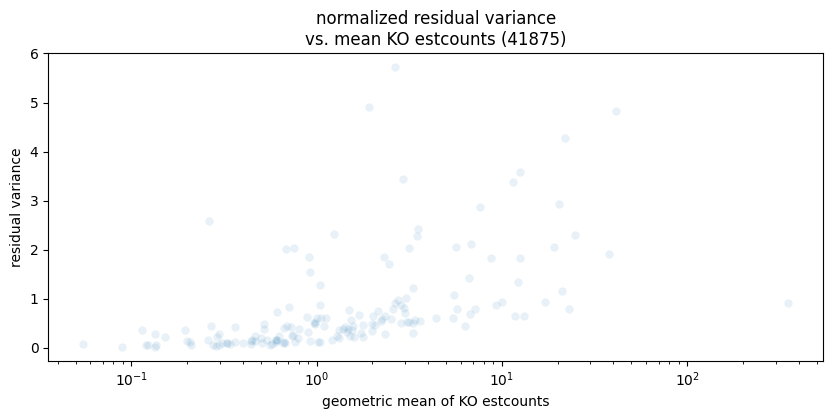

Normalizing slab 104 of 166: 2302914 (53 samples, 37 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 37

R[write to console]: Total overdispersed genes: 37

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 37 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 37 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1.44

R[write to console]: Second step: Get residuals using fitted parameters for 37 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5128562 secs



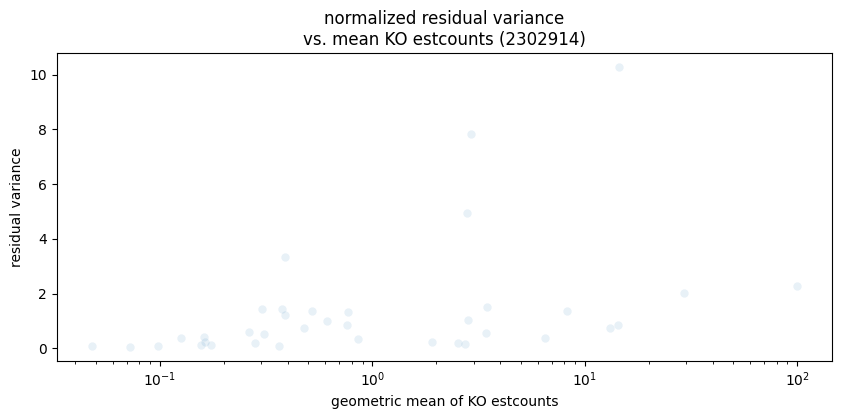

Normalizing slab 105 of 166: 3041 (53 samples, 75 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 75

R[write to console]: Total overdispersed genes: 75

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 75 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 75 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1.67567639923264

R[write to console]: Second step: Get residuals using fitted parameters for 75 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5273061 secs



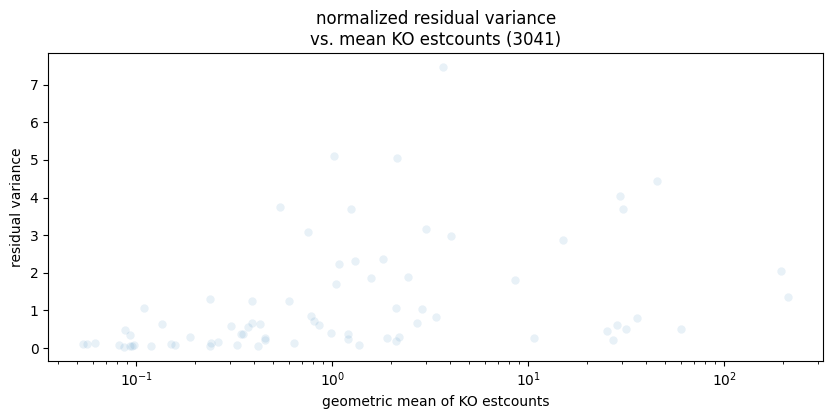

Normalizing slab 106 of 166: 2182694 (47 samples, 64 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 64

R[write to console]: Total overdispersed genes: 64

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 64 by 47

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 64 genes, 47 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.4686634681

R[write to console]: Second step: Get residuals using fitted parameters for 64 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.522697 secs



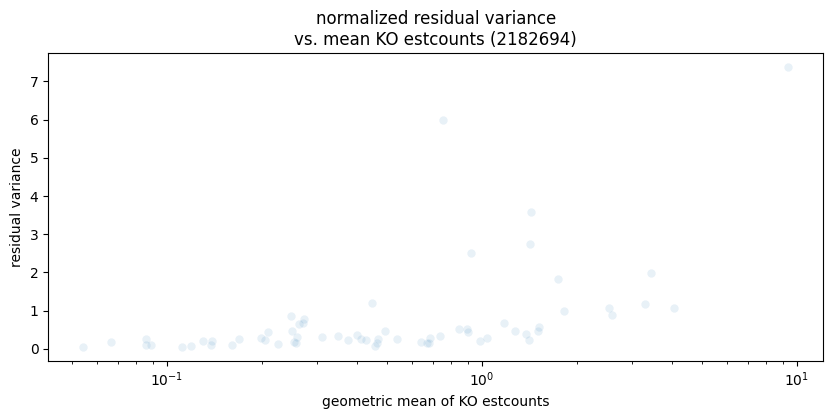

Normalizing slab 107 of 166: 2182707 (33 samples, 39 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 39

R[write to console]: Total overdispersed genes: 39

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 39 by 33

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 39 genes, 33 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 39 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.50842 secs



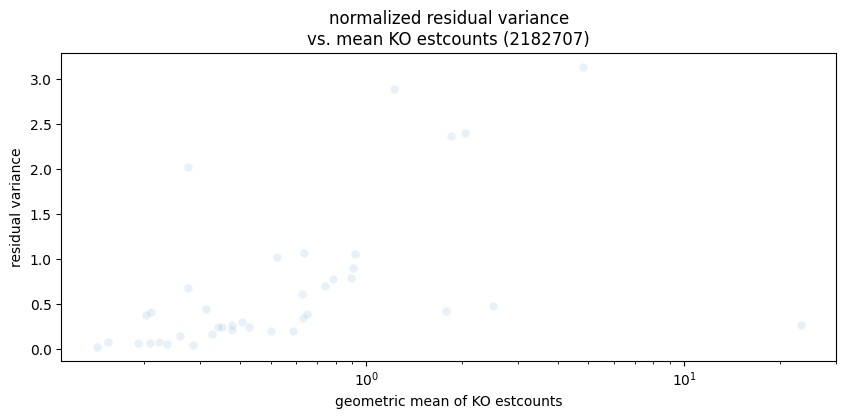

Normalizing slab 108 of 166: 3463 (53 samples, 99 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 99

R[write to console]: Total overdispersed genes: 98

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 99 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 98 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1.006847682724

R[write to console]: Second step: Get residuals using fitted parameters for 99 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5401449 secs



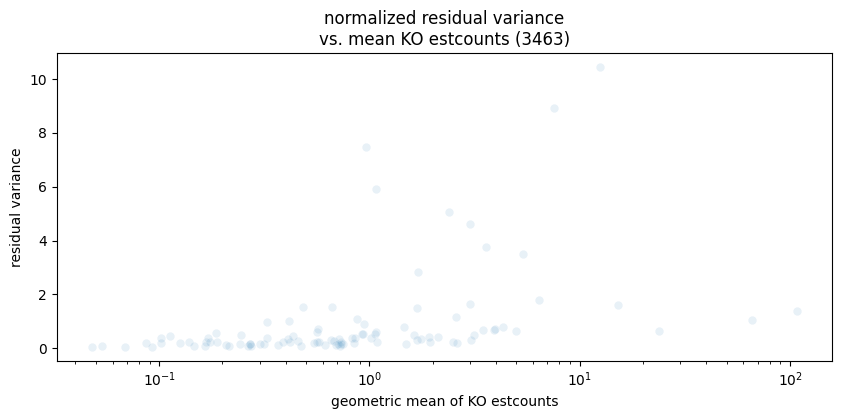

Normalizing slab 109 of 166: 2182727 (53 samples, 38 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 38

R[write to console]: Total overdispersed genes: 38

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 38 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 38 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.471382484329

R[write to console]: Second step: Get residuals using fitted parameters for 38 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.52407 secs



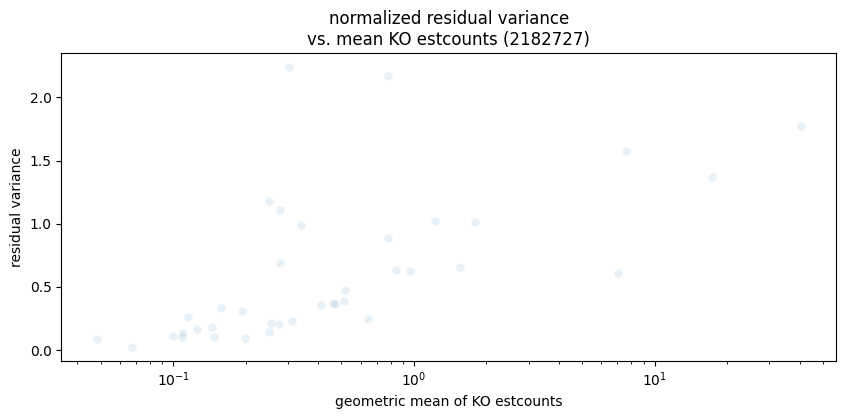

Normalizing slab 110 of 166: 91888 (38 samples, 30 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 30

R[write to console]: Total overdispersed genes: 30

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 30 by 38

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 30 genes, 38 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.59597952240841

R[write to console]: Second step: Get residuals using fitted parameters for 30 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5168743 secs



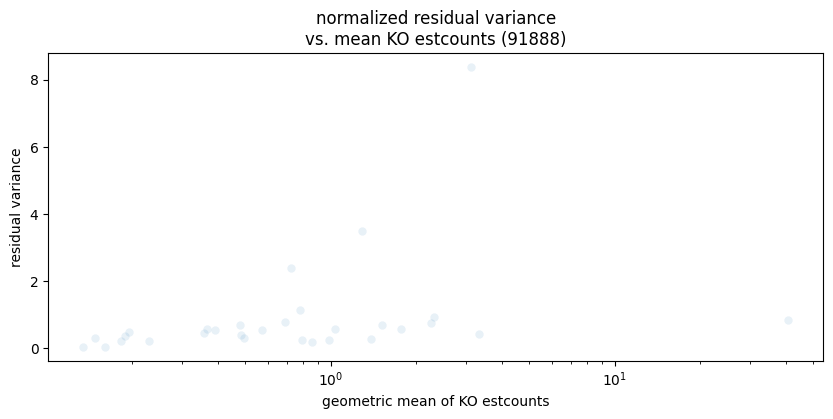

Normalizing slab 111 of 166: 2182688 (44 samples, 59 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 59

R[write to console]: Total overdispersed genes: 58

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 59 by 44

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 58 genes, 44 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.330721607056

R[write to console]: Second step: Get residuals using fitted parameters for 59 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5264845 secs



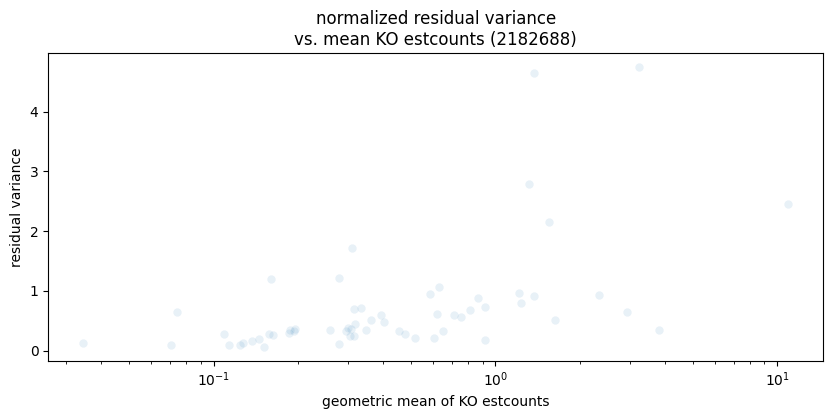

Normalizing slab 112 of 166: 2182709 (53 samples, 52 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 52

R[write to console]: Total overdispersed genes: 51

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 52 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 51 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.565931216656

R[write to console]: Second step: Get residuals using fitted parameters for 52 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5265207 secs



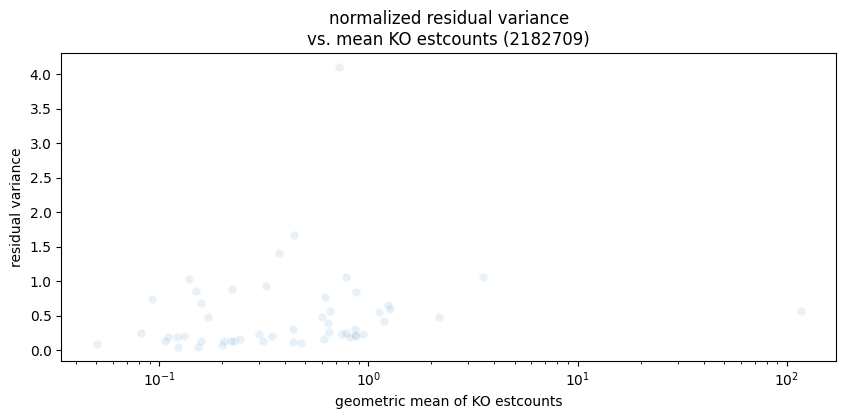

Normalizing slab 113 of 166: 71274 (41 samples, 33 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 32

R[write to console]: Total overdispersed genes: 32

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 32 by 41

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 32 genes, 41 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Found 1 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 32 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5187526 secs



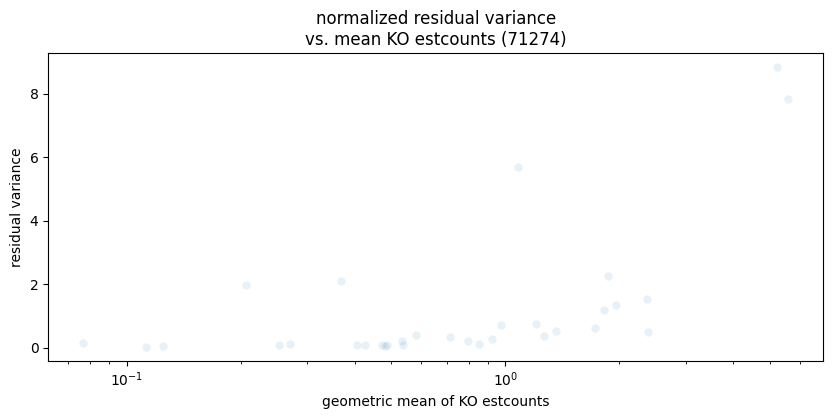

Normalizing slab 114 of 166: 2182685 (53 samples, 49 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 49

R[write to console]: Total overdispersed genes: 49

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 49 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 49 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.767595015625

R[write to console]: Second step: Get residuals using fitted parameters for 49 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5273077 secs



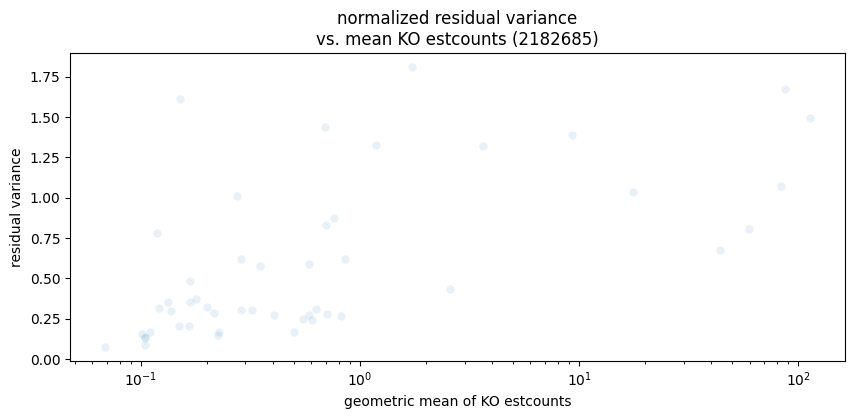

Normalizing slab 115 of 166: 71275 (44 samples, 32 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 32

R[write to console]: Total overdispersed genes: 31

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 32 by 44

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 31 genes, 44 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.370736072161

R[write to console]: Second step: Get residuals using fitted parameters for 32 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5681801 secs



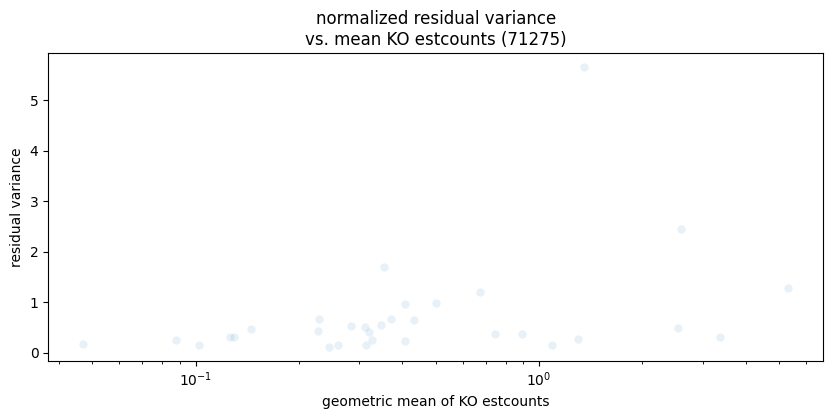

Normalizing slab 116 of 166: 2182681 (53 samples, 33 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 33

R[write to console]: Total overdispersed genes: 32

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 33 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 32 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  2.3542912969

R[write to console]: Second step: Get residuals using fitted parameters for 33 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5128689 secs



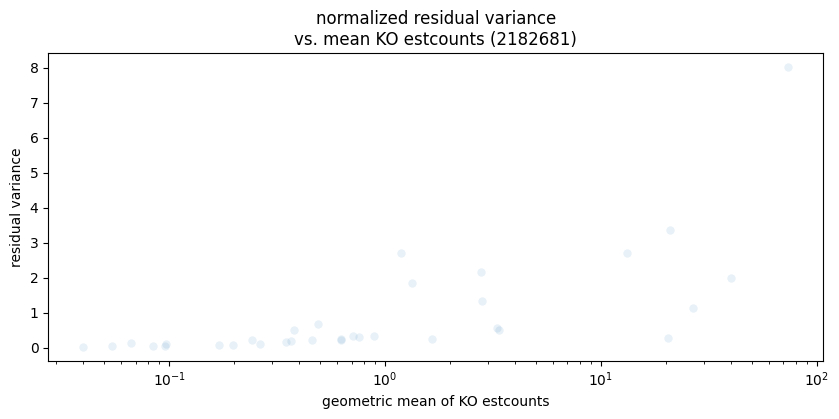

Normalizing slab 117 of 166: 1437201 (51 samples, 56 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 56

R[write to console]: Total overdispersed genes: 55

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 56 by 51

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 55 genes, 51 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.592693657956

R[write to console]: Second step: Get residuals using fitted parameters for 56 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5231967 secs



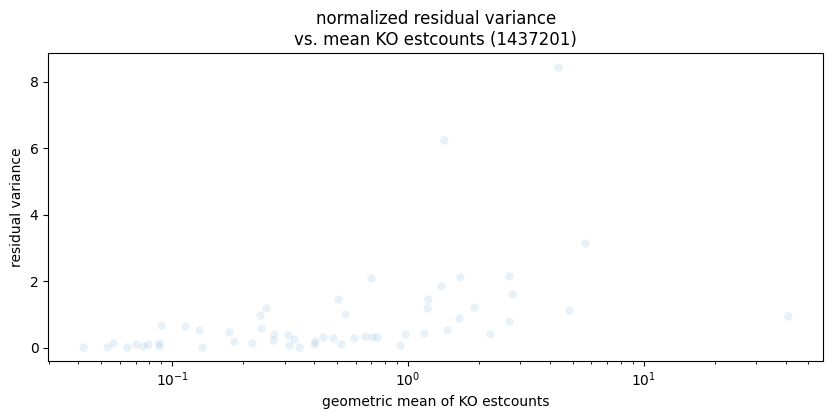

Normalizing slab 118 of 166: 1437183 (50 samples, 68 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 68

R[write to console]: Total overdispersed genes: 68

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 68 by 50

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 68 genes, 50 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1.050354417424

R[write to console]: Second step: Get residuals using fitted parameters for 68 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5301778 secs



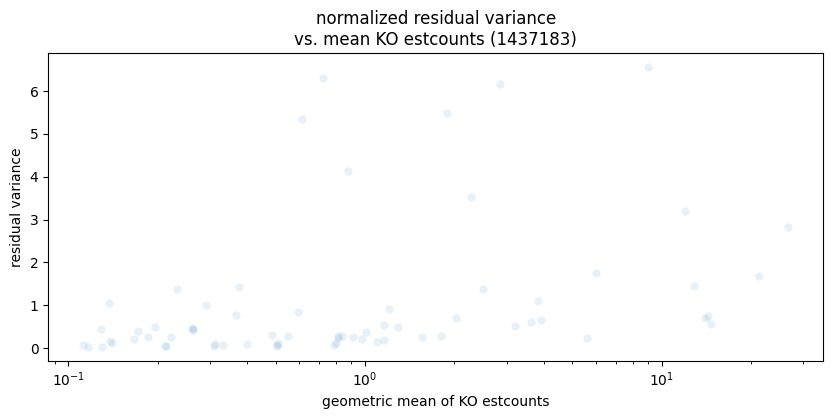

Normalizing slab 119 of 166: 33090 (53 samples, 39 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 39

R[write to console]: Total overdispersed genes: 39

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 39 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 39 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.16

R[write to console]: Second step: Get residuals using fitted parameters for 39 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5686159 secs



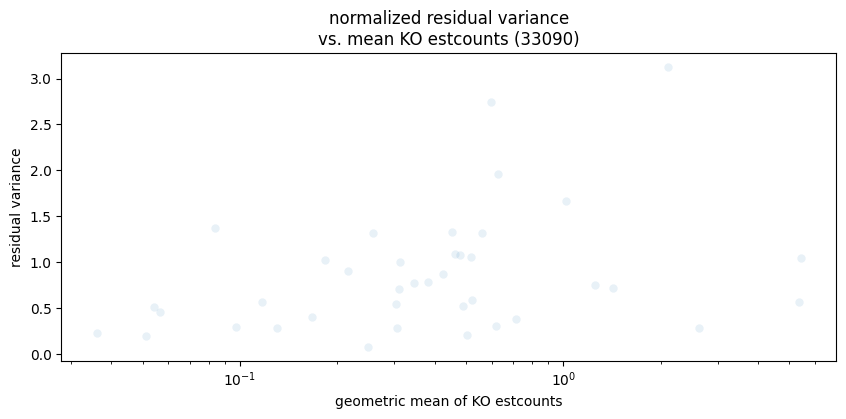

Normalizing slab 120 of 166: 2618586 (52 samples, 85 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 85

R[write to console]: Total overdispersed genes: 84

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 85 by 52

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 84 genes, 52 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  2 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 2

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Found 2 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.607060697881

R[write to console]: Second step: Get residuals using fitted parameters for 85 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5361614 secs



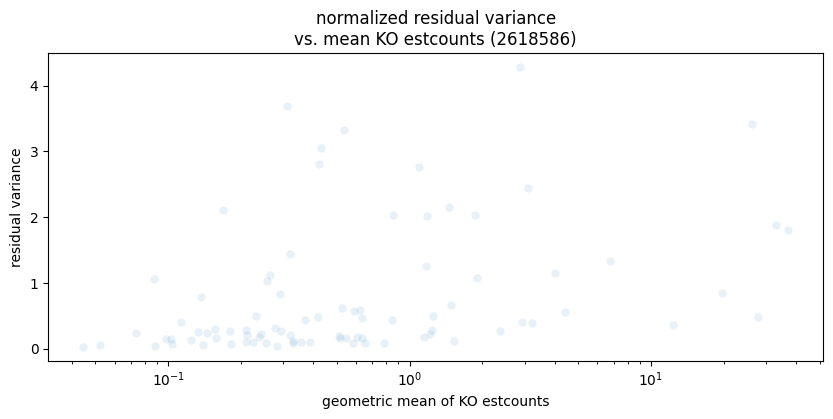

Normalizing slab 121 of 166: 2183250 (49 samples, 47 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 47

R[write to console]: Total overdispersed genes: 47

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 47 by 49

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 47 genes, 49 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1

R[write to console]: Second step: Get residuals using fitted parameters for 47 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.524823 secs



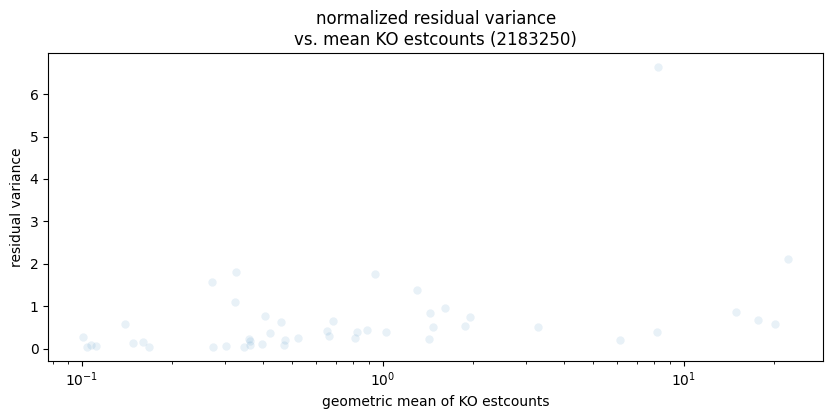

Normalizing slab 122 of 166: 41320 (53 samples, 84 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 84

R[write to console]: Total overdispersed genes: 84

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 84 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 84 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1

R[write to console]: Second step: Get residuals using fitted parameters for 84 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5360532 secs



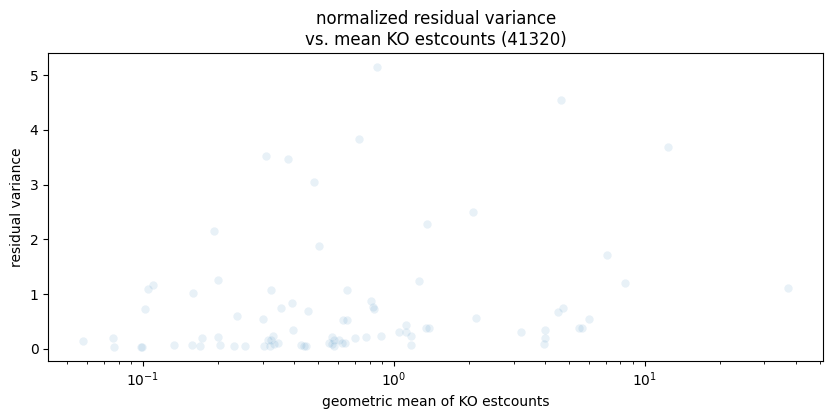

Normalizing slab 123 of 166: 2631476 (53 samples, 53 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 53

R[write to console]: Total overdispersed genes: 53

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 53 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 53 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 53 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5952933 secs



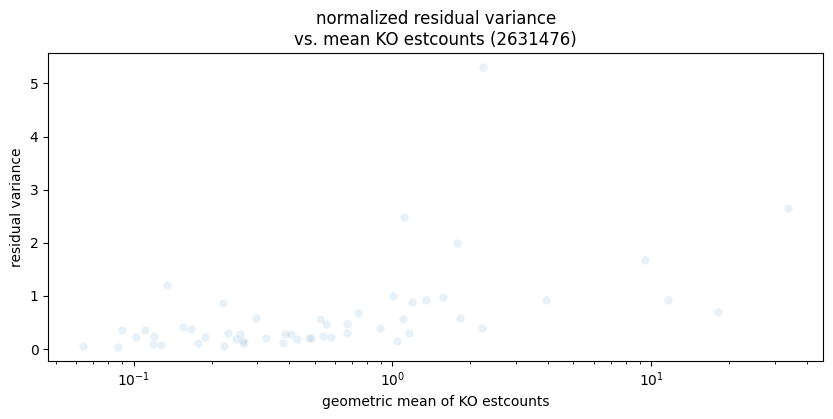

Normalizing slab 124 of 166: 2183216 (53 samples, 31 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 31

R[write to console]: Total overdispersed genes: 31

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 31 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 31 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1.873952917776

R[write to console]: Second step: Get residuals using fitted parameters for 31 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5166209 secs



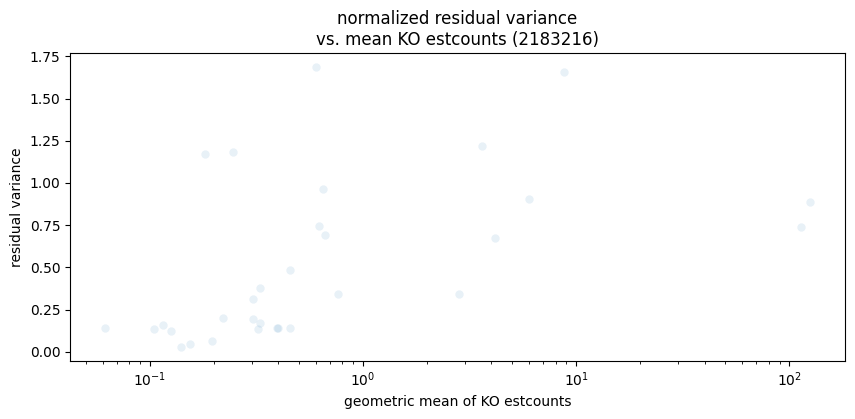

Normalizing slab 125 of 166: 2183232 (48 samples, 35 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 35

R[write to console]: Total overdispersed genes: 35

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 35 by 48

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 35 genes, 48 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 35 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5178676 secs



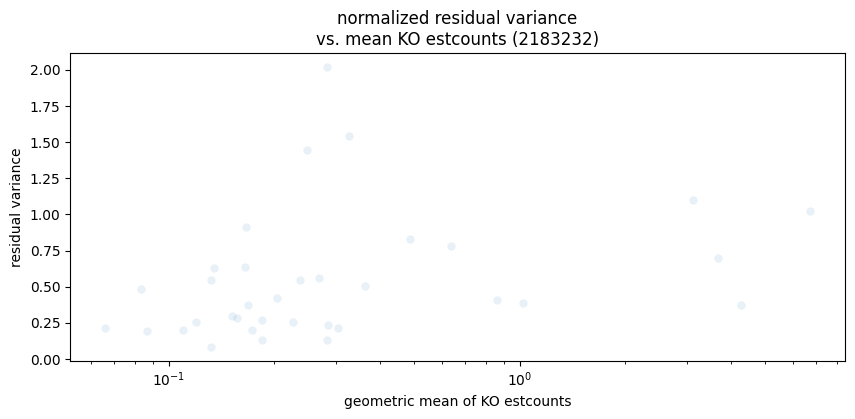

Normalizing slab 126 of 166: 2642610 (53 samples, 84 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 84

R[write to console]: Total overdispersed genes: 84

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 84 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 84 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 84 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5390832 secs



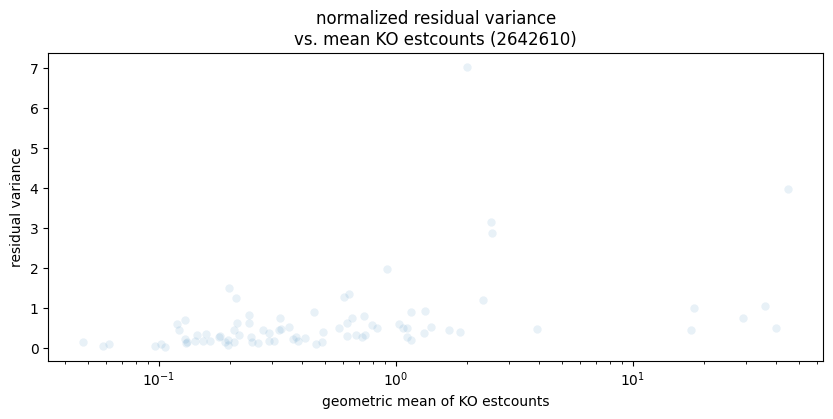

Normalizing slab 127 of 166: 2183224 (46 samples, 34 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 34

R[write to console]: Total overdispersed genes: 34

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 34 by 46

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 34 genes, 46 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.920741959809

R[write to console]: Second step: Get residuals using fitted parameters for 34 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5328491 secs



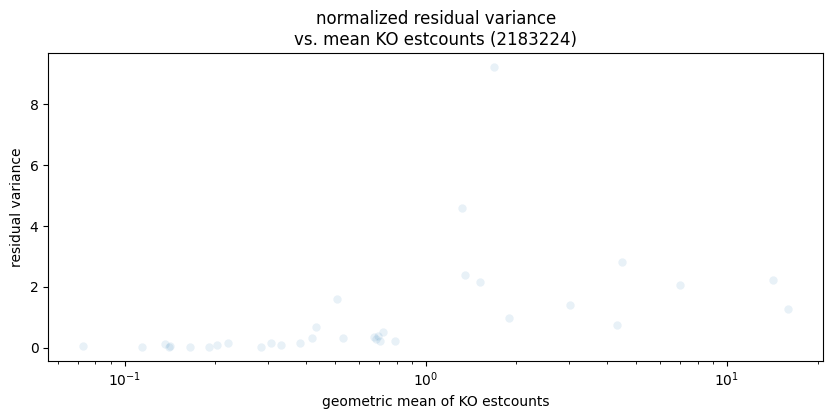

Normalizing slab 128 of 166: 2183230 (53 samples, 41 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 41

R[write to console]: Total overdispersed genes: 41

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 41 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 41 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.476607975424

R[write to console]: Second step: Get residuals using fitted parameters for 41 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5201492 secs



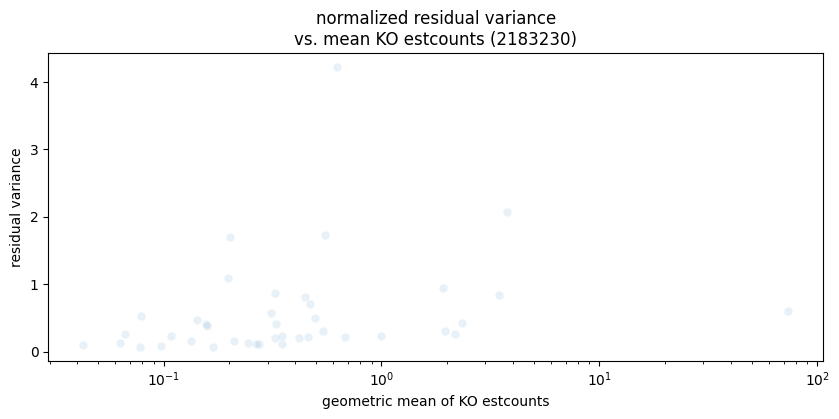

Normalizing slab 129 of 166: 2183267 (36 samples, 30 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 30

R[write to console]: Total overdispersed genes: 30

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 30 by 36

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 30 genes, 36 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.185738588676

R[write to console]: Second step: Get residuals using fitted parameters for 30 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5164189 secs



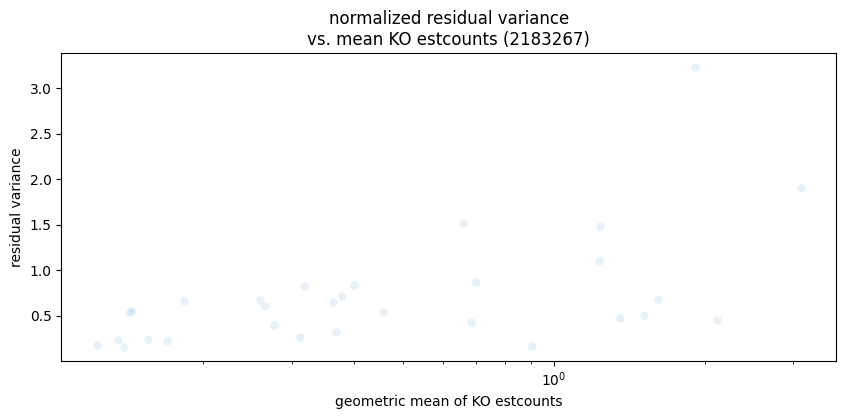

Normalizing slab 130 of 166: 233137 (52 samples, 54 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 54

R[write to console]: Total overdispersed genes: 53

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 54 by 52

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 53 genes, 52 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 54 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5239477 secs



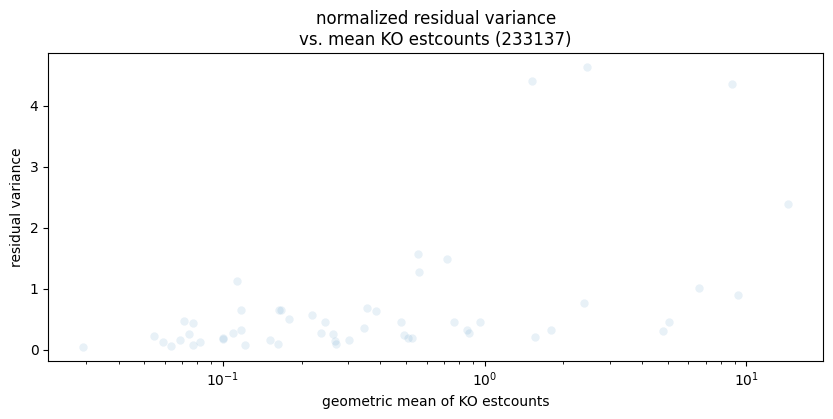

Normalizing slab 131 of 166: 233124 (53 samples, 45 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 45

R[write to console]: Total overdispersed genes: 44

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 45 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 44 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 45 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.518842 secs



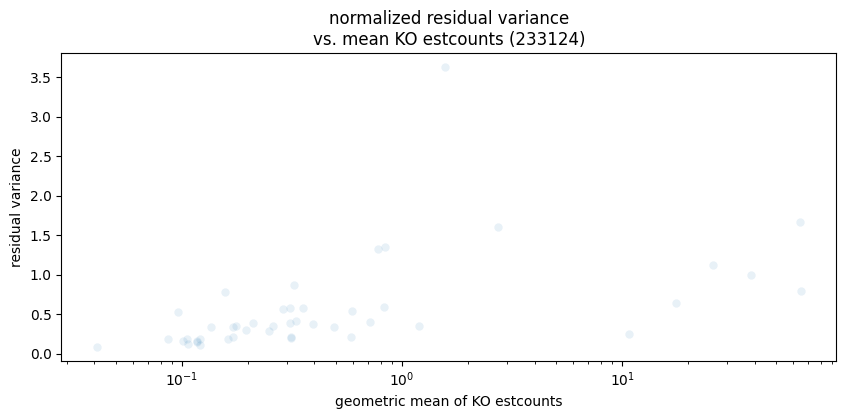

Normalizing slab 132 of 166: 78238 (53 samples, 166 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 166

R[write to console]: Total overdispersed genes: 165

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 166 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 165 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1.410127750144

R[write to console]: Second step: Get residuals using fitted parameters for 166 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5665765 secs



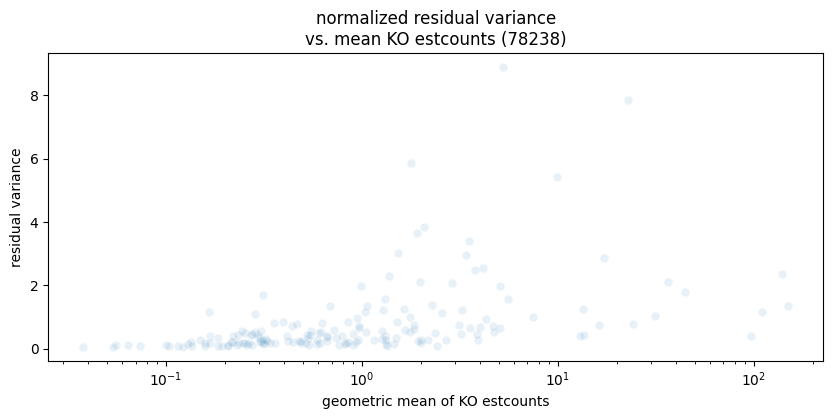

Normalizing slab 133 of 166: 33313 (53 samples, 193 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 193

R[write to console]: Total overdispersed genes: 193

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 193 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 193 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  3.169332788644

R[write to console]: Second step: Get residuals using fitted parameters for 193 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5941601 secs



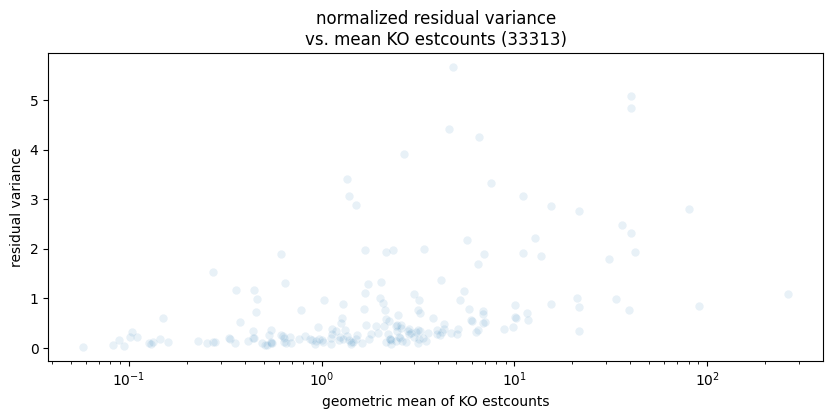

Normalizing slab 134 of 166: 2622369 (53 samples, 33 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 33

R[write to console]: Total overdispersed genes: 33

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 33 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 33 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.988576809984

R[write to console]: Second step: Get residuals using fitted parameters for 33 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5171545 secs



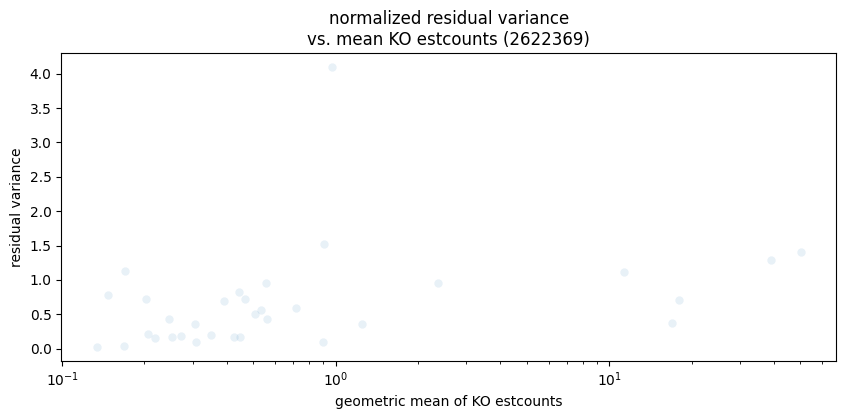

Normalizing slab 135 of 166: 2642659 (37 samples, 31 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 31

R[write to console]: Total overdispersed genes: 31

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 31 by 37

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 31 genes, 37 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.43908938409924

R[write to console]: Second step: Get residuals using fitted parameters for 31 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5177259 secs



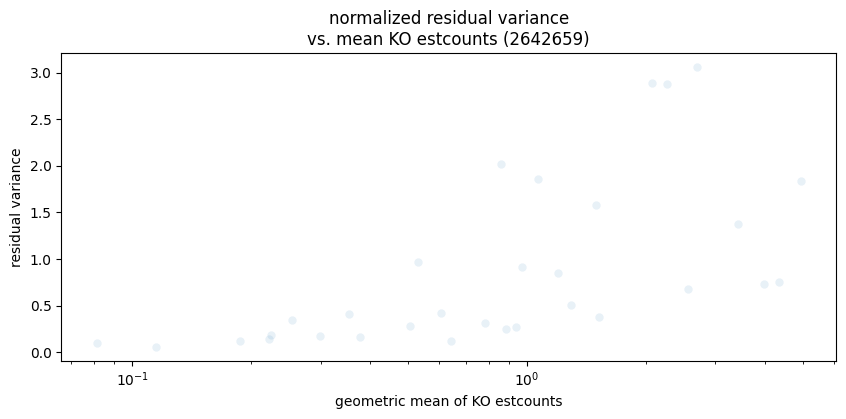

Normalizing slab 136 of 166: 1649654 (45 samples, 39 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 39

R[write to console]: Total overdispersed genes: 39

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 39 by 45

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 39 genes, 45 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Found 1 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.530611721761

R[write to console]: Second step: Get residuals using fitted parameters for 39 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5188255 secs



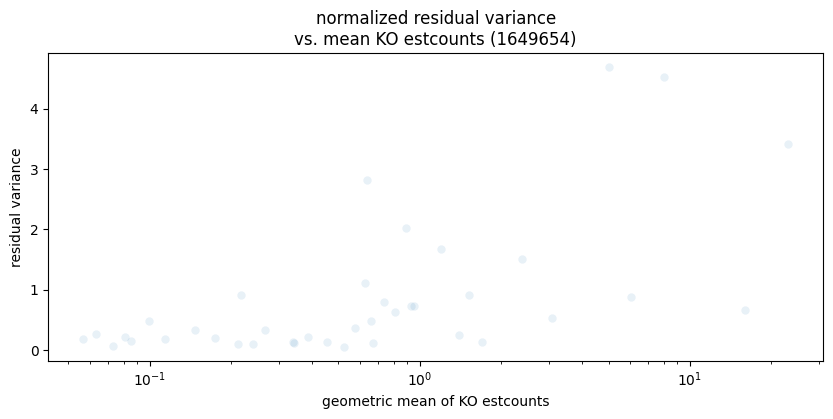

Normalizing slab 137 of 166: 6341 (52 samples, 82 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 82

R[write to console]: Total overdispersed genes: 81

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 82 by 52

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 81 genes, 52 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Found 1 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.3867969249

R[write to console]: Second step: Get residuals using fitted parameters for 82 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5331957 secs



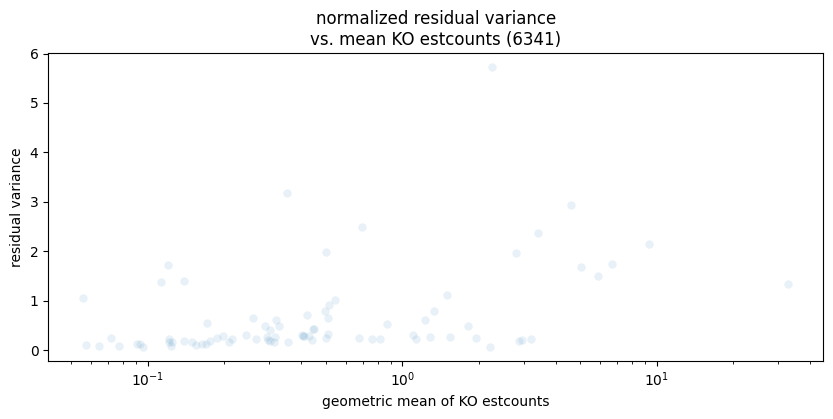

Normalizing slab 138 of 166: 39195 (53 samples, 36 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 36

R[write to console]: Total overdispersed genes: 35

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 36 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 35 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.487709483044

R[write to console]: Second step: Get residuals using fitted parameters for 36 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5155685 secs



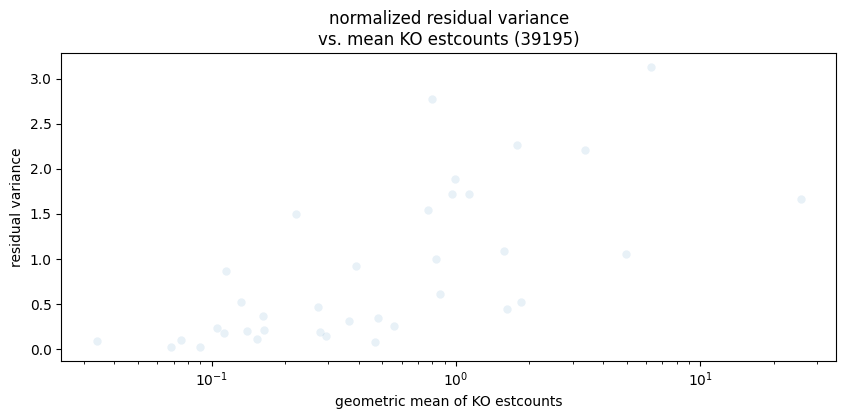

Normalizing slab 139 of 166: 1206795 (53 samples, 74 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 74

R[write to console]: Total overdispersed genes: 73

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 74 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 73 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 74 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5321078 secs



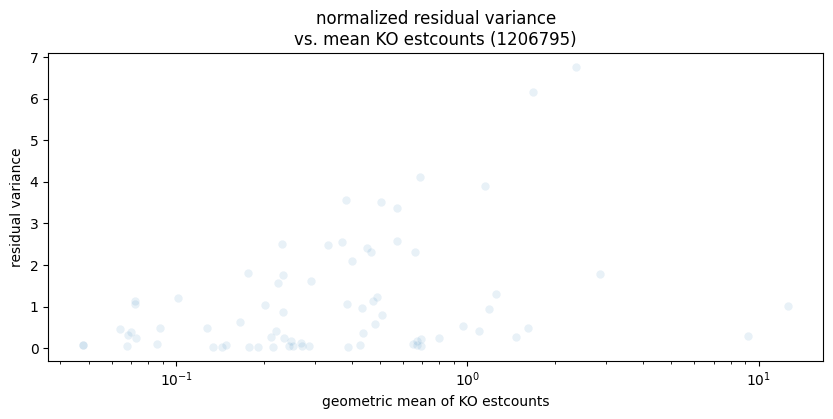

Normalizing slab 140 of 166: 565004 (53 samples, 57 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 57

R[write to console]: Total overdispersed genes: 57

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 57 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 57 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.29409937686649

R[write to console]: Second step: Get residuals using fitted parameters for 57 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5280492 secs



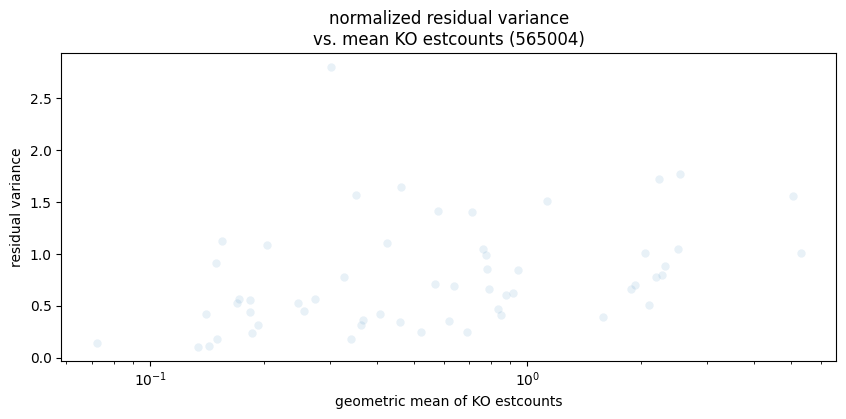

Normalizing slab 141 of 166: 116571 (52 samples, 49 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 49

R[write to console]: Total overdispersed genes: 48

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 49 by 52

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 48 genes, 52 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.16

R[write to console]: Second step: Get residuals using fitted parameters for 49 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5202439 secs



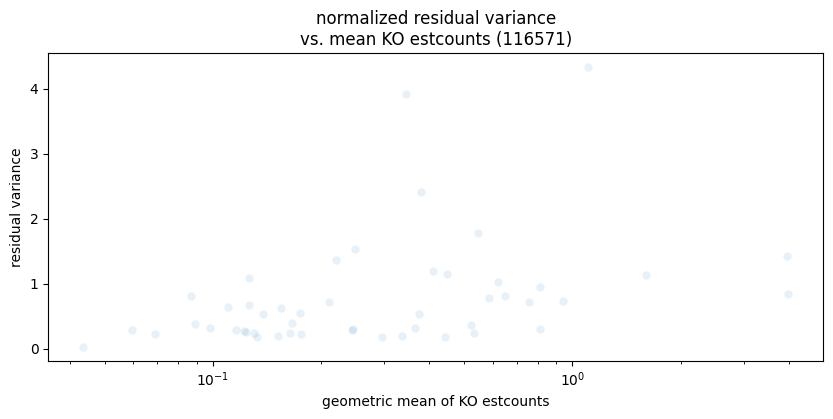

Normalizing slab 142 of 166: 6837 (52 samples, 38 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 38

R[write to console]: Total overdispersed genes: 38

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 38 by 52

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 38 genes, 52 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 38 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5172942 secs



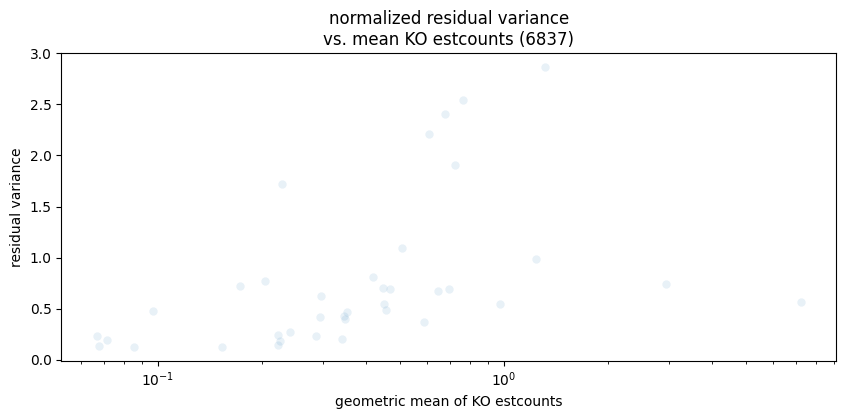

Normalizing slab 143 of 166: 119369 (36 samples, 34 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 34

R[write to console]: Total overdispersed genes: 34

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 34 by 36

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 34 genes, 36 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Found 1 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.276474052864

R[write to console]: Second step: Get residuals using fitted parameters for 34 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5186398 secs



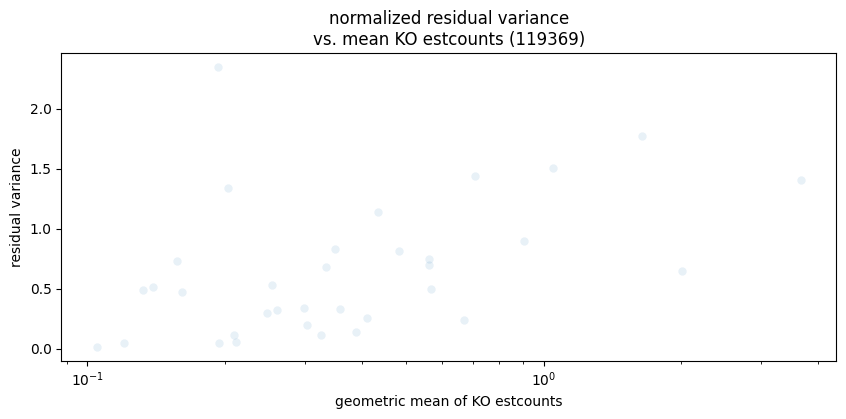

Normalizing slab 144 of 166: 6835 (48 samples, 72 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 72

R[write to console]: Total overdispersed genes: 72

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 72 by 48

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 72 genes, 48 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.16

R[write to console]: Second step: Get residuals using fitted parameters for 72 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5274529 secs



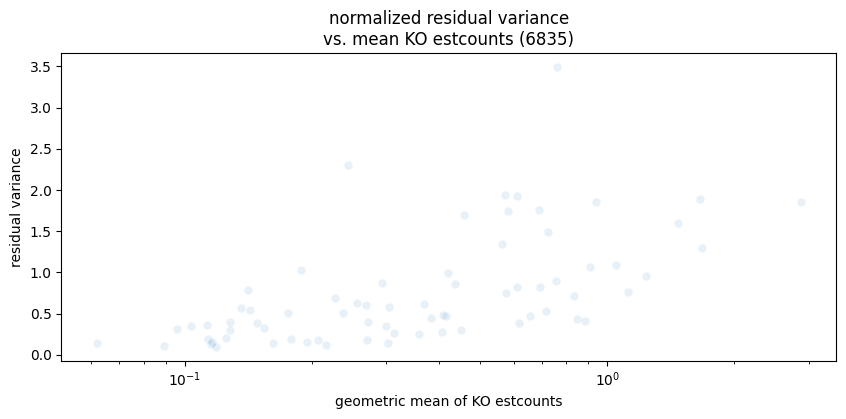

Normalizing slab 145 of 166: 6833 (53 samples, 60 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 60

R[write to console]: Total overdispersed genes: 60

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 60 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 60 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.16

R[write to console]: Second step: Get residuals using fitted parameters for 60 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5277376 secs



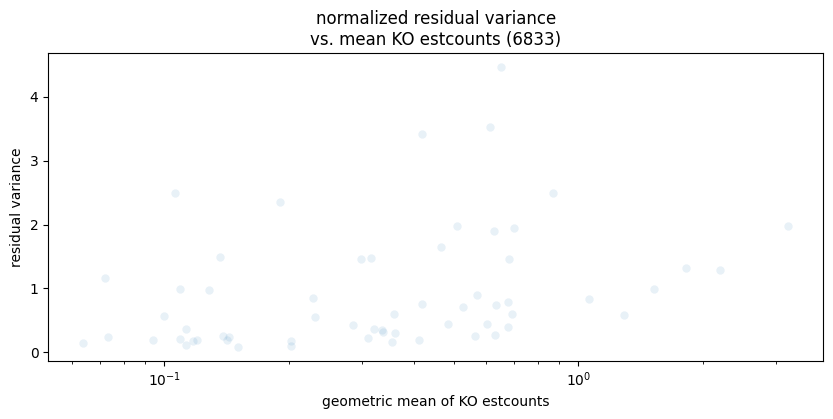

Normalizing slab 146 of 166: 116569 (53 samples, 71 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 70

R[write to console]: Total overdispersed genes: 68

R[write to console]: Excluding 2 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 70 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 68 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 2

R[write to console]: Calling offset model for all 2 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 2 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.16

R[write to console]: Second step: Get residuals using fitted parameters for 70 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5288315 secs



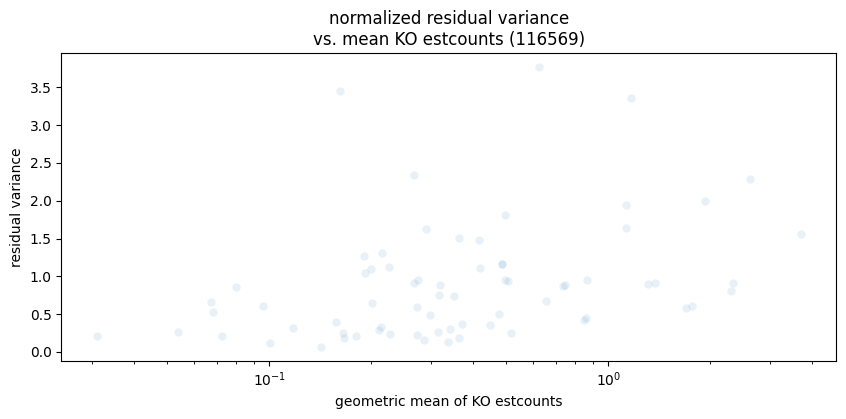

Normalizing slab 147 of 166: 6706 (52 samples, 71 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 71

R[write to console]: Total overdispersed genes: 71

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 71 by 52

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 71 genes, 52 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Found 1 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 71 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5320439 secs



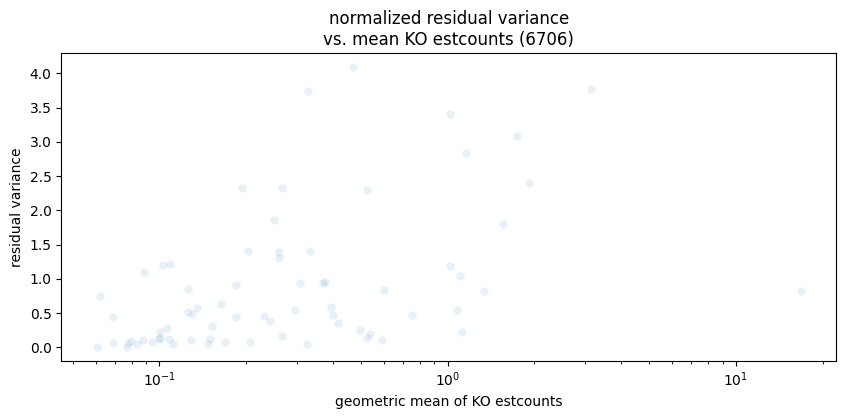

Normalizing slab 148 of 166: 6657 (52 samples, 48 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 48

R[write to console]: Total overdispersed genes: 48

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 48 by 52

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 48 genes, 52 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.16

R[write to console]: Second step: Get residuals using fitted parameters for 48 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5223751 secs



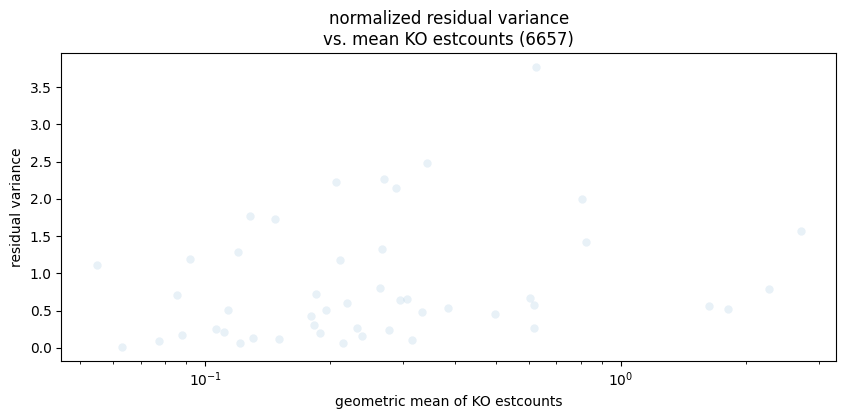

Normalizing slab 149 of 166: 33317 (53 samples, 39 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 39

R[write to console]: Total overdispersed genes: 39

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 39 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 39 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.259300934656

R[write to console]: Second step: Get residuals using fitted parameters for 39 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5188 secs



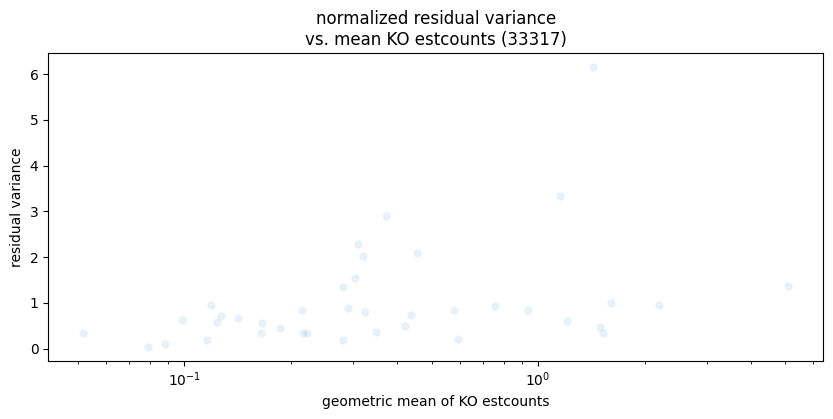

Normalizing slab 150 of 166: 34765 (53 samples, 124 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 124

R[write to console]: Total overdispersed genes: 124

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 124 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 124 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  1

R[write to console]: Second step: Get residuals using fitted parameters for 124 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5527933 secs



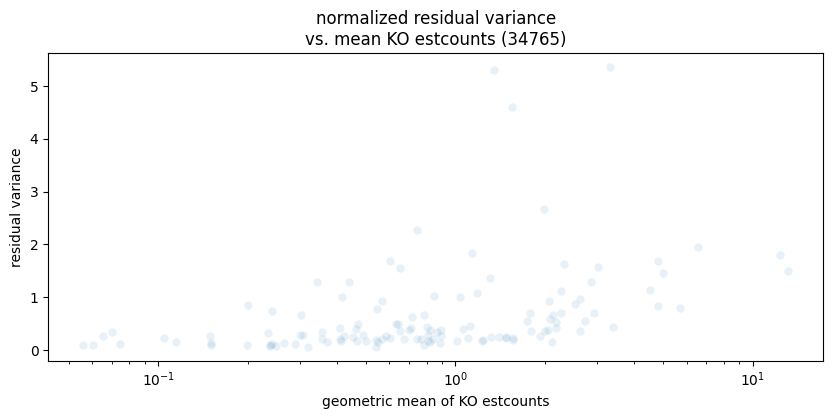

Normalizing slab 151 of 166: 33511 (49 samples, 39 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 39

R[write to console]: Total overdispersed genes: 39

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 39 by 49

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 39 genes, 49 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.203700574224

R[write to console]: Second step: Get residuals using fitted parameters for 39 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.517822 secs



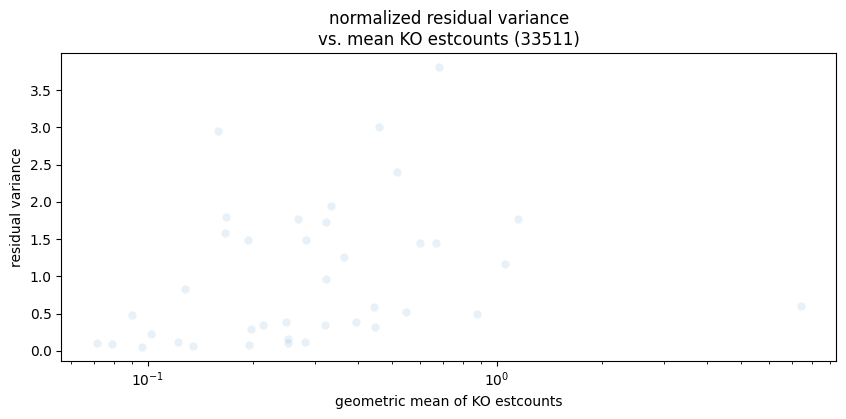

Normalizing slab 152 of 166: 33213 (53 samples, 106 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 106

R[write to console]: Total overdispersed genes: 106

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 106 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 106 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 106 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5544734 secs



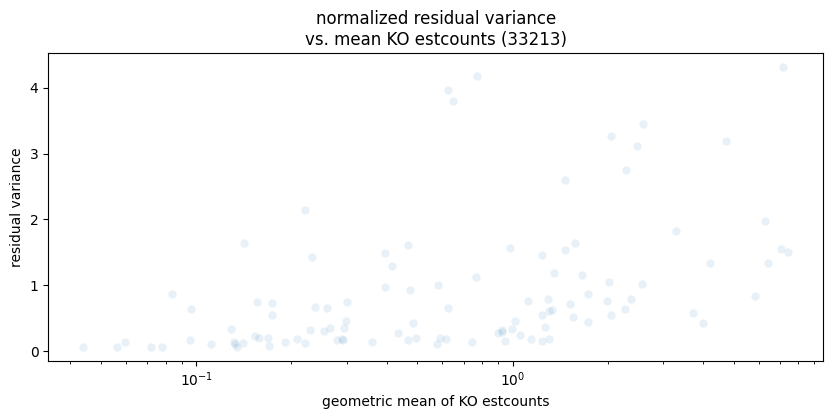

Normalizing slab 153 of 166: 6087 (53 samples, 72 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 72

R[write to console]: Total overdispersed genes: 72

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 72 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 72 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.361475107984

R[write to console]: Second step: Get residuals using fitted parameters for 72 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5735648 secs



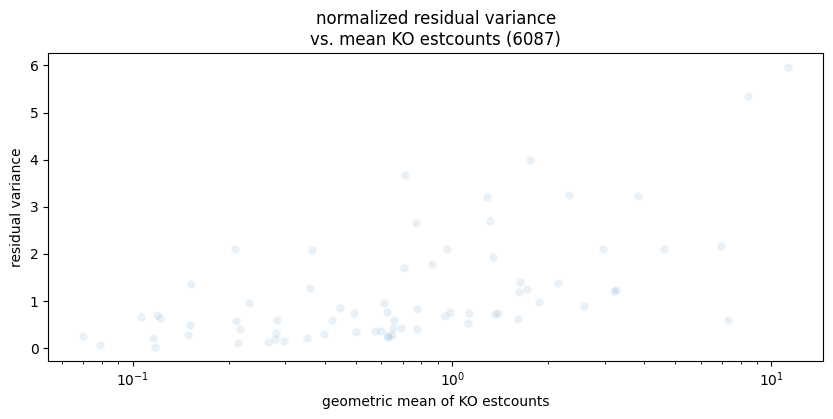

Normalizing slab 154 of 166: 6072 (53 samples, 120 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 120

R[write to console]: Total overdispersed genes: 119

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 120 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 119 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.633332655684

R[write to console]: Second step: Get residuals using fitted parameters for 120 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5566595 secs



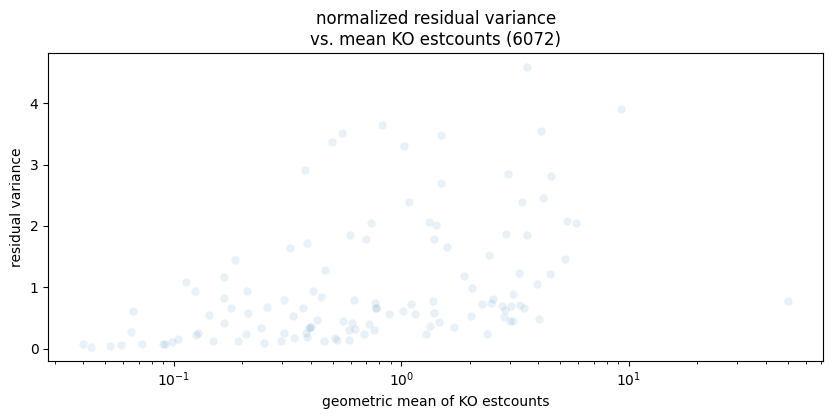

Normalizing slab 155 of 166: 33208 (53 samples, 73 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 73

R[write to console]: Total overdispersed genes: 73

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 73 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 73 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Found 1 outliers - those will be ignored in fitting/regularization step


R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.356018668929

R[write to console]: Second step: Get residuals using fitted parameters for 73 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5294402 secs



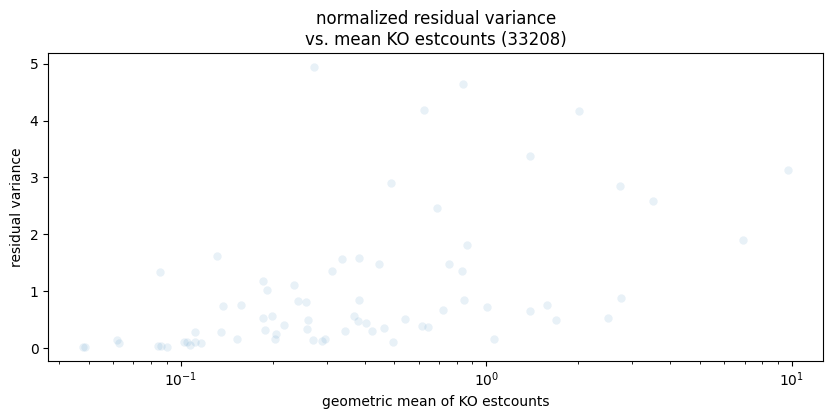

Normalizing slab 156 of 166: 2183100 (53 samples, 70 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 70

R[write to console]: Total overdispersed genes: 69

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 70 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 69 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.554878989604

R[write to console]: Second step: Get residuals using fitted parameters for 70 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5172191 secs



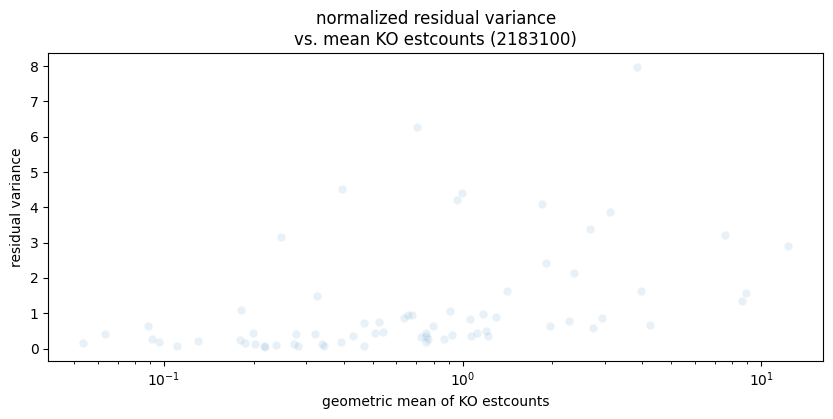

Normalizing slab 157 of 166: 33154 (53 samples, 47 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 47

R[write to console]: Total overdispersed genes: 47

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 47 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 47 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.437375886336

R[write to console]: Second step: Get residuals using fitted parameters for 47 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5699337 secs



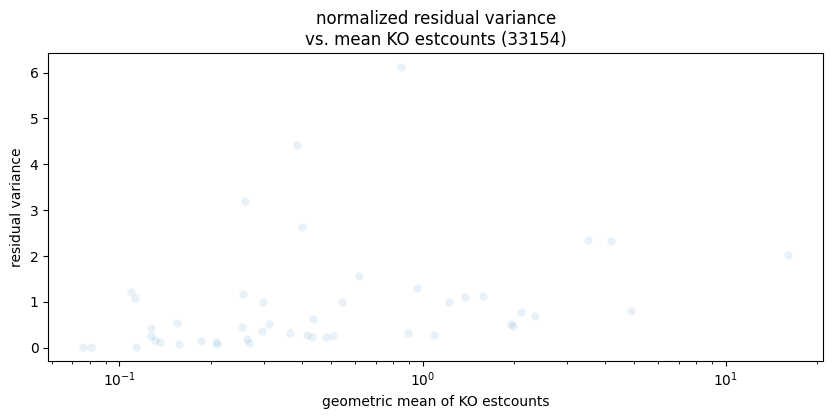

Normalizing slab 158 of 166: 195067 (53 samples, 35 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 35

R[write to console]: Total overdispersed genes: 35

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 35 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 35 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.793303736976

R[write to console]: Second step: Get residuals using fitted parameters for 35 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5129704 secs



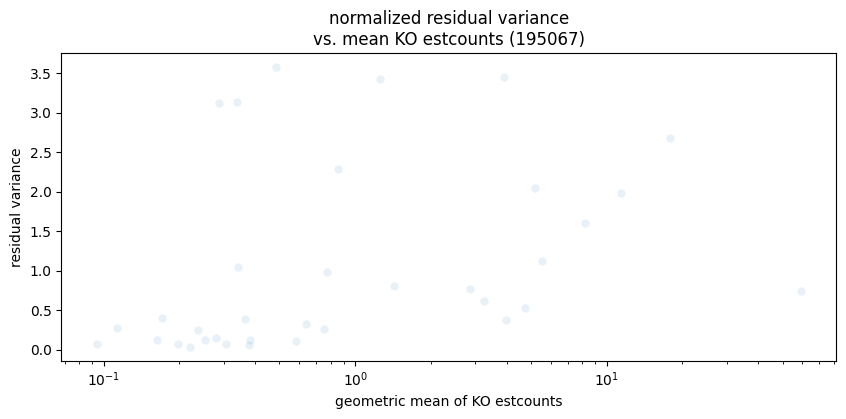

Normalizing slab 159 of 166: 418966 (53 samples, 38 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 38

R[write to console]: Total overdispersed genes: 38

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 38 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 38 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  4.6724280964

R[write to console]: Second step: Get residuals using fitted parameters for 38 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5136728 secs



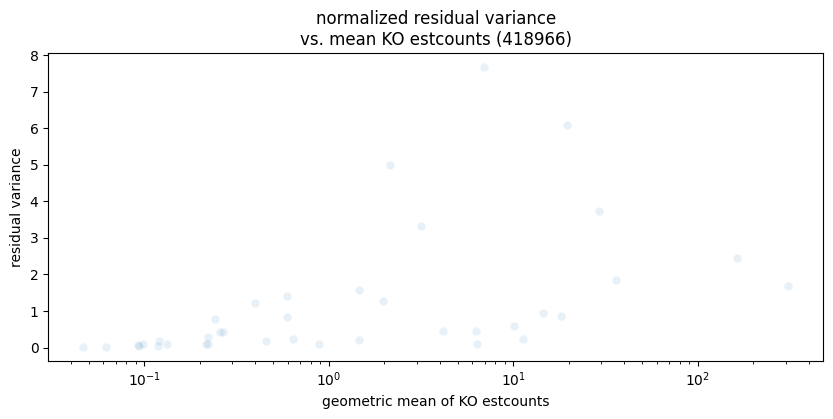

Normalizing slab 160 of 166: 35140 (53 samples, 46 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 46

R[write to console]: Total overdispersed genes: 46

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 46 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 46 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  4.423475478436

R[write to console]: Second step: Get residuals using fitted parameters for 46 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5181477 secs



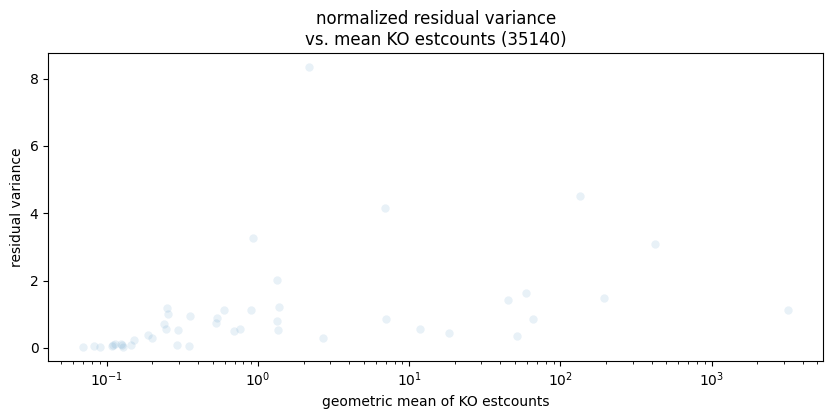

Normalizing slab 161 of 166: 73028 (53 samples, 38 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 38

R[write to console]: Total overdispersed genes: 38

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 38 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 38 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 38 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.586354 secs



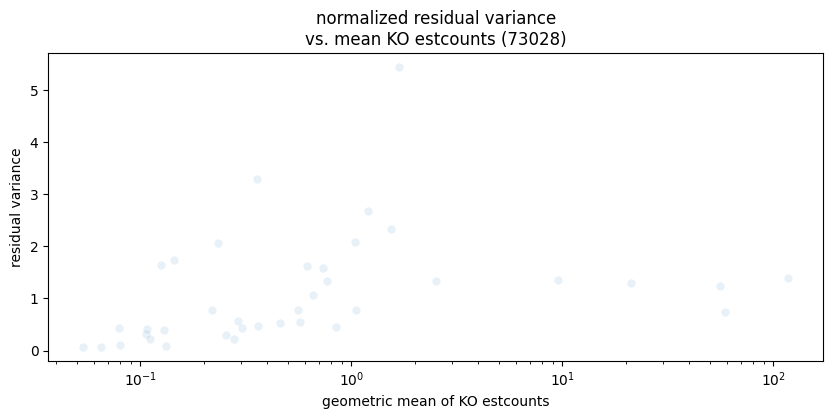

Normalizing slab 162 of 166: 33656 (53 samples, 77 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 77

R[write to console]: Total overdispersed genes: 77

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 77 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 77 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  6.4814031396

R[write to console]: Second step: Get residuals using fitted parameters for 77 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5293226 secs



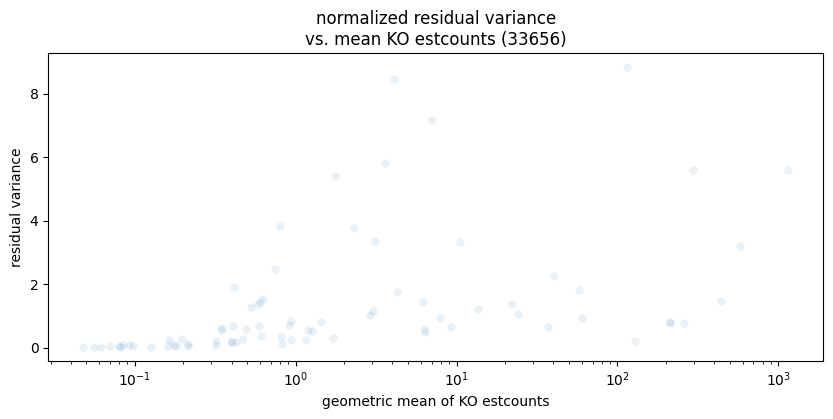

Normalizing slab 163 of 166: 2608131 (53 samples, 113 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 113

R[write to console]: Total overdispersed genes: 112

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 113 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 112 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  2.629722776164

R[write to console]: Second step: Get residuals using fitted parameters for 113 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5449262 secs



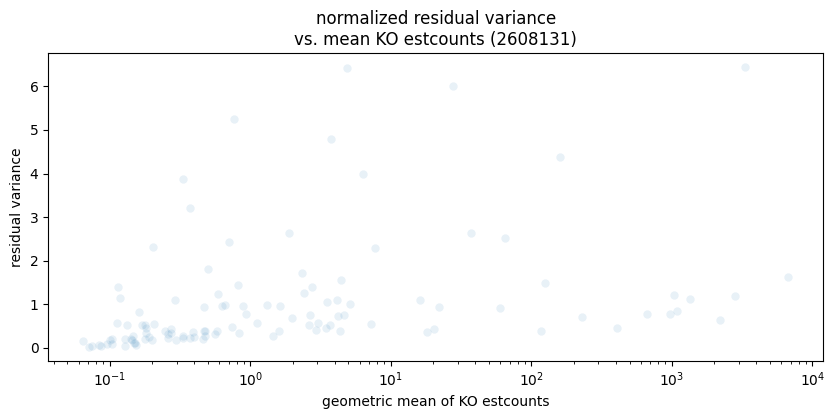

Normalizing slab 164 of 166: 2759 (53 samples, 308 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 308

R[write to console]: Total overdispersed genes: 308

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 308 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 308 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  7.33174868148804

R[write to console]: Second step: Get residuals using fitted parameters for 308 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.6204848 secs



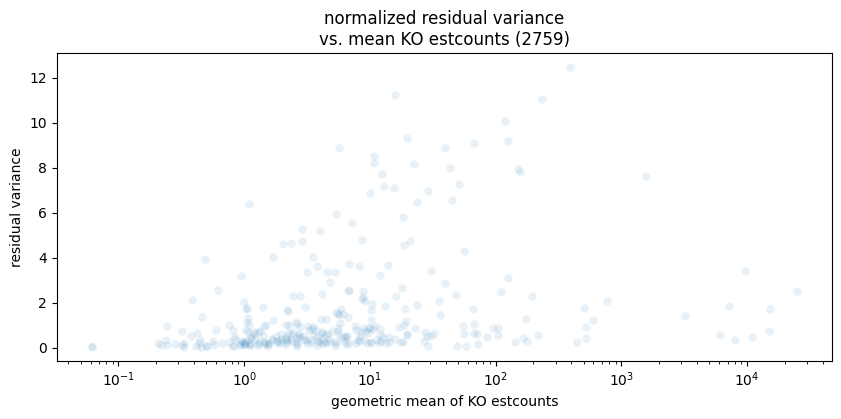

Normalizing slab 165 of 166: 274854 (53 samples, 87 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 87

R[write to console]: Total overdispersed genes: 86

R[write to console]: Excluding 1 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 87 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 86 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 1

R[write to console]: Calling offset model for all 1 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 1 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  0.64

R[write to console]: Second step: Get residuals using fitted parameters for 87 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.5394018 secs



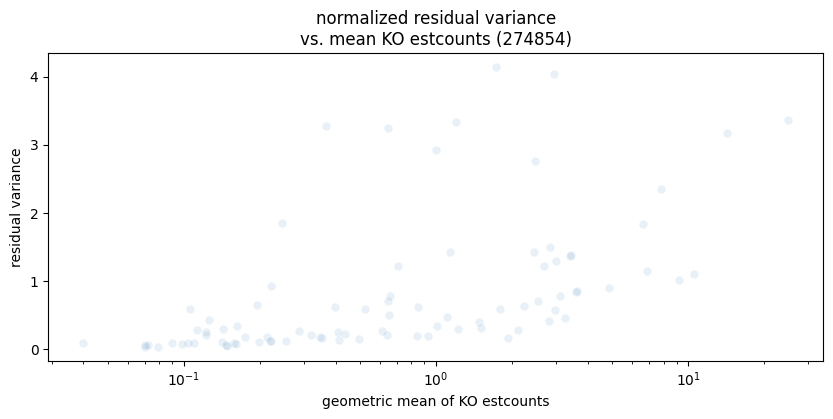

Normalizing slab 166 of 166: 131567 (53 samples, 305 genes)


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 305

R[write to console]: Total overdispersed genes: 305

R[write to console]: Excluding 0 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 305 by 53

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 305 genes, 53 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  0 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: # of step1 poisson genes (variance < mean): 0

R[write to console]: # of low mean genes (mean < 0.001): 0

R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 0

R[write to console]: Calling offset model for all 0 poisson genes

R[write to console]: Ignoring theta inf genes

R[write to console]: Replacing fit params for 0 poisson genes by theta=Inf

R[write to console]: Setting min_variance based on median UMI:  12.549717183364

R[write to console]: Second step: Get residuals using fitted parameters for 305 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.6346154 secs



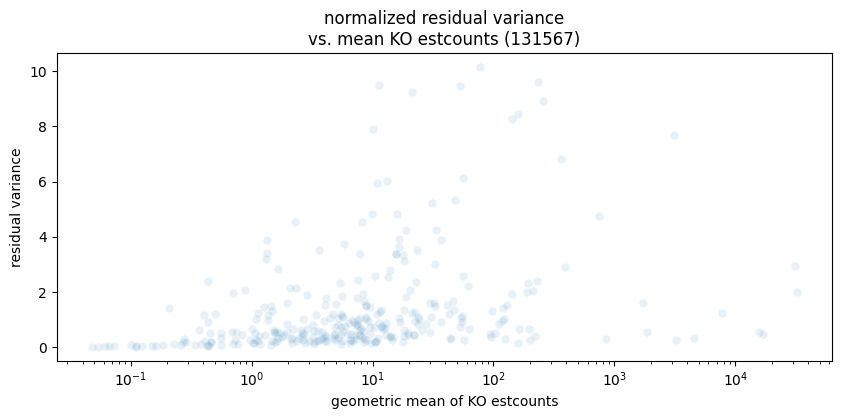

In [88]:
# run the model on each slab

# make normalization directory within output directory
# outdir_n = f'{outdir}/normalization'
# os.makedirs(outdir)

# initialize residuals dataframe
residuals_df = pd.DataFrame()

# keep track of filtered data
dropped_data_df = pd.DataFrame()

# iterate through slabs
slab_ids = df[norm_mode].unique()
for i, slab_id in enumerate(slab_ids):
    # separate out data
    slab_df = df[df[norm_mode].eq(slab_id)].pivot(index=gene_mode, columns=['sample_rep_id'], values=data).fillna(0)
    # apply sample threshold to filter out low-prevalence genes
    slab_df, drop_df = sparsity_thold_df(slab_df, sample_thold, axis=1)
    drop_df = drop_df.melt(value_name=data, ignore_index=False).reset_index()
    drop_df[norm_mode] = slab_id
    drop_df['drop_reason'] = f'{gene_mode} detected in fewer than {sample_thold} {sample_mode}s'
    dropped_data_df = pd.concat([dropped_data_df, drop_df])
    # apply gene threshold to filter out samples with low detection
    slab_df, drop_df = sparsity_thold_df(slab_df, gene_thold, axis=0)
    drop_df = drop_df.melt(value_name=data, ignore_index=False).reset_index()
    drop_df[norm_mode] = slab_id
    drop_df['drop_reason'] = f'{sample_mode} contains fewer than {math.ceil(slab_df.shape[0] * gene_thold)} nonzero {gene_mode}s'
    dropped_data_df = pd.concat([dropped_data_df, drop_df])
    # check for very small slabs
    if (slab_df.shape[0] < 10) or (slab_df.shape[1] < sample_thold):
        print(f'Skipping slab {i+1} of {len(slab_ids)}: {slab_id} ({slab_df.shape[1]} samples, {slab_df.shape[0]} genes)', flush=True)
        print('\tLimited nonzero data in this slab undermines the reliability of normalization with sctransform.', flush=True)
        drop_df = slab_df.melt(value_name=data, ignore_index=False).reset_index()
        drop_df[norm_mode] = slab_id
        drop_df['drop_reason'] = f'{norm_mode} encompassed fewer than 10 {gene_mode}s or fewer than {sample_thold} {sample_mode}s'
        dropped_data_df = pd.concat([dropped_data_df, drop_df])
        continue
    else:
        print(f'Normalizing slab {i+1} of {len(slab_ids)}: {slab_id} ({slab_df.shape[1]} samples, {slab_df.shape[0]} genes)', flush=True)

    # make r version of slab dataframe
    r_slab_df = pandas_dataframe_to_r_matrix(slab_df)
    # pull out batch information
    if correction:
        sample_attr_df = meta_df.set_index('sample_rep_id').loc[slab_df.columns, [sample_mode, rep, batch_id]]
    else: 
        sample_attr_df = df[['sample_rep_id', sample_mode, rep]].set_index('sample_rep_id').drop_duplicates()
        sample_attr_df = sample_attr_df.loc[slab_df.columns,:]
    r_sample_attr_df = pandas2ri.py2rpy(sample_attr_df)
        

    # fit vst normalization model
    # Use glmgampoi
    result = sctransform.vst(
        r_slab_df, 
        cell_attr=r_sample_attr_df, 
        batch_var=(ro.vectors.StrVector([batch_id]) if correction else ro.NULL),
        min_cells=sample_thold,
        return_gene_attr=True, 
        return_cell_attr=True, 
        vst_flavor='v2', 
        verbosity=2,
        method='glmGamPoi'
    )

    # Get names from result in case genes get dropped from sctransform (not overdispersed)
    with ro.conversion.localconverter(ro.default_converter + pandas2ri.converter):
        genes = ro.conversion.rpy2py(result[11]).index.values
        cells = ro.conversion.rpy2py(result[10]).index.values
    # convert residuals result to a dataframe
    result_df = pd.DataFrame(
        np.asarray(result[0]), 
        index=genes, 
        columns=cells
    )

    # prepare to save requested outputs
    if save_data or save_plots:
        # make unique output directory per slab
        dir_path = f'{outdir_n}/{slab_id}'
        if not os.path.isdir(dir_path):
            os.makedirs(dir_path)
        # calculate residuals
        residual_var = result_df.var(axis=1)

    # save data if requested
    if save_data:
        # save csv of residuals
        result_df.to_csv(f'{dir_path}/residuals_{slab_id}.csv')
        # save csv of residual variances
        res_var_df = residual_var.reset_index().rename(columns={0:'residual_variance'})
        res_var_df = res_var_df.sort_values('residual_variance', ascending=False).reset_index()
        res_var_df.to_csv(f'{dir_path}/residual_variances_{slab_id}.csv')

    # save plots if requested
    if save_plots:
        # plots of model parameters
        plots = sctransform.plot_model_pars(result, show_theta=True)
        img = image_png(plots)
        with open(f'{dir_path}/parameters_{slab_id}.png', 'wb') as png:
            png.write(img.data)
        # plot of high variance genes
        means = slab_df.apply(geometric_mean, axis=1)
        plt.figure(figsize=(10, 4))
        sns.scatterplot(x=means, y=residual_var, alpha=0.1);
        plt.xlabel(f'geometric mean of {gene_mode} {data}')
        plt.xscale('log')
        plt.ylabel('residual variance')
        plt.title(f'normalized residual variance\nvs. mean {gene_mode} {data} ({slab_id})')
        plt.savefig(f'{dir_path}/residual_variances_{slab_id}.png')
        plt.show()

    # concatenate result with other residuals
    result_df = result_df.melt(value_name='residual', ignore_index=False).reset_index()
    result_df[norm_mode] = slab_id
    residuals_df = pd.concat([residuals_df, result_df])
    

In [91]:
f"{outdir_n}/normalized-residuals.csv"

'/scratch/bgrodner/iron_ko_contigs/metat_search_results/barnacle/G3NS/normalization/normalized-residuals.csv'

In [89]:
# save normalized data as a csv

# revert column names changed by sctransform
residuals_df = residuals_df.rename(columns={'variable': 'sample_rep_id', 'index': gene_mode})

# add back sample information
residuals_df = pd.merge(residuals_df, df[['sample_rep_id', sample_mode, rep]].drop_duplicates(), on='sample_rep_id', how='left')

# add in raw count data
residuals_df = pd.merge(residuals_df, df, on=['sample_rep_id', mode0, mode1, mode2, rep], how='left').fillna(0)

# tidy up dataframe
residuals_df = residuals_df[[mode0, mode1, mode2, rep, data, 'residual']]

# save output
residuals_df.to_csv(f'{outdir_n}/normalized-residuals.csv')

residuals_df


KO  taxon_trim                       assm_sample rep  estcounts  \
0       K00180         356  G3.UW.NS-UW25-nan-nan-1.7m-0.2um   A     0.0000   
1       K00216         356  G3.UW.NS-UW25-nan-nan-1.7m-0.2um   A     0.0000   
2       K00264         356  G3.UW.NS-UW25-nan-nan-1.7m-0.2um   A    15.0000   
3       K00265         356  G3.UW.NS-UW25-nan-nan-1.7m-0.2um   A    17.4565   
4       K00266         356  G3.UW.NS-UW25-nan-nan-1.7m-0.2um   A     6.0000   
...        ...         ...                               ...  ..        ...   
589536  K25285      131567    G3.UW.NS-UW40-nan-nan-2.7m-3um   C     0.0000   
589537  K25286      131567    G3.UW.NS-UW40-nan-nan-2.7m-3um   C     0.0000   
589538  K25288      131567    G3.UW.NS-UW40-nan-nan-2.7m-3um   C     0.0000   
589539  K25289      131567    G3.UW.NS-UW40-nan-nan-2.7m-3um   C     0.0000   
589540  K25290      131567    G3.UW.NS-UW40-nan-nan-2.7m-3um   C     0.0000   

        residual  
0      -0.304527  
1      -0.316364  
2      -0.839637  
3      -0.503779  
4      -0.088899  
...          ...  
589536 -0.676876  
589537 -0.517741  
589538 -0.492673  
589539 -0.552834  
589540 -0.604498  

[589541 rows x 6 columns]

In [90]:
# examine data that was removed during normalization process

# remove zero values
dropped_data_df = dropped_data_df[dropped_data_df[data] != 0.0]

# add back sample information
dropped_data_df = pd.merge(dropped_data_df, df[['sample_rep_id', sample_mode, rep]].drop_duplicates(), on='sample_rep_id', how='left')

# tidy up dataframe
dropped_data_df = dropped_data_df[[mode0, mode1, mode2, rep, data, 'drop_reason']]

# show some summary statistics
for variable in ['drop_reason', mode0, mode1, mode2]:
    print(dropped_data_df[variable].value_counts())

# save drop data
dropped_data_df.to_csv(f'{outdir_n}/removed-data.csv')      

dropped_data_df


drop_reason
KO detected in fewer than 3 assm_samples    588
Name: count, dtype: int64
KO
K04789    11
K04784    10
K00265     9
K02364     9
K11952     9
          ..
K23723     1
K15752     1
K12237     1
K07684     1
K02015     1
Name: count, Length: 184, dtype: int64
taxon_trim
33317      19
226        17
1236       16
1783272    14
116571     13
           ..
28216       1
104267      1
203683      1
68336       1
395922      1
Name: count, Length: 125, dtype: int64
assm_sample
G3.UW.NS-UW40-nan-nan-1.7m-0.2um    59
G3.UW.NS-UW32-nan-nan-3.7m-0.2um    43
G3.UW.NS-UW40-nan-nan-2.7m-0.2um    42
G3.UW.NS-UW25-nan-nan-1.7m-3um      41
G3.UW.NS-UW25-nan-nan-1.7m-0.2um    40
G3.UW.NS-UW32-nan-nan-1.7m-0.2um    39
G3.UW.NS-UW40-nan-nan-1.7m-3um      38
G3.UW.NS-UW35-nan-nan-2.7m-0.2um    38
G3.UW.NS-UW38-nan-nan-1.7m-0.2um    34
G3.UW.NS-UW35-nan-nan-1.7m-0.2um    30
G3.UW.NS-UW35-nan-nan-2.7m-3um      29
G3.UW.NS-UW32-nan-nan-3.7m-3um      25
G3.UW.NS-UW29-nan-nan-1.7m-0.2um    25
G3.UW.

KO  taxon_trim                       assm_sample rep  estcounts  \
0    K18495         356  G3.UW.NS-UW29-nan-nan-1.7m-0.2um   B    6.00000   
1    K22341         356  G3.UW.NS-UW32-nan-nan-1.7m-0.2um   B    3.00000   
2    K12240         356    G3.UW.NS-UW40-nan-nan-1.7m-3um   B    3.00000   
3    K12240         356    G3.UW.NS-UW40-nan-nan-1.7m-3um   C    4.00000   
4    K04784       28211  G3.UW.NS-UW29-nan-nan-1.7m-0.2um   B    2.71937   
..      ...         ...                               ...  ..        ...   
583  K11952      274854  G3.UW.NS-UW25-nan-nan-1.7m-0.2um   B    5.00000   
584  K01624      274854  G3.UW.NS-UW40-nan-nan-2.7m-0.2um   A    1.00000   
585  K01624      274854  G3.UW.NS-UW40-nan-nan-2.7m-0.2um   C    2.00000   
586  K18248      131567  G3.UW.NS-UW25-nan-nan-1.7m-0.2um   A    5.00000   
587  K18248      131567  G3.UW.NS-UW25-nan-nan-1.7m-0.2um   B    2.00000   

                                  drop_reason  
0    KO detected in fewer than 3 assm_samples  
1    KO detected in fewer than 3 assm_samples  
2    KO detected in fewer than 3 assm_samples  
3    KO detected in fewer than 3 assm_samples  
4    KO detected in fewer than 3 assm_samples  
..                                        ...  
583  KO detected in fewer than 3 assm_samples  
584  KO detected in fewer than 3 assm_samples  
585  KO detected in fewer than 3 assm_samples  
586  KO detected in fewer than 3 assm_samples  
587  KO detected in fewer than 3 assm_samples  

[588 rows x 6 columns]